In [1]:
import sys
sys.path.append('..')
sys.path.append('../../src/')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from os import path
from glob import glob

import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Conv2D, GlobalAvgPool2D
from keras.layers import Dense, Dropout, Concatenate
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import Sequence

from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from utils import load, plot
from local_config import FOLDER_IMAGES, FOLDER_MODELS
from global_config import RANDOM_SEED, IMAGE_SIZE
from custom_metrics import precision, recall, f1, specificity 
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from custom_metrics import equal_error_rate as eer

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
FILE_BASE_MODEL = '../../models/siamese_networks/autoencoder_2020_06_02-22_00_23.h5'

VALID_SIZE = 0.2
BATCH_SIZE = 32
ALPHA = 100
EPOCHS = 100
MLFLOW_EXPERIMENT_NAME = 'Siamese Networks'

print(FILE_BASE_MODEL)
print(FOLDER_IMAGES)
print(FOLDER_MODELS)

../../models/siamese_networks/autoencoder_2020_06_02-22_00_23.h5
../../data/siamese_networks
../../models/siamese_networks


In [3]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)    

In [4]:
def load_pos_and_neg_images(req_name):
    pos_files = glob(f"{FOLDER_IMAGES}/{req_name}/positives/*")
    neg_files = glob(f"{FOLDER_IMAGES}/{req_name}/negatives/*")
    
    x_pos = load.images_from_list_files(pos_files, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    x_neg = load.images_from_list_files(neg_files, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    
    x_pos_train, x_pos_valid = train_test_split(x_pos, test_size=VALID_SIZE, random_state=RANDOM_SEED)
    x_neg_train, x_neg_valid = train_test_split(x_neg, test_size=VALID_SIZE, random_state=RANDOM_SEED)
    
    return x_pos_train, x_pos_valid, x_neg_train, x_neg_valid


def setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid):
    x_train = np.concatenate((x_pos_train, x_neg_train), axis=0)
    y_train = np.array([1]*x_pos_train.shape[0] + [0]*x_neg_train.shape[0])
    
    x_valid = np.concatenate((x_pos_valid, x_neg_valid), axis=0)
    y_valid = np.array([1]*x_pos_valid.shape[0] + [0]*x_neg_valid.shape[0])
    
    return x_train, y_train, x_valid, y_valid

In [5]:
def print_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))
    print()

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

# Triplet Generator 

In [6]:
class RandomTripletGenerator(Sequence):
    """Generate Random Triplets (A, P, N) for Siamese Networks on the fly"""

    def __init__(self, pos_images, neg_images, emb_dim, batch_size=1, datagen=ImageDataGenerator(), random_seed=None):
        self.pos_images = pos_images
        self.neg_images = neg_images
        self.emb_dim = emb_dim
        self.batch_size = min(pos_images.shape[0], neg_images.shape[0], batch_size)
        self.datagen = datagen
        np.random.seed(random_seed)
        
    def __len__(self):
        n_pos = self.pos_images.shape[0]
        n_neg = self.neg_images.shape[0]
        return min(n_pos, n_neg) // self.batch_size
        
    def __getitem__(self, idx):
        anc_batch = self.datagen.flow(self.neg_images, batch_size=self.batch_size).next()
        pos_batch = self.datagen.flow(self.pos_images, batch_size=self.batch_size).next()
        neg_batch = self.datagen.flow(self.neg_images, batch_size=self.batch_size).next()
        
        x = [anc_batch, neg_batch, pos_batch]
        y = np.zeros(shape=(self.batch_size, 3 * self.emb_dim))
        return x, y


class DeterministicTripletGenerator(Sequence):
    def __init__(self, triplet_gen, steps_per_epoch):
        self.steps_per_epoch = steps_per_epoch
        self.anc_gen = []
        self.pos_gen = []
        self.neg_gen = []
        self.y_gen = []
        
        for i in range(steps_per_epoch):
            (anc, neg, pos), y = triplet_gen.__getitem__(None)
            self.anc_gen.append(anc)
            self.neg_gen.append(neg)
            self.pos_gen.append(pos)
            self.y_gen.append(y)
            
    def __len__(self):
        return self.steps_per_epoch
        
    def __getitem__(self, idx):
        anc_batch = self.anc_gen[idx]
        neg_batch = self.neg_gen[idx]
        pos_batch = self.pos_gen[idx]
        y_batch = self.y_gen[idx]
        
        return [anc_batch, neg_batch, pos_batch], y_batch

# Classification Generator 

In [7]:
class RandomBalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen=ImageDataGenerator(), batch_size=1):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        self._shape = x.shape   
        
        self.datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(
            x.reshape(x.shape[0], -1), 
            y, 
            sampler=RandomOverSampler(), 
            batch_size=self.batch_size, 
            keep_sparse=True
        )
        
    def __len__(self):
        return self.steps_per_epoch   
    
    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()


class DeterministicBalancedGenerator(Sequence):
    def __init__(self, balanced_gen):
        self.x_gen = []
        self.y_gen = []
        self.steps_per_epoch = balanced_gen.steps_per_epoch
        
        for i in range(balanced_gen.steps_per_epoch):
            x, y = balanced_gen.__getitem__(None)
            self.x_gen.append(x)
            self.y_gen.append(y)
        
    def __len__(self):
        return self.steps_per_epoch
        
    def __getitem__(self, idx):
        return self.x_gen[idx], self.y_gen[idx]

# Triplet Loss 

In [8]:
def triplet_loss(alpha=0.2):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
        anc -- the encodings for the anchor data
        pos -- the encodings for the positive data
        neg -- the encodings for the negative data
    Returns:
    loss -- real number, value of the loss
    """
    def loss_func(y_true, y_pred):
        total_length = y_pred.shape.as_list()[-1]

        anc = y_pred[:, 0:int(total_length * 1/3)]
        pos = y_pred[:, int(total_length * 1/3):int(total_length * 2/3)]
        neg = y_pred[:, int(total_length * 2/3):int(total_length * 3/3)]
        
        pos_dist = K.sum(K.square(anc - pos), axis=1)
        neg_dist = K.sum(K.square(anc - neg), axis=1)

        loss = K.maximum(pos_dist - neg_dist + alpha, 0.0)
        return loss
 
    return loss_func

# Training Functions 

In [9]:
def load_encoder(file_encoder):
    autoencoder = load_model(file_encoder)
    encoder_output = autoencoder.get_layer(name='encoded').output
    encoder = Model(inputs=autoencoder.inputs, outputs=encoder_output)
    return encoder


def build_shared_model(base_model, name):
    set_random_seeds()
    
    req_emb = GlobalAvgPool2D()(base_model.output)
    req_emb = Dropout(rate=0.5)(req_emb)
    req_emb = Dense(units=128, activation='relu', name=f'{name}_embeddings_1')(req_emb)
    req_emb = Dropout(rate=0.5)(req_emb)
    req_emb = Dense(units=128, activation='tanh', name=f'{name}_embeddings')(req_emb)
    req_model = Model(inputs=base_model.inputs, outputs=req_emb)

    for layer in req_model.layers:
        layer.trainable = (name in layer.name)
    return req_model


def build_siamese_model(base_model):
    set_random_seeds()

    input_anc = Input(shape=(*IMAGE_SIZE, 3))
    input_pos = Input(shape=(*IMAGE_SIZE, 3))
    input_neg = Input(shape=(*IMAGE_SIZE, 3))

    output_anc = base_model(input_anc)
    output_pos = base_model(input_pos)
    output_neg = base_model(input_neg)

    inputs = [input_anc, input_pos, input_neg]
    outputs = Concatenate(axis=-1)([output_anc, output_pos, output_neg])

    triplet_model = Model(inputs, outputs)
    triplet_model.compile(optimizer='adam', loss=triplet_loss(ALPHA))
    return triplet_model


def build_classification_model(base_model, name):
    set_random_seeds()
    
    output_name = f'{name}_embeddings'
    outputs = base_model.get_layer(output_name).output
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = name.endswith(layer.name)
        
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc, eer]
    )
    
    return model

In [10]:
def train_siamese_model(model, train_gen, valid_gen):
    list_callbacks = [
        EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True),
    ]
    
    hist = model.fit_generator(
        train_gen, 
        steps_per_epoch=100,
        epochs=EPOCHS,
        validation_data=valid_gen,
        validation_steps=valid_gen.steps_per_epoch,
        callbacks=list_callbacks
    )
    
    plot.keras_hist(hist.history)


def train_classification_model(model, train_gen, valid_gen, name):
    FILE_MODEL = FOLDER_MODELS + '/' + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=50, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("alpha", ALPHA)
    mlflow.log_param("valid_size", VALID_SIZE)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("file_model", FILE_MODEL)
    mlflow.set_tag("requirement", name)
    mlflow.keras.autolog()

    hist = model.fit_generator(
        train_gen, 
        steps_per_epoch=train_gen.steps_per_epoch,
        epochs=EPOCHS,
        validation_data=valid_gen,
        validation_steps=valid_gen.steps_per_epoch,
        callbacks=list_callbacks
    )
    
    plot.keras_hist(hist.history)
    mlflow.end_run()
    
    return FILE_MODEL

In [11]:
def run_siamese_training(file_encoder, train_data, valid_data, train_gen, valid_gen, name):
    model_encoder = load_encoder(file_encoder)
    model_shared = build_shared_model(model_encoder, name)
    model_siamese = build_siamese_model(model_shared)
    
    emb_dim = model_siamese.output_shape[-1] // 3
    
    x_pos_train, x_neg_train = train_data
    x_pos_valid, x_neg_valid = valid_data
    seed_triplet = RandomTripletGenerator(x_pos_valid, x_neg_valid, emb_dim, BATCH_SIZE, valid_gen, RANDOM_SEED)
    train_gen_triplet = RandomTripletGenerator(x_pos_train, x_neg_train, emb_dim, BATCH_SIZE, train_gen)
    valid_gen_triplet = DeterministicTripletGenerator(seed_triplet, steps_per_epoch=100)
    
    train_siamese_model(model_siamese, train_gen_triplet, valid_gen_triplet)

    return model_shared


def run_classification_training(model_shared, train_data, valid_data, train_gen, valid_gen, name):
    x_train, y_train = train_data
    x_valid, y_valid = valid_data
    
    valid_bal = RandomBalancedDataGenerator(x_valid, y_valid, valid_gen, BATCH_SIZE)
    train_gen_bal = RandomBalancedDataGenerator(x_train, y_train, train_gen, BATCH_SIZE)
    valid_gen_bal = DeterministicBalancedGenerator(valid_bal)
    
    model_classification = build_classification_model(model_shared, name)
    file_model = train_classification_model(model_classification, train_gen_bal, valid_gen_bal, name)

    x_gen = valid_gen.flow(x_valid, batch_size=len(y_valid), shuffle=False).next()
    y_pred = model_classification.predict(x_gen).flatten()
    y_pred = np.where(y_pred > 0.5, 1, 0)
    print_metrics(y_valid, y_pred)
    
    return file_model

# Requirements Training 

In [12]:
list_model_files = []

#### 2. Blurred

71 of 71
48 of 48
(94, 160, 160, 3) float32
(94,) int32
(25, 160, 160, 3) float32
(25,) int32
Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
100/100 [==============================] - 18s 183ms/step - loss: 92.7723 - val_loss: 75.4052
Epoch 2/100
100/100 [==============================] - 16s 157ms/step - loss: 71.4067 - val_loss: 63.5930
Epoch 3/100
100/100 [==============================] - 16s 157ms/step - loss: 55.6245 - val_loss: 66.5880
Epoch 4/100
100/100 [==============================] - 16s 157ms/step - loss: 37.5643 - val_loss: 63.7259
Epoch 5/100
100/100 [==============================] - 16s 157ms/step - loss: 24.3604 - val_loss: 44.7585
Epoch 6/100
100/100 [==============================] - 16s 158ms/step - loss: 14.2633 - val_loss: 48.4828
Epoch 7/100
100/100 [==============================] - 16s 159ms/step - loss: 8.2939 - val_loss: 55.0043
Epoch 8/100
100/100 [==============================] - 16s 158ms/step - loss: 6.1376 - val_loss: 45.6559
Epoch 9/100
100/100 [==============================] - 16s 158ms/step - loss: 4.8436 - val_loss: 44.4032
E

Epoch 76/100
100/100 [==============================] - 16s 158ms/step - loss: 0.6885 - val_loss: 59.3965
Epoch 77/100
100/100 [==============================] - 16s 158ms/step - loss: 0.5396 - val_loss: 53.0044
Epoch 78/100
100/100 [==============================] - 16s 158ms/step - loss: 0.4528 - val_loss: 55.2103
Epoch 79/100
100/100 [==============================] - 16s 159ms/step - loss: 0.2942 - val_loss: 55.1431
Epoch 80/100
100/100 [==============================] - 16s 158ms/step - loss: 0.2780 - val_loss: 53.0825
Epoch 81/100
100/100 [==============================] - 16s 159ms/step - loss: 0.6118 - val_loss: 51.2793
Epoch 82/100
100/100 [==============================] - 16s 159ms/step - loss: 0.4305 - val_loss: 51.6380
Epoch 83/100
100/100 [==============================] - 16s 158ms/step - loss: 0.4195 - val_loss: 51.3809
Epoch 84/100
100/100 [==============================] - 16s 158ms/step - loss: 0.4610 - val_loss: 54.6105
Epoch 85/100
100/100 [========================

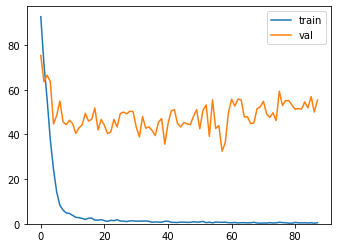

In [13]:
REQ_NAME = 'blurred'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 1s 479ms/step - loss: 1.0029 - accuracy: 0.1771 - precision: 0.2637 - recall: 0.3150 - f1: 0.2822 - specificity: 0.0175 - negative_predictive_value: 0.0303 - matthews_correlation_coefficient: -0.6858 - equal_error_rate: 0.8855 - val_loss: 0.7266 - val_accuracy: 0.4400 - val_precision: 0.4167 - val_recall: 0.4167 - val_f1: 0.4167 - val_specificity: 0.4615 - val_negative_predictive_value: 0.4615 - val_matthews_correlation_coefficient: -0.1218 - val_equal_error_rate: 0.5609

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.12179, saving model to ../../models/siamese_networks/blurred_2020_06_07-23_58_17.h5
Epoch 2/100
3/3 [==============================] - 1s 217ms/step - loss: 0.8979 - accuracy: 0.2250 - precision: 0.3171 - recall: 0.4349 - f1: 0.3448 - specificity: 0.0909 - negative_predictive_value: 0.0500 - matthews_correlation_coefficient: -0.5404 - equal_error_rate: 0.7815 - val_loss: 0.7137 - val_accuracy: 

3/3 [==============================] - 0s 104ms/step - loss: 0.5845 - accuracy: 0.6750 - precision: 1.0000 - recall: 0.3460 - f1: 0.4955 - specificity: 1.0000 - negative_predictive_value: 0.5861 - matthews_correlation_coefficient: 0.4363 - equal_error_rate: 0.1366 - val_loss: 0.7256 - val_accuracy: 0.6000 - val_precision: 0.7500 - val_recall: 0.2500 - val_f1: 0.3750 - val_specificity: 0.9231 - val_negative_predictive_value: 0.5714 - val_matthews_correlation_coefficient: 0.2359 - val_equal_error_rate: 0.4808

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.23586
Epoch 15/100
3/3 [==============================] - 0s 106ms/step - loss: 0.5770 - accuracy: 0.6875 - precision: 1.0000 - recall: 0.3541 - f1: 0.5006 - specificity: 1.0000 - negative_predictive_value: 0.6061 - matthews_correlation_coefficient: 0.4501 - equal_error_rate: 0.1477 - val_loss: 0.7263 - val_accuracy: 0.6000 - val_precision: 0.7500 - val_recall: 0.2500 - val_f1: 0.3750 - val_specificity: 0.9231

3/3 [==============================] - 0s 111ms/step - loss: 0.5233 - accuracy: 0.7500 - precision: 0.9778 - recall: 0.4493 - f1: 0.5759 - specificity: 0.9697 - negative_predictive_value: 0.6494 - matthews_correlation_coefficient: 0.4935 - equal_error_rate: 0.1595 - val_loss: 0.7187 - val_accuracy: 0.6800 - val_precision: 0.7500 - val_recall: 0.5000 - val_f1: 0.6000 - val_specificity: 0.8462 - val_negative_predictive_value: 0.6471 - val_matthews_correlation_coefficient: 0.3707 - val_equal_error_rate: 0.2821

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.47076
Epoch 28/100
3/3 [==============================] - 0s 110ms/step - loss: 0.4690 - accuracy: 0.8000 - precision: 1.0000 - recall: 0.5038 - f1: 0.6528 - specificity: 1.0000 - negative_predictive_value: 0.7258 - matthews_correlation_coefficient: 0.5998 - equal_error_rate: 0.1174 - val_loss: 0.7185 - val_accuracy: 0.6800 - val_precision: 0.7500 - val_recall: 0.5000 - val_f1: 0.6000 - val_specificity: 0.8462


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.47076
Epoch 41/100
3/3 [==============================] - 0s 138ms/step - loss: 0.4076 - accuracy: 0.7812 - precision: 0.9630 - recall: 0.5795 - f1: 0.7222 - specificity: 0.9804 - negative_predictive_value: 0.6889 - matthews_correlation_coefficient: 0.6016 - equal_error_rate: 0.0720 - val_loss: 0.7265 - val_accuracy: 0.7200 - val_precision: 0.7273 - val_recall: 0.6667 - val_f1: 0.6957 - val_specificity: 0.7692 - val_negative_predictive_value: 0.7143 - val_matthews_correlation_coefficient: 0.4387 - val_equal_error_rate: 0.2821

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.47076
Epoch 42/100
3/3 [==============================] - 0s 112ms/step - loss: 0.4547 - accuracy: 0.8000 - precision: 1.0000 - recall: 0.5873 - f1: 0.7333 - specificity: 1.0000 - negative_predictive_value: 0.6920 - matthews_correlation_coefficient: 0.6336 - equal_error_rate: 0.1344 - val_loss: 0.7278 - val_accuracy: 0

3/3 [==============================] - 0s 104ms/step - loss: 0.4546 - accuracy: 0.8125 - precision: 1.0000 - recall: 0.6286 - f1: 0.7702 - specificity: 1.0000 - negative_predictive_value: 0.7121 - matthews_correlation_coefficient: 0.6668 - equal_error_rate: 0.0712 - val_loss: 0.7334 - val_accuracy: 0.6400 - val_precision: 0.6000 - val_recall: 0.7500 - val_f1: 0.6667 - val_specificity: 0.5385 - val_negative_predictive_value: 0.7000 - val_matthews_correlation_coefficient: 0.2942 - val_equal_error_rate: 0.2404

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.51923
Epoch 55/100
3/3 [==============================] - 0s 107ms/step - loss: 0.4858 - accuracy: 0.7375 - precision: 1.0000 - recall: 0.4078 - f1: 0.5488 - specificity: 1.0000 - negative_predictive_value: 0.6366 - matthews_correlation_coefficient: 0.4907 - equal_error_rate: 0.1373 - val_loss: 0.7332 - val_accuracy: 0.6400 - val_precision: 0.6000 - val_recall: 0.7500 - val_f1: 0.6667 - val_specificity: 0.5385


Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.51923
Epoch 68/100
3/3 [==============================] - 0s 119ms/step - loss: 0.4250 - accuracy: 0.8375 - precision: 0.9667 - recall: 0.6435 - f1: 0.7700 - specificity: 0.9825 - negative_predictive_value: 0.7803 - matthews_correlation_coefficient: 0.6834 - equal_error_rate: 0.1058 - val_loss: 0.7420 - val_accuracy: 0.6000 - val_precision: 0.5625 - val_recall: 0.7500 - val_f1: 0.6429 - val_specificity: 0.4615 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.2202 - val_equal_error_rate: 0.2436

Epoch 00068: val_matthews_correlation_coefficient did not improve from 0.51923
Epoch 69/100
3/3 [==============================] - 0s 125ms/step - loss: 0.3525 - accuracy: 0.8750 - precision: 0.9630 - recall: 0.7639 - f1: 0.8502 - specificity: 0.9825 - negative_predictive_value: 0.8036 - matthews_correlation_coefficient: 0.7553 - equal_error_rate: 0.0637 - val_loss: 0.7427 - val_accuracy: 0

3/3 [==============================] - 0s 138ms/step - loss: 0.3280 - accuracy: 0.9167 - precision: 1.0000 - recall: 0.8115 - f1: 0.8887 - specificity: 1.0000 - negative_predictive_value: 0.8677 - matthews_correlation_coefficient: 0.8376 - equal_error_rate: 0.0504 - val_loss: 0.7543 - val_accuracy: 0.6000 - val_precision: 0.5625 - val_recall: 0.7500 - val_f1: 0.6429 - val_specificity: 0.4615 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.2202 - val_equal_error_rate: 0.2436

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.51923
Epoch 82/100
3/3 [==============================] - 0s 127ms/step - loss: 0.4059 - accuracy: 0.8875 - precision: 1.0000 - recall: 0.7492 - f1: 0.8502 - specificity: 1.0000 - negative_predictive_value: 0.7927 - matthews_correlation_coefficient: 0.7686 - equal_error_rate: 0.1037 - val_loss: 0.7560 - val_accuracy: 0.6000 - val_precision: 0.5625 - val_recall: 0.7500 - val_f1: 0.6429 - val_specificity: 0.4615


Epoch 00094: val_matthews_correlation_coefficient did not improve from 0.51923
Epoch 95/100
3/3 [==============================] - 0s 130ms/step - loss: 0.3955 - accuracy: 0.8625 - precision: 0.9630 - recall: 0.7521 - f1: 0.8359 - specificity: 0.9394 - negative_predictive_value: 0.7810 - matthews_correlation_coefficient: 0.7155 - equal_error_rate: 0.1595 - val_loss: 0.7731 - val_accuracy: 0.6000 - val_precision: 0.5625 - val_recall: 0.7500 - val_f1: 0.6429 - val_specificity: 0.4615 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.2202 - val_equal_error_rate: 0.4006

Epoch 00095: val_matthews_correlation_coefficient did not improve from 0.51923
Epoch 96/100
3/3 [==============================] - 0s 134ms/step - loss: 0.4028 - accuracy: 0.8625 - precision: 0.9231 - recall: 0.6850 - f1: 0.7379 - specificity: 0.9474 - negative_predictive_value: 0.8283 - matthews_correlation_coefficient: 0.6800 - equal_error_rate: 0.1693 - val_loss: 0.7729 - val_accuracy: 0

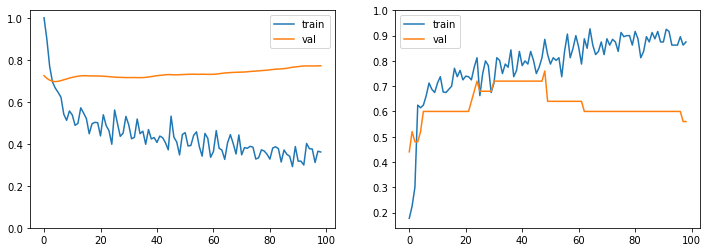

In [14]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 3. Looking Away

146 of 146
159 of 159
(243, 160, 160, 3) float32
(243,) int32
(62, 160, 160, 3) float32
(62,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 24s 244ms/step - loss: 98.4951 - val_loss: 98.2134
Epoch 2/100
100/100 [==============================] - 23s 230ms/step - loss: 93.7403 - val_loss: 91.9442
Epoch 3/100
100/100 [==============================] - 23s 230ms/step - loss: 88.4088 - val_loss: 91.3229
Epoch 4/100
100/100 [==============================] - 23s 231ms/step - loss: 81.3709 - val_loss: 91.7147
Epoch 5/100
100/100 [==============================] - 23s 230ms/step - loss: 76.6908 - val_loss: 93.0734
Epoch 6/100
100/100 [==============================] - 23s 230ms/step - loss: 71.8214 - val_loss: 94.3983
Epoch 7/100
100/100 [==============================] - 23s 230ms/step - loss: 66.8990 - val_loss: 94.9668
Epoch 8/100
100/100 [==============================] - 23s 230ms/step - loss: 61.2822 - val_loss: 93.1203
Epoch 9/100
100/100 [==============================] - 23s 230ms/step - loss: 55.1814 - val_loss: 94.4120
Epoch 10/100
100/100 [========================

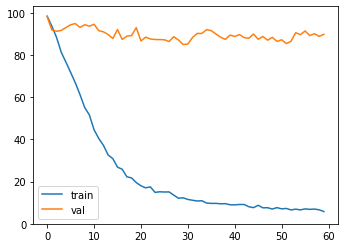

In [15]:
REQ_NAME = 'looking_away'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
7/7 [==============================] - 2s 252ms/step - loss: 0.7711 - accuracy: 0.6161 - precision: 0.6648 - recall: 0.4961 - f1: 0.5563 - specificity: 0.7380 - negative_predictive_value: 0.5922 - matthews_correlation_coefficient: 0.2450 - equal_error_rate: 0.4151 - val_loss: 0.6666 - val_accuracy: 0.5781 - val_precision: 0.8333 - val_recall: 0.1875 - val_f1: 0.3053 - val_specificity: 0.9688 - val_negative_predictive_value: 0.5443 - val_matthews_correlation_coefficient: 0.2426 - val_equal_error_rate: 0.4062

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.24259, saving model to ../../models/siamese_networks/looking_away_2020_06_08-00_22_35.h5
Epoch 2/100
7/7 [==============================] - 1s 125ms/step - loss: 0.6407 - accuracy: 0.7297 - precision: 0.8543 - recall: 0.5801 - f1: 0.6860 - specificity: 0.8912 - negative_predictive_value: 0.6680 - matthews_correlation_coefficient: 0.4957 - equal_error_rate: 0.2724 - val_loss: 0.7188 - val_accuracy:

7/7 [==============================] - 1s 101ms/step - loss: 0.3947 - accuracy: 0.7973 - precision: 0.9443 - recall: 0.6163 - f1: 0.7429 - specificity: 0.9610 - negative_predictive_value: 0.7314 - matthews_correlation_coefficient: 0.6238 - equal_error_rate: 0.1321 - val_loss: 1.1163 - val_accuracy: 0.5000 - val_precision: 0.3333 - val_recall: 0.0625 - val_f1: 0.1053 - val_specificity: 0.9375 - val_negative_predictive_value: 0.5006 - val_matthews_correlation_coefficient: -0.0362 - val_equal_error_rate: 0.4375

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.24259
Epoch 15/100
7/7 [==============================] - 1s 100ms/step - loss: 0.3881 - accuracy: 0.8333 - precision: 0.9649 - recall: 0.7075 - f1: 0.8116 - specificity: 0.9746 - negative_predictive_value: 0.7552 - matthews_correlation_coefficient: 0.7000 - equal_error_rate: 0.1515 - val_loss: 1.1041 - val_accuracy: 0.5000 - val_precision: 0.3333 - val_recall: 0.0625 - val_f1: 0.1053 - val_specificity: 0.937


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.24259
Epoch 28/100
7/7 [==============================] - 1s 110ms/step - loss: 0.4024 - accuracy: 0.8243 - precision: 0.9134 - recall: 0.7022 - f1: 0.7922 - specificity: 0.9375 - negative_predictive_value: 0.7612 - matthews_correlation_coefficient: 0.6561 - equal_error_rate: 0.1448 - val_loss: 1.0540 - val_accuracy: 0.5156 - val_precision: 0.5833 - val_recall: 0.0938 - val_f1: 0.1608 - val_specificity: 0.9375 - val_negative_predictive_value: 0.5086 - val_matthews_correlation_coefficient: 0.0536 - val_equal_error_rate: 0.4219

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.24259
Epoch 29/100
7/7 [==============================] - 1s 111ms/step - loss: 0.3861 - accuracy: 0.8423 - precision: 0.9348 - recall: 0.7340 - f1: 0.8062 - specificity: 0.9441 - negative_predictive_value: 0.7947 - matthews_correlation_coefficient: 0.7002 - equal_error_rate: 0.1137 - val_loss: 1.0575 - val_accuracy: 0

7/7 [==============================] - 1s 108ms/step - loss: 0.3641 - accuracy: 0.8527 - precision: 0.9731 - recall: 0.7325 - f1: 0.8279 - specificity: 0.9661 - negative_predictive_value: 0.7809 - matthews_correlation_coefficient: 0.7244 - equal_error_rate: 0.1217 - val_loss: 0.9321 - val_accuracy: 0.5156 - val_precision: 0.5833 - val_recall: 0.0938 - val_f1: 0.1608 - val_specificity: 0.9375 - val_negative_predictive_value: 0.5086 - val_matthews_correlation_coefficient: 0.0536 - val_equal_error_rate: 0.4375

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.24259
Epoch 42/100
7/7 [==============================] - 1s 107ms/step - loss: 0.4013 - accuracy: 0.8333 - precision: 0.9602 - recall: 0.7061 - f1: 0.8105 - specificity: 0.9586 - negative_predictive_value: 0.7536 - matthews_correlation_coefficient: 0.6875 - equal_error_rate: 0.1447 - val_loss: 0.9305 - val_accuracy: 0.5156 - val_precision: 0.5833 - val_recall: 0.0938 - val_f1: 0.1608 - val_specificity: 0.9375

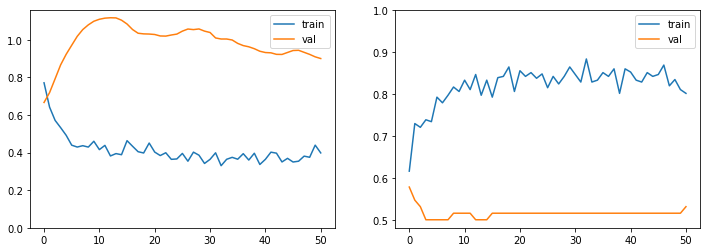

In [16]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)


list_model_files.append(file_model)

#### ~~4. Ink Marked/Creased~~

#### 5. Unnatural Skin Tone 

63 of 63
51 of 51
(90, 160, 160, 3) float32
(90,) int32
(24, 160, 160, 3) float32
(24,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 17s 175ms/step - loss: 91.1213 - val_loss: 110.2241
Epoch 2/100
100/100 [==============================] - 16s 162ms/step - loss: 52.3048 - val_loss: 115.7894
Epoch 3/100
100/100 [==============================] - 16s 163ms/step - loss: 36.6806 - val_loss: 130.9788
Epoch 4/100
100/100 [==============================] - 16s 163ms/step - loss: 14.1787 - val_loss: 148.8535
Epoch 5/100
100/100 [==============================] - 16s 163ms/step - loss: 6.4887 - val_loss: 152.2018
Epoch 6/100
100/100 [==============================] - 16s 163ms/step - loss: 3.2534 - val_loss: 151.9386
Epoch 7/100
100/100 [==============================] - 16s 163ms/step - loss: 2.4509 - val_loss: 151.3380
Epoch 8/100
100/100 [==============================] - 16s 163ms/step - loss: 1.5505 - val_loss: 153.1923
Epoch 9/100
100/100 [==============================] - 16s 163ms/step - loss: 1.6370 - val_loss: 151.7254
Epoch 10/100
100/100 [====================

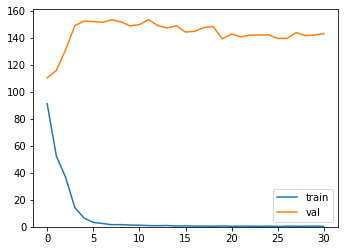

In [17]:
REQ_NAME = 'unnatural_skin_tone'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 2s 552ms/step - loss: 0.6933 - accuracy: 0.5417 - precision: 0.5200 - recall: 0.8132 - f1: 0.6319 - specificity: 0.2817 - negative_predictive_value: 0.6206 - matthews_correlation_coefficient: 0.1152 - equal_error_rate: 0.3956 - val_loss: 0.6866 - val_accuracy: 0.4583 - val_precision: 0.4783 - val_recall: 0.9167 - val_f1: 0.6286 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: -0.2085 - val_equal_error_rate: 0.4583

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.20851, saving model to ../../models/siamese_networks/unnatural_skin_tone_2020_06_08-00_32_06.h5
Epoch 2/100
3/3 [==============================] - 1s 210ms/step - loss: 0.6985 - accuracy: 0.5000 - precision: 0.6410 - recall: 0.7762 - f1: 0.6622 - specificity: 0.4651 - negative_predictive_value: 0.5556 - matthews_correlation_coefficient: 0.2164 - equal_error_rate: 0.3901 - val_loss: 0.690

3/3 [==============================] - 0s 163ms/step - loss: 0.6501 - accuracy: 0.5000 - precision: 0.5537 - recall: 0.7937 - f1: 0.6511 - specificity: 0.2102 - negative_predictive_value: 0.3670 - matthews_correlation_coefficient: 0.0039 - equal_error_rate: 0.3382 - val_loss: 0.6507 - val_accuracy: 0.5833 - val_precision: 0.5500 - val_recall: 0.9167 - val_f1: 0.6875 - val_specificity: 0.2500 - val_negative_predictive_value: 0.7500 - val_matthews_correlation_coefficient: 0.2236 - val_equal_error_rate: 0.4583

Epoch 00014: val_matthews_correlation_coefficient improved from 0.12599 to 0.22361, saving model to ../../models/siamese_networks/unnatural_skin_tone_2020_06_08-00_32_06.h5
Epoch 15/100
3/3 [==============================] - 0s 157ms/step - loss: 0.6545 - accuracy: 0.4559 - precision: 0.6276 - recall: 0.7143 - f1: 0.6652 - specificity: 0.5053 - negative_predictive_value: 0.5718 - matthews_correlation_coefficient: 0.2098 - equal_error_rate: 0.3677 - val_loss: 0.6487 - val_accuracy: 

3/3 [==============================] - 1s 167ms/step - loss: 0.7363 - accuracy: 0.4706 - precision: 0.4912 - recall: 0.4921 - f1: 0.4830 - specificity: 0.2619 - negative_predictive_value: 0.3168 - matthews_correlation_coefficient: -0.2170 - equal_error_rate: 0.4868 - val_loss: 0.6580 - val_accuracy: 0.5833 - val_precision: 0.5500 - val_recall: 0.9167 - val_f1: 0.6875 - val_specificity: 0.2500 - val_negative_predictive_value: 0.7500 - val_matthews_correlation_coefficient: 0.2236 - val_equal_error_rate: 0.2917

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.22361
Epoch 28/100
3/3 [==============================] - 0s 154ms/step - loss: 0.6354 - accuracy: 0.5735 - precision: 0.7111 - recall: 0.6222 - f1: 0.6550 - specificity: 0.6723 - negative_predictive_value: 0.5294 - matthews_correlation_coefficient: 0.2655 - equal_error_rate: 0.3567 - val_loss: 0.6573 - val_accuracy: 0.6250 - val_precision: 0.5789 - val_recall: 0.9167 - val_f1: 0.7097 - val_specificity: 0.333

3/3 [==============================] - 0s 158ms/step - loss: 0.6296 - accuracy: 0.5588 - precision: 0.6957 - recall: 0.7296 - f1: 0.6892 - specificity: 0.5420 - negative_predictive_value: 0.5250 - matthews_correlation_coefficient: 0.2442 - equal_error_rate: 0.3570 - val_loss: 0.6486 - val_accuracy: 0.6667 - val_precision: 0.6667 - val_recall: 0.6667 - val_f1: 0.6667 - val_specificity: 0.6667 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.3333 - val_equal_error_rate: 0.3750

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.41812
Epoch 41/100
3/3 [==============================] - 1s 167ms/step - loss: 0.6602 - accuracy: 0.6042 - precision: 0.5741 - recall: 0.7672 - f1: 0.6519 - specificity: 0.4542 - negative_predictive_value: 0.6764 - matthews_correlation_coefficient: 0.2352 - equal_error_rate: 0.3861 - val_loss: 0.6479 - val_accuracy: 0.6667 - val_precision: 0.6667 - val_recall: 0.6667 - val_f1: 0.6667 - val_specificity: 0.6667


Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.41812
Epoch 54/100
3/3 [==============================] - 0s 147ms/step - loss: 0.6476 - accuracy: 0.5882 - precision: 0.6961 - recall: 0.5492 - f1: 0.5635 - specificity: 0.6939 - negative_predictive_value: 0.5460 - matthews_correlation_coefficient: 0.2426 - equal_error_rate: 0.2869 - val_loss: 0.6420 - val_accuracy: 0.6667 - val_precision: 0.7000 - val_recall: 0.5833 - val_f1: 0.6364 - val_specificity: 0.7500 - val_negative_predictive_value: 0.6429 - val_matthews_correlation_coefficient: 0.3381 - val_equal_error_rate: 0.3750

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.41812
Epoch 55/100
3/3 [==============================] - 0s 157ms/step - loss: 0.6096 - accuracy: 0.6618 - precision: 0.7430 - recall: 0.8360 - f1: 0.7836 - specificity: 0.6852 - negative_predictive_value: 0.7842 - matthews_correlation_coefficient: 0.5241 - equal_error_rate: 0.2950 - val_loss: 0.6442 - val_accuracy: 0

3/3 [==============================] - 0s 148ms/step - loss: 0.5689 - accuracy: 0.6618 - precision: 0.7455 - recall: 0.7672 - f1: 0.7353 - specificity: 0.6614 - negative_predictive_value: 0.6444 - matthews_correlation_coefficient: 0.4070 - equal_error_rate: 0.2434 - val_loss: 0.6342 - val_accuracy: 0.6667 - val_precision: 0.7000 - val_recall: 0.5833 - val_f1: 0.6364 - val_specificity: 0.7500 - val_negative_predictive_value: 0.6429 - val_matthews_correlation_coefficient: 0.3381 - val_equal_error_rate: 0.2917

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.50000
Epoch 68/100
3/3 [==============================] - 0s 146ms/step - loss: 0.6653 - accuracy: 0.5735 - precision: 0.7121 - recall: 0.6185 - f1: 0.5995 - specificity: 0.5896 - negative_predictive_value: 0.5111 - matthews_correlation_coefficient: 0.2154 - equal_error_rate: 0.3051 - val_loss: 0.6318 - val_accuracy: 0.7083 - val_precision: 0.7778 - val_recall: 0.5833 - val_f1: 0.6667 - val_specificity: 0.8333

3/3 [==============================] - 0s 148ms/step - loss: 0.6077 - accuracy: 0.7647 - precision: 0.7313 - recall: 0.7852 - f1: 0.7556 - specificity: 0.4650 - negative_predictive_value: 0.5412 - matthews_correlation_coefficient: 0.2610 - equal_error_rate: 0.1911 - val_loss: 0.6330 - val_accuracy: 0.7083 - val_precision: 0.7778 - val_recall: 0.5833 - val_f1: 0.6667 - val_specificity: 0.8333 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.4303 - val_equal_error_rate: 0.2917

Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.53033
Epoch 81/100
3/3 [==============================] - 1s 167ms/step - loss: 0.6514 - accuracy: 0.5521 - precision: 0.5345 - recall: 0.6884 - f1: 0.5945 - specificity: 0.4325 - negative_predictive_value: 0.6107 - matthews_correlation_coefficient: 0.1322 - equal_error_rate: 0.3445 - val_loss: 0.6317 - val_accuracy: 0.7083 - val_precision: 0.7778 - val_recall: 0.5833 - val_f1: 0.6667 - val_specificity: 0.8333


Epoch 00093: val_matthews_correlation_coefficient did not improve from 0.53033
Epoch 94/100
3/3 [==============================] - 0s 142ms/step - loss: 0.6456 - accuracy: 0.5735 - precision: 0.6783 - recall: 0.7270 - f1: 0.6754 - specificity: 0.6024 - negative_predictive_value: 0.6019 - matthews_correlation_coefficient: 0.3027 - equal_error_rate: 0.3175 - val_loss: 0.6304 - val_accuracy: 0.6667 - val_precision: 0.7500 - val_recall: 0.5000 - val_f1: 0.6000 - val_specificity: 0.8333 - val_negative_predictive_value: 0.6250 - val_matthews_correlation_coefficient: 0.3536 - val_equal_error_rate: 0.2917

Epoch 00094: val_matthews_correlation_coefficient did not improve from 0.53033
Epoch 95/100
3/3 [==============================] - 0s 150ms/step - loss: 0.6239 - accuracy: 0.6324 - precision: 0.6294 - recall: 0.7487 - f1: 0.6789 - specificity: 0.3333 - negative_predictive_value: 0.4672 - matthews_correlation_coefficient: 0.0891 - equal_error_rate: 0.2950 - val_loss: 0.6318 - val_accuracy: 0

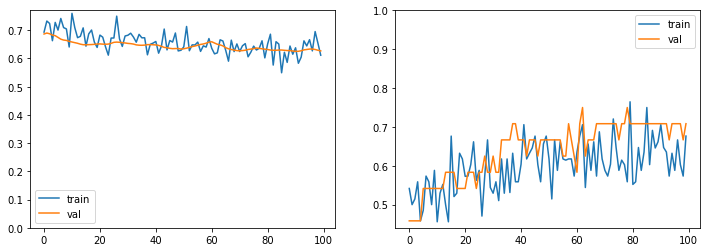

In [18]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 6. Too Dark/Light 

78 of 78
74 of 74
(121, 160, 160, 3) float32
(121,) int32
(31, 160, 160, 3) float32
(31,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 19s 190ms/step - loss: 83.1094 - val_loss: 59.3662
Epoch 2/100
100/100 [==============================] - 18s 177ms/step - loss: 51.1144 - val_loss: 51.3113
Epoch 3/100
100/100 [==============================] - 18s 177ms/step - loss: 31.9867 - val_loss: 45.2981
Epoch 4/100
100/100 [==============================] - 18s 177ms/step - loss: 17.5324 - val_loss: 44.7987
Epoch 5/100
100/100 [==============================] - 18s 177ms/step - loss: 7.6202 - val_loss: 44.2781
Epoch 6/100
100/100 [==============================] - 18s 177ms/step - loss: 3.5903 - val_loss: 43.2626
Epoch 7/100
100/100 [==============================] - 18s 177ms/step - loss: 2.8992 - val_loss: 43.1349
Epoch 8/100
100/100 [==============================] - 18s 177ms/step - loss: 2.2952 - val_loss: 43.4830
Epoch 9/100
100/100 [==============================] - 18s 177ms/step - loss: 1.5193 - val_loss: 42.5739
Epoch 10/100
100/100 [=============================

100/100 [==============================] - 18s 177ms/step - loss: 0.2176 - val_loss: 36.8169
Epoch 79/100
100/100 [==============================] - 18s 177ms/step - loss: 0.1347 - val_loss: 35.5367
Epoch 80/100
100/100 [==============================] - 18s 177ms/step - loss: 0.1600 - val_loss: 32.1720
Epoch 81/100
100/100 [==============================] - 18s 177ms/step - loss: 0.1608 - val_loss: 33.3028
Epoch 82/100
100/100 [==============================] - 18s 177ms/step - loss: 0.1234 - val_loss: 37.3647
Epoch 83/100
100/100 [==============================] - 18s 177ms/step - loss: 0.1138 - val_loss: 38.0342
Epoch 84/100
100/100 [==============================] - 18s 177ms/step - loss: 0.0688 - val_loss: 35.3479
Epoch 85/100
100/100 [==============================] - 18s 177ms/step - loss: 0.1270 - val_loss: 37.2981
Epoch 86/100
100/100 [==============================] - 18s 177ms/step - loss: 0.1804 - val_loss: 36.5925
Epoch 87/100
100/100 [==============================] - 18s

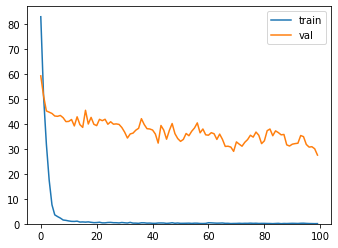

In [19]:
REQ_NAME = 'too_dark_light'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 2s 682ms/step - loss: 1.1888 - accuracy: 0.2292 - precision: 0.3024 - recall: 0.4717 - f1: 0.3602 - specificity: 0.0167 - negative_predictive_value: 0.0667 - matthews_correlation_coefficient: -0.5650 - equal_error_rate: 0.7708 - val_loss: 0.9658 - val_accuracy: 0.2581 - val_precision: 0.3000 - val_recall: 0.4000 - val_f1: 0.3429 - val_specificity: 0.1250 - val_negative_predictive_value: 0.1818 - val_matthews_correlation_coefficient: -0.4961 - val_equal_error_rate: 0.7104

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.49612, saving model to ../../models/siamese_networks/too_dark_light_2020_06_08-01_03_04.h5
Epoch 2/100
3/3 [==============================] - 1s 293ms/step - loss: 1.0899 - accuracy: 0.2065 - precision: 0.2714 - recall: 0.3667 - f1: 0.3024 - specificity: 0.0733 - negative_predictive_value: 0.0754 - matthews_correlation_coefficient: -0.6018 - equal_error_rate: 0.7536 - val_loss: 0.9671 - val_acc


Epoch 00013: val_matthews_correlation_coefficient did not improve from -0.24901
Epoch 14/100
3/3 [==============================] - 0s 157ms/step - loss: 0.5068 - accuracy: 0.6848 - precision: 0.7586 - recall: 0.6241 - f1: 0.6726 - specificity: 0.7051 - negative_predictive_value: 0.6444 - matthews_correlation_coefficient: 0.3633 - equal_error_rate: 0.2506 - val_loss: 1.0225 - val_accuracy: 0.3548 - val_precision: 0.3913 - val_recall: 0.6000 - val_f1: 0.4737 - val_specificity: 0.1250 - val_negative_predictive_value: 0.2500 - val_matthews_correlation_coefficient: -0.3141 - val_equal_error_rate: 0.6458

Epoch 00014: val_matthews_correlation_coefficient did not improve from -0.24901
Epoch 15/100
3/3 [==============================] - 1s 168ms/step - loss: 0.4536 - accuracy: 0.8587 - precision: 0.8797 - recall: 0.8745 - f1: 0.8701 - specificity: 0.8331 - negative_predictive_value: 0.8745 - matthews_correlation_coefficient: 0.7297 - equal_error_rate: 0.1687 - val_loss: 1.0151 - val_accuracy

3/3 [==============================] - 0s 146ms/step - loss: 0.3545 - accuracy: 0.8587 - precision: 0.9474 - recall: 0.7983 - f1: 0.8604 - specificity: 0.9286 - negative_predictive_value: 0.8029 - matthews_correlation_coefficient: 0.7384 - equal_error_rate: 0.1032 - val_loss: 0.8255 - val_accuracy: 0.4516 - val_precision: 0.4545 - val_recall: 0.6667 - val_f1: 0.5405 - val_specificity: 0.2500 - val_negative_predictive_value: 0.4444 - val_matthews_correlation_coefficient: -0.0917 - val_equal_error_rate: 0.4521

Epoch 00027: val_matthews_correlation_coefficient improved from -0.09462 to -0.09175, saving model to ../../models/siamese_networks/too_dark_light_2020_06_08-01_03_04.h5
Epoch 28/100
3/3 [==============================] - 0s 131ms/step - loss: 0.3790 - accuracy: 0.8478 - precision: 1.0000 - recall: 0.6631 - f1: 0.7815 - specificity: 1.0000 - negative_predictive_value: 0.7858 - matthews_correlation_coefficient: 0.7166 - equal_error_rate: 0.1072 - val_loss: 0.8099 - val_accuracy: 0.

3/3 [==============================] - 0s 138ms/step - loss: 0.2673 - accuracy: 0.8804 - precision: 0.9778 - recall: 0.7686 - f1: 0.8536 - specificity: 0.9744 - negative_predictive_value: 0.8355 - matthews_correlation_coefficient: 0.7765 - equal_error_rate: 0.0671 - val_loss: 0.6954 - val_accuracy: 0.5484 - val_precision: 0.5263 - val_recall: 0.6667 - val_f1: 0.5882 - val_specificity: 0.4375 - val_negative_predictive_value: 0.5833 - val_matthews_correlation_coefficient: 0.1069 - val_equal_error_rate: 0.4521

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.10687
Epoch 41/100
3/3 [==============================] - 0s 134ms/step - loss: 0.3548 - accuracy: 0.8542 - precision: 0.9577 - recall: 0.7086 - f1: 0.7905 - specificity: 0.9540 - negative_predictive_value: 0.8157 - matthews_correlation_coefficient: 0.7103 - equal_error_rate: 0.0834 - val_loss: 0.6907 - val_accuracy: 0.5484 - val_precision: 0.5263 - val_recall: 0.6667 - val_f1: 0.5882 - val_specificity: 0.4375

3/3 [==============================] - 0s 130ms/step - loss: 0.2647 - accuracy: 0.9167 - precision: 0.9804 - recall: 0.8404 - f1: 0.9030 - specificity: 0.9762 - negative_predictive_value: 0.8729 - matthews_correlation_coefficient: 0.8342 - equal_error_rate: 0.1056 - val_loss: 0.6470 - val_accuracy: 0.5484 - val_precision: 0.5294 - val_recall: 0.6000 - val_f1: 0.5625 - val_specificity: 0.5000 - val_negative_predictive_value: 0.5714 - val_matthews_correlation_coefficient: 0.1004 - val_equal_error_rate: 0.3875

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.16879
Epoch 54/100
3/3 [==============================] - 0s 146ms/step - loss: 0.2249 - accuracy: 0.9130 - precision: 0.9792 - recall: 0.8333 - f1: 0.8941 - specificity: 0.9762 - negative_predictive_value: 0.8819 - matthews_correlation_coefficient: 0.8338 - equal_error_rate: 0.0749 - val_loss: 0.6433 - val_accuracy: 0.5484 - val_precision: 0.5294 - val_recall: 0.6000 - val_f1: 0.5625 - val_specificity: 0.5000


Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.16879
Epoch 67/100
3/3 [==============================] - 0s 157ms/step - loss: 0.1964 - accuracy: 0.9348 - precision: 0.9815 - recall: 0.9004 - f1: 0.9377 - specificity: 0.9762 - negative_predictive_value: 0.8968 - matthews_correlation_coefficient: 0.8775 - equal_error_rate: 0.0511 - val_loss: 0.6125 - val_accuracy: 0.5806 - val_precision: 0.5625 - val_recall: 0.6000 - val_f1: 0.5806 - val_specificity: 0.5625 - val_negative_predictive_value: 0.6000 - val_matthews_correlation_coefficient: 0.1625 - val_equal_error_rate: 0.3875

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.16879
Epoch 68/100
3/3 [==============================] - 0s 134ms/step - loss: 0.2510 - accuracy: 0.8913 - precision: 0.9792 - recall: 0.7775 - f1: 0.8582 - specificity: 0.9778 - negative_predictive_value: 0.8472 - matthews_correlation_coefficient: 0.7880 - equal_error_rate: 0.0641 - val_loss: 0.6118 - val_accuracy: 0

3/3 [==============================] - 0s 138ms/step - loss: 0.1996 - accuracy: 0.9348 - precision: 1.0000 - recall: 0.8552 - f1: 0.9201 - specificity: 1.0000 - negative_predictive_value: 0.8935 - matthews_correlation_coefficient: 0.8736 - equal_error_rate: 0.0641 - val_loss: 0.5928 - val_accuracy: 0.6129 - val_precision: 0.5882 - val_recall: 0.6667 - val_f1: 0.6250 - val_specificity: 0.5625 - val_negative_predictive_value: 0.6429 - val_matthews_correlation_coefficient: 0.2301 - val_equal_error_rate: 0.3229

Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.23013
Epoch 81/100
3/3 [==============================] - 0s 115ms/step - loss: 0.2489 - accuracy: 0.8750 - precision: 1.0000 - recall: 0.7353 - f1: 0.8456 - specificity: 1.0000 - negative_predictive_value: 0.8023 - matthews_correlation_coefficient: 0.7671 - equal_error_rate: 0.0635 - val_loss: 0.5936 - val_accuracy: 0.6129 - val_precision: 0.5882 - val_recall: 0.6667 - val_f1: 0.6250 - val_specificity: 0.5625

3/3 [==============================] - 0s 117ms/step - loss: 0.2614 - accuracy: 0.9062 - precision: 1.0000 - recall: 0.8012 - f1: 0.8883 - specificity: 1.0000 - negative_predictive_value: 0.8447 - matthews_correlation_coefficient: 0.8222 - equal_error_rate: 0.0635 - val_loss: 0.5829 - val_accuracy: 0.6774 - val_precision: 0.6667 - val_recall: 0.6667 - val_f1: 0.6667 - val_specificity: 0.6875 - val_negative_predictive_value: 0.6875 - val_matthews_correlation_coefficient: 0.3542 - val_equal_error_rate: 0.3229

Epoch 00093: val_matthews_correlation_coefficient did not improve from 0.35417
Epoch 94/100
3/3 [==============================] - 0s 146ms/step - loss: 0.1716 - accuracy: 0.9457 - precision: 0.9792 - recall: 0.8981 - f1: 0.9321 - specificity: 0.9744 - negative_predictive_value: 0.9343 - matthews_correlation_coefficient: 0.8922 - equal_error_rate: 0.0665 - val_loss: 0.5836 - val_accuracy: 0.6774 - val_precision: 0.6667 - val_recall: 0.6667 - val_f1: 0.6667 - val_specificity: 0.6875

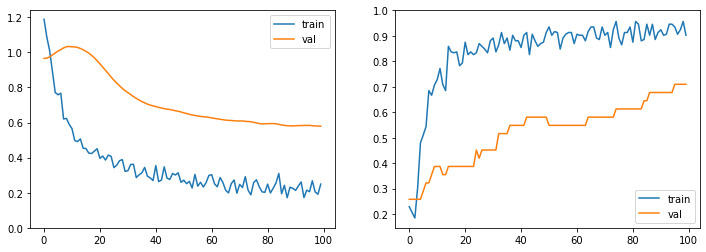

In [20]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 7. Washed Out

79 of 79
43 of 43
(97, 160, 160, 3) float32
(97,) int32
(25, 160, 160, 3) float32
(25,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 17s 171ms/step - loss: 95.4240 - val_loss: 78.0040
Epoch 2/100
100/100 [==============================] - 16s 156ms/step - loss: 73.7165 - val_loss: 68.6357
Epoch 3/100
100/100 [==============================] - 16s 156ms/step - loss: 55.5324 - val_loss: 28.5343
Epoch 4/100
100/100 [==============================] - 16s 156ms/step - loss: 35.4991 - val_loss: 13.4249
Epoch 5/100
100/100 [==============================] - 16s 156ms/step - loss: 16.9348 - val_loss: 11.1119
Epoch 6/100
100/100 [==============================] - 16s 156ms/step - loss: 8.6260 - val_loss: 11.2145
Epoch 7/100
100/100 [==============================] - 16s 156ms/step - loss: 5.4041 - val_loss: 11.0585
Epoch 8/100
100/100 [==============================] - 16s 157ms/step - loss: 3.5603 - val_loss: 11.0595
Epoch 9/100
100/100 [==============================] - 16s 156ms/step - loss: 2.7808 - val_loss: 11.0997
Epoch 10/100
100/100 [============================

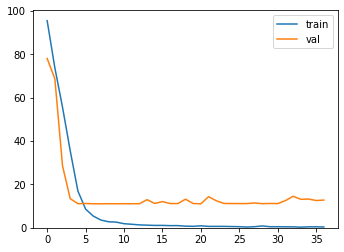

In [21]:
REQ_NAME = 'washed_out'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 2s 507ms/step - loss: 0.5748 - accuracy: 0.7292 - precision: 0.9000 - recall: 0.5167 - f1: 0.6426 - specificity: 0.9339 - negative_predictive_value: 0.6616 - matthews_correlation_coefficient: 0.5005 - equal_error_rate: 0.1874 - val_loss: 0.4659 - val_accuracy: 0.8000 - val_precision: 1.0000 - val_recall: 0.6154 - val_f1: 0.7619 - val_specificity: 1.0000 - val_negative_predictive_value: 0.7059 - val_matthews_correlation_coefficient: 0.6591 - val_equal_error_rate: 0.1186

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.65908, saving model to ../../models/siamese_networks/washed_out_2020_06_08-01_14_10.h5
Epoch 2/100
3/3 [==============================] - 0s 133ms/step - loss: 0.5329 - accuracy: 0.7340 - precision: 0.9630 - recall: 0.4748 - f1: 0.6280 - specificity: 0.9815 - negative_predictive_value: 0.6706 - matthews_correlation_coefficient: 0.5367 - equal_error_rate: 0.2030 - val_loss: 0.4361 - val_accuracy: 0

3/3 [==============================] - 0s 116ms/step - loss: 0.3163 - accuracy: 0.8404 - precision: 1.0000 - recall: 0.6807 - f1: 0.8000 - specificity: 1.0000 - negative_predictive_value: 0.7747 - matthews_correlation_coefficient: 0.7255 - equal_error_rate: 0.0440 - val_loss: 0.3847 - val_accuracy: 0.8800 - val_precision: 1.0000 - val_recall: 0.7692 - val_f1: 0.8696 - val_specificity: 1.0000 - val_negative_predictive_value: 0.8000 - val_matthews_correlation_coefficient: 0.7845 - val_equal_error_rate: 0.0385

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.78446
Epoch 15/100
3/3 [==============================] - 0s 116ms/step - loss: 0.3052 - accuracy: 0.8723 - precision: 0.9762 - recall: 0.7698 - f1: 0.8540 - specificity: 0.9792 - negative_predictive_value: 0.8186 - matthews_correlation_coefficient: 0.7712 - equal_error_rate: 0.0739 - val_loss: 0.3868 - val_accuracy: 0.8800 - val_precision: 1.0000 - val_recall: 0.7692 - val_f1: 0.8696 - val_specificity: 1.0000


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.78446
Epoch 28/100
3/3 [==============================] - 0s 102ms/step - loss: 0.2808 - accuracy: 0.8830 - precision: 0.9778 - recall: 0.8041 - f1: 0.8797 - specificity: 0.9762 - negative_predictive_value: 0.8186 - matthews_correlation_coefficient: 0.7882 - equal_error_rate: 0.0730 - val_loss: 0.3894 - val_accuracy: 0.8400 - val_precision: 1.0000 - val_recall: 0.6923 - val_f1: 0.8182 - val_specificity: 1.0000 - val_negative_predictive_value: 0.7500 - val_matthews_correlation_coefficient: 0.7206 - val_equal_error_rate: 0.0385

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.78446
Epoch 29/100
3/3 [==============================] - 0s 89ms/step - loss: 0.2918 - accuracy: 0.8958 - precision: 1.0000 - recall: 0.7988 - f1: 0.8866 - specificity: 1.0000 - negative_predictive_value: 0.8245 - matthews_correlation_coefficient: 0.8114 - equal_error_rate: 0.0310 - val_loss: 0.3881 - val_accuracy: 0.

3/3 [==============================] - 0s 96ms/step - loss: 0.2303 - accuracy: 0.9375 - precision: 1.0000 - recall: 0.8792 - f1: 0.9337 - specificity: 1.0000 - negative_predictive_value: 0.8901 - matthews_correlation_coefficient: 0.8846 - equal_error_rate: 0.0402 - val_loss: 0.3713 - val_accuracy: 0.8800 - val_precision: 1.0000 - val_recall: 0.7692 - val_f1: 0.8696 - val_specificity: 1.0000 - val_negative_predictive_value: 0.8000 - val_matthews_correlation_coefficient: 0.7845 - val_equal_error_rate: 0.0385

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.78446
Epoch 42/100
3/3 [==============================] - 0s 102ms/step - loss: 0.2515 - accuracy: 0.9255 - precision: 1.0000 - recall: 0.8501 - f1: 0.9156 - specificity: 1.0000 - negative_predictive_value: 0.8822 - matthews_correlation_coefficient: 0.8659 - equal_error_rate: 0.0429 - val_loss: 0.3696 - val_accuracy: 0.8800 - val_precision: 1.0000 - val_recall: 0.7692 - val_f1: 0.8696 - val_specificity: 1.0000 

3/3 [==============================] - 0s 119ms/step - loss: 0.1997 - accuracy: 0.9362 - precision: 1.0000 - recall: 0.8782 - f1: 0.9302 - specificity: 1.0000 - negative_predictive_value: 0.8991 - matthews_correlation_coefficient: 0.8885 - equal_error_rate: 0.0545 - val_loss: 0.3471 - val_accuracy: 0.9200 - val_precision: 1.0000 - val_recall: 0.8462 - val_f1: 0.9167 - val_specificity: 1.0000 - val_negative_predictive_value: 0.8571 - val_matthews_correlation_coefficient: 0.8516 - val_equal_error_rate: 0.0385

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.85163
Epoch 55/100
3/3 [==============================] - 0s 116ms/step - loss: 0.1850 - accuracy: 0.9468 - precision: 0.9744 - recall: 0.9101 - f1: 0.9411 - specificity: 0.9815 - negative_predictive_value: 0.9231 - matthews_correlation_coefficient: 0.8945 - equal_error_rate: 0.0423 - val_loss: 0.3459 - val_accuracy: 0.9200 - val_precision: 1.0000 - val_recall: 0.8462 - val_f1: 0.9167 - val_specificity: 1.0000


Epoch 00067: val_matthews_correlation_coefficient improved from 0.85163 to 0.92308, saving model to ../../models/siamese_networks/washed_out_2020_06_08-01_14_10.h5
Epoch 68/100
3/3 [==============================] - 0s 114ms/step - loss: 0.1712 - accuracy: 0.9681 - precision: 1.0000 - recall: 0.9423 - f1: 0.9696 - specificity: 1.0000 - negative_predictive_value: 0.9386 - matthews_correlation_coefficient: 0.9404 - equal_error_rate: 0.0310 - val_loss: 0.3230 - val_accuracy: 0.9600 - val_precision: 1.0000 - val_recall: 0.9231 - val_f1: 0.9600 - val_specificity: 1.0000 - val_negative_predictive_value: 0.9231 - val_matthews_correlation_coefficient: 0.9231 - val_equal_error_rate: 0.0385

Epoch 00068: val_matthews_correlation_coefficient did not improve from 0.92308
Epoch 69/100
3/3 [==============================] - 0s 115ms/step - loss: 0.1973 - accuracy: 0.9271 - precision: 1.0000 - recall: 0.8565 - f1: 0.9225 - specificity: 1.0000 - negative_predictive_value: 0.8694 - matthews_correlatio

3/3 [==============================] - 0s 126ms/step - loss: 0.1575 - accuracy: 0.9792 - precision: 1.0000 - recall: 0.9608 - f1: 0.9792 - specificity: 1.0000 - negative_predictive_value: 0.9608 - matthews_correlation_coefficient: 0.9608 - equal_error_rate: 0.0310 - val_loss: 0.3163 - val_accuracy: 0.9600 - val_precision: 1.0000 - val_recall: 0.9231 - val_f1: 0.9600 - val_specificity: 1.0000 - val_negative_predictive_value: 0.9231 - val_matthews_correlation_coefficient: 0.9231 - val_equal_error_rate: 0.0385

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.92308
Epoch 82/100
3/3 [==============================] - 0s 102ms/step - loss: 0.1842 - accuracy: 0.9255 - precision: 1.0000 - recall: 0.8501 - f1: 0.9176 - specificity: 1.0000 - negative_predictive_value: 0.8769 - matthews_correlation_coefficient: 0.8634 - equal_error_rate: 0.0336 - val_loss: 0.3157 - val_accuracy: 0.9600 - val_precision: 1.0000 - val_recall: 0.9231 - val_f1: 0.9600 - val_specificity: 1.0000


Epoch 00094: val_matthews_correlation_coefficient did not improve from 0.92308
Epoch 95/100
3/3 [==============================] - 0s 133ms/step - loss: 0.1410 - accuracy: 0.9468 - precision: 0.9804 - recall: 0.9153 - f1: 0.9458 - specificity: 0.9762 - negative_predictive_value: 0.9222 - matthews_correlation_coefficient: 0.8970 - equal_error_rate: 0.0542 - val_loss: 0.2977 - val_accuracy: 0.9600 - val_precision: 1.0000 - val_recall: 0.9231 - val_f1: 0.9600 - val_specificity: 1.0000 - val_negative_predictive_value: 0.9231 - val_matthews_correlation_coefficient: 0.9231 - val_equal_error_rate: 0.0385

Epoch 00095: val_matthews_correlation_coefficient did not improve from 0.92308
Epoch 96/100
3/3 [==============================] - 0s 139ms/step - loss: 0.2071 - accuracy: 0.9468 - precision: 0.9825 - recall: 0.9216 - f1: 0.9465 - specificity: 0.9762 - negative_predictive_value: 0.9298 - matthews_correlation_coefficient: 0.9050 - equal_error_rate: 0.0310 - val_loss: 0.2961 - val_accuracy: 0

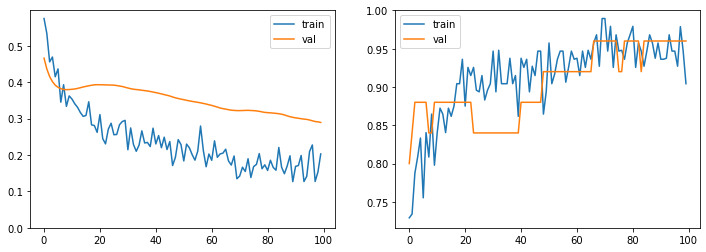

In [22]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 8. Pixelation

79 of 79
105 of 105
(147, 160, 160, 3) float32
(147,) int32
(37, 160, 160, 3) float32
(37,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 19s 193ms/step - loss: 96.9819 - val_loss: 98.5336
Epoch 2/100
100/100 [==============================] - 18s 181ms/step - loss: 87.2956 - val_loss: 87.0410
Epoch 3/100
100/100 [==============================] - 18s 181ms/step - loss: 75.7685 - val_loss: 77.7588
Epoch 4/100
100/100 [==============================] - 18s 181ms/step - loss: 64.4528 - val_loss: 75.5216
Epoch 5/100
100/100 [==============================] - 18s 181ms/step - loss: 58.3870 - val_loss: 68.1608
Epoch 6/100
100/100 [==============================] - 18s 181ms/step - loss: 53.1154 - val_loss: 64.9623
Epoch 7/100
100/100 [==============================] - 18s 181ms/step - loss: 48.3951 - val_loss: 60.9706
Epoch 8/100
100/100 [==============================] - 18s 181ms/step - loss: 45.6150 - val_loss: 65.0161
Epoch 9/100
100/100 [==============================] - 18s 181ms/step - loss: 40.2964 - val_loss: 65.3624
Epoch 10/100
100/100 [========================

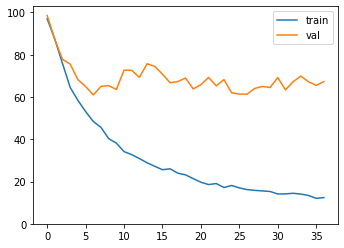

In [23]:
REQ_NAME = 'pixelation'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
5/5 [==============================] - 2s 425ms/step - loss: 0.8858 - accuracy: 0.3500 - precision: 0.4157 - recall: 0.6388 - f1: 0.4944 - specificity: 0.0622 - negative_predictive_value: 0.1722 - matthews_correlation_coefficient: -0.3485 - equal_error_rate: 0.6140 - val_loss: 0.6999 - val_accuracy: 0.5938 - val_precision: 0.5500 - val_recall: 0.7333 - val_f1: 0.6286 - val_specificity: 0.4706 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.2102 - val_equal_error_rate: 0.3765

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.21020, saving model to ../../models/siamese_networks/pixelation_2020_06_08-01_26_46.h5
Epoch 2/100
5/5 [==============================] - 1s 189ms/step - loss: 0.8240 - accuracy: 0.4191 - precision: 0.4160 - recall: 0.5883 - f1: 0.4763 - specificity: 0.2308 - negative_predictive_value: 0.3733 - matthews_correlation_coefficient: -0.1943 - equal_error_rate: 0.5759 - val_loss: 0.6642 - val_accuracy:

5/5 [==============================] - 1s 120ms/step - loss: 0.5728 - accuracy: 0.6985 - precision: 0.9532 - recall: 0.4608 - f1: 0.6128 - specificity: 0.9767 - negative_predictive_value: 0.6568 - matthews_correlation_coefficient: 0.5148 - equal_error_rate: 0.2750 - val_loss: 0.7286 - val_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 0.5333 - val_f1: 0.5333 - val_specificity: 0.5882 - val_negative_predictive_value: 0.5882 - val_matthews_correlation_coefficient: 0.1216 - val_equal_error_rate: 0.4392

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.45124
Epoch 15/100
5/5 [==============================] - 1s 129ms/step - loss: 0.5626 - accuracy: 0.6765 - precision: 0.8540 - recall: 0.5122 - f1: 0.5946 - specificity: 0.9235 - negative_predictive_value: 0.6758 - matthews_correlation_coefficient: 0.4747 - equal_error_rate: 0.3179 - val_loss: 0.7307 - val_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 0.5333 - val_f1: 0.5333 - val_specificity: 0.5882


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.45124
Epoch 28/100
5/5 [==============================] - 1s 136ms/step - loss: 0.5284 - accuracy: 0.7279 - precision: 0.9236 - recall: 0.6267 - f1: 0.7348 - specificity: 0.9470 - negative_predictive_value: 0.6957 - matthews_correlation_coefficient: 0.5958 - equal_error_rate: 0.2805 - val_loss: 0.7489 - val_accuracy: 0.5625 - val_precision: 0.5263 - val_recall: 0.6667 - val_f1: 0.5882 - val_specificity: 0.4706 - val_negative_predictive_value: 0.6154 - val_matthews_correlation_coefficient: 0.1395 - val_equal_error_rate: 0.4392

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.45124
Epoch 29/100
5/5 [==============================] - 1s 126ms/step - loss: 0.5182 - accuracy: 0.7132 - precision: 0.8562 - recall: 0.5769 - f1: 0.6758 - specificity: 0.9291 - negative_predictive_value: 0.7154 - matthews_correlation_coefficient: 0.5369 - equal_error_rate: 0.2757 - val_loss: 0.7525 - val_accuracy: 0

5/5 [==============================] - 1s 127ms/step - loss: 0.5452 - accuracy: 0.7206 - precision: 0.8103 - recall: 0.5888 - f1: 0.6525 - specificity: 0.9037 - negative_predictive_value: 0.7238 - matthews_correlation_coefficient: 0.5101 - equal_error_rate: 0.3112 - val_loss: 0.7772 - val_accuracy: 0.5000 - val_precision: 0.4762 - val_recall: 0.6667 - val_f1: 0.5556 - val_specificity: 0.3529 - val_negative_predictive_value: 0.5455 - val_matthews_correlation_coefficient: 0.0206 - val_equal_error_rate: 0.4392

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.45124
Epoch 42/100
5/5 [==============================] - 1s 118ms/step - loss: 0.4933 - accuracy: 0.7721 - precision: 0.9467 - recall: 0.5266 - f1: 0.6680 - specificity: 0.9722 - negative_predictive_value: 0.7235 - matthews_correlation_coefficient: 0.5735 - equal_error_rate: 0.2832 - val_loss: 0.7786 - val_accuracy: 0.5000 - val_precision: 0.4762 - val_recall: 0.6667 - val_f1: 0.5556 - val_specificity: 0.3529

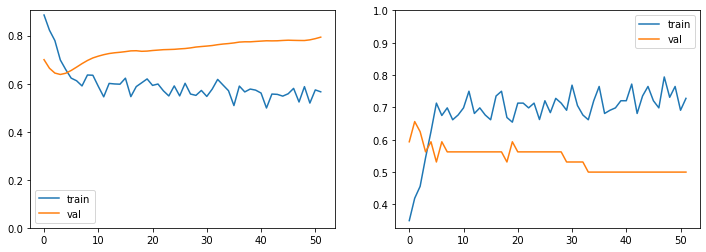

In [24]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 9. Hair Across Eyes 

181 of 181
179 of 179
(287, 160, 160, 3) float32
(287,) int32
(73, 160, 160, 3) float32
(73,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 25s 252ms/step - loss: 91.4873 - val_loss: 97.0063
Epoch 2/100
100/100 [==============================] - 24s 238ms/step - loss: 82.3731 - val_loss: 86.6378
Epoch 3/100
100/100 [==============================] - 24s 238ms/step - loss: 71.7953 - val_loss: 83.9288
Epoch 4/100
100/100 [==============================] - 24s 239ms/step - loss: 63.9276 - val_loss: 87.1351
Epoch 5/100
100/100 [==============================] - 24s 239ms/step - loss: 56.6380 - val_loss: 86.5860
Epoch 6/100
100/100 [==============================] - 24s 239ms/step - loss: 49.4601 - val_loss: 83.9398
Epoch 7/100
100/100 [==============================] - 24s 239ms/step - loss: 43.2947 - val_loss: 98.0642
Epoch 8/100
100/100 [==============================] - 24s 239ms/step - loss: 34.3987 - val_loss: 101.4609
Epoch 9/100
100/100 [==============================] - 24s 239ms/step - loss: 30.6682 - val_loss: 103.0189
Epoch 10/100
100/100 [======================

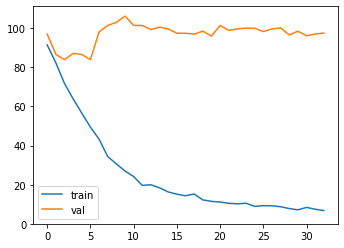

In [25]:
REQ_NAME = 'hair_across_eyes'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
9/9 [==============================] - 3s 312ms/step - loss: 0.8011 - accuracy: 0.3889 - precision: 0.4077 - recall: 0.5194 - f1: 0.4515 - specificity: 0.2606 - negative_predictive_value: 0.3676 - matthews_correlation_coefficient: -0.2223 - equal_error_rate: 0.6089 - val_loss: 0.6913 - val_accuracy: 0.5312 - val_precision: 0.5357 - val_recall: 0.4643 - val_f1: 0.4955 - val_specificity: 0.5992 - val_negative_predictive_value: 0.5278 - val_matthews_correlation_coefficient: 0.0635 - val_equal_error_rate: 0.5000

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.06349, saving model to ../../models/siamese_networks/hair_across_eyes_2020_06_08-01_41_39.h5
Epoch 2/100
9/9 [==============================] - 1s 147ms/step - loss: 0.7637 - accuracy: 0.4583 - precision: 0.4639 - recall: 0.5029 - f1: 0.4754 - specificity: 0.4153 - negative_predictive_value: 0.4550 - matthews_correlation_coefficient: -0.0814 - equal_error_rate: 0.5447 - val_loss: 0.6869 - val_acc

9/9 [==============================] - 1s 143ms/step - loss: 0.7088 - accuracy: 0.5590 - precision: 0.5689 - recall: 0.4592 - f1: 0.5039 - specificity: 0.6539 - negative_predictive_value: 0.5482 - matthews_correlation_coefficient: 0.1151 - equal_error_rate: 0.4479 - val_loss: 0.7155 - val_accuracy: 0.6250 - val_precision: 0.7667 - val_recall: 0.3889 - val_f1: 0.5000 - val_specificity: 0.8810 - val_negative_predictive_value: 0.5909 - val_matthews_correlation_coefficient: 0.3095 - val_equal_error_rate: 0.3591

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.34567
Epoch 15/100
9/9 [==============================] - 1s 137ms/step - loss: 0.6997 - accuracy: 0.5799 - precision: 0.6197 - recall: 0.4451 - f1: 0.5102 - specificity: 0.7225 - negative_predictive_value: 0.5650 - matthews_correlation_coefficient: 0.1758 - equal_error_rate: 0.4482 - val_loss: 0.7150 - val_accuracy: 0.6094 - val_precision: 0.7500 - val_recall: 0.3611 - val_f1: 0.4656 - val_specificity: 0.8810


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.34567
Epoch 28/100
9/9 [==============================] - 1s 141ms/step - loss: 0.6711 - accuracy: 0.5868 - precision: 0.6335 - recall: 0.4688 - f1: 0.5314 - specificity: 0.7125 - negative_predictive_value: 0.5675 - matthews_correlation_coefficient: 0.1908 - equal_error_rate: 0.4170 - val_loss: 0.7070 - val_accuracy: 0.5938 - val_precision: 0.7333 - val_recall: 0.3254 - val_f1: 0.4348 - val_specificity: 0.8810 - val_negative_predictive_value: 0.5668 - val_matthews_correlation_coefficient: 0.2475 - val_equal_error_rate: 0.3274

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.34567
Epoch 29/100
9/9 [==============================] - 1s 137ms/step - loss: 0.6917 - accuracy: 0.6076 - precision: 0.6515 - recall: 0.4530 - f1: 0.5314 - specificity: 0.7519 - negative_predictive_value: 0.5777 - matthews_correlation_coefficient: 0.2164 - equal_error_rate: 0.4619 - val_loss: 0.7046 - val_accuracy: 0

9/9 [==============================] - 1s 137ms/step - loss: 0.6746 - accuracy: 0.6215 - precision: 0.6636 - recall: 0.5025 - f1: 0.5647 - specificity: 0.7464 - negative_predictive_value: 0.6006 - matthews_correlation_coefficient: 0.2563 - equal_error_rate: 0.3482 - val_loss: 0.6996 - val_accuracy: 0.5469 - val_precision: 0.6458 - val_recall: 0.2341 - val_f1: 0.3225 - val_specificity: 0.8810 - val_negative_predictive_value: 0.5366 - val_matthews_correlation_coefficient: 0.1429 - val_equal_error_rate: 0.3274

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.34567
Epoch 42/100
9/9 [==============================] - 1s 142ms/step - loss: 0.6645 - accuracy: 0.6042 - precision: 0.6216 - recall: 0.5004 - f1: 0.5528 - specificity: 0.6999 - negative_predictive_value: 0.5834 - matthews_correlation_coefficient: 0.2025 - equal_error_rate: 0.4138 - val_loss: 0.6978 - val_accuracy: 0.5469 - val_precision: 0.6458 - val_recall: 0.2341 - val_f1: 0.3225 - val_specificity: 0.8810

Restoring model weights from the end of the best epoch

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.34567
Epoch 00054: early stopping

   Final Accuracy:  64.38%
  Final Precision:  82.35%
     Final Recall:  37.84%
  Final F-measure:  51.85%
Final Specificity:  91.67%
        Final NPV:  58.93%
        Final MCC:  34.90%

[[33  3]
 [23 14]]
              precision    recall  f1-score   support

           0       0.59      0.92      0.72        36
           1       0.82      0.38      0.52        37

    accuracy                           0.64        73
   macro avg       0.71      0.65      0.62        73
weighted avg       0.71      0.64      0.62        73



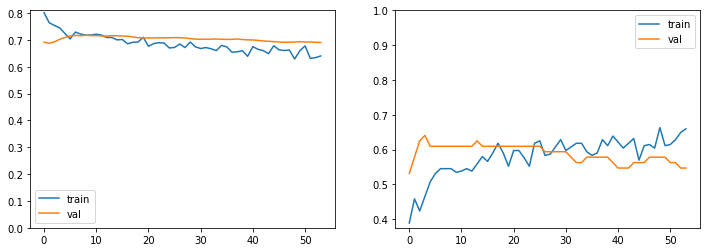

In [26]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 10. Eyes Closed  

123 of 123
77 of 77
(159, 160, 160, 3) float32
(159,) int32
(41, 160, 160, 3) float32
(41,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 20s 197ms/step - loss: 82.9320 - val_loss: 75.6150
Epoch 2/100
100/100 [==============================] - 18s 182ms/step - loss: 62.7944 - val_loss: 62.3361
Epoch 3/100
100/100 [==============================] - 18s 182ms/step - loss: 44.4608 - val_loss: 62.2760
Epoch 4/100
100/100 [==============================] - 18s 182ms/step - loss: 26.8568 - val_loss: 50.7679
Epoch 5/100
100/100 [==============================] - 18s 182ms/step - loss: 16.0604 - val_loss: 58.5726
Epoch 6/100
100/100 [==============================] - 18s 182ms/step - loss: 11.9244 - val_loss: 65.3523
Epoch 7/100
100/100 [==============================] - 18s 182ms/step - loss: 8.3992 - val_loss: 74.9793
Epoch 8/100
100/100 [==============================] - 18s 182ms/step - loss: 5.9239 - val_loss: 71.2586
Epoch 9/100
100/100 [==============================] - 18s 183ms/step - loss: 4.6999 - val_loss: 77.1488
Epoch 10/100
100/100 [===========================

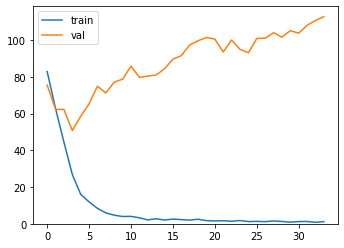

In [27]:
REQ_NAME = 'eyes_closed'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
6/6 [==============================] - 3s 418ms/step - loss: 1.0497 - accuracy: 0.4271 - precision: 0.4572 - recall: 0.6701 - f1: 0.5316 - specificity: 0.2023 - negative_predictive_value: 0.3065 - matthews_correlation_coefficient: -0.1654 - equal_error_rate: 0.6153 - val_loss: 0.8477 - val_accuracy: 0.6250 - val_precision: 0.8000 - val_recall: 0.2667 - val_f1: 0.4000 - val_specificity: 0.9412 - val_negative_predictive_value: 0.5926 - val_matthews_correlation_coefficient: 0.2857 - val_equal_error_rate: 0.4392

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.28565, saving model to ../../models/siamese_networks/eyes_closed_2020_06_08-01_54_19.h5
Epoch 2/100
6/6 [==============================] - 1s 157ms/step - loss: 0.9937 - accuracy: 0.4085 - precision: 0.4056 - recall: 0.6600 - f1: 0.4854 - specificity: 0.2647 - negative_predictive_value: 0.4711 - matthews_correlation_coefficient: -0.0964 - equal_error_rate: 0.6286 - val_loss: 0.8145 - val_accuracy

6/6 [==============================] - 1s 125ms/step - loss: 0.5947 - accuracy: 0.6524 - precision: 0.5965 - recall: 0.4393 - f1: 0.4944 - specificity: 0.7883 - negative_predictive_value: 0.6329 - matthews_correlation_coefficient: 0.2470 - equal_error_rate: 0.3609 - val_loss: 0.7356 - val_accuracy: 0.3750 - val_precision: 0.3810 - val_recall: 0.5333 - val_f1: 0.4444 - val_specificity: 0.2353 - val_negative_predictive_value: 0.3636 - val_matthews_correlation_coefficient: -0.2431 - val_equal_error_rate: 0.5314

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.40237
Epoch 15/100
6/6 [==============================] - 1s 130ms/step - loss: 0.5812 - accuracy: 0.7135 - precision: 0.8472 - recall: 0.5413 - f1: 0.6473 - specificity: 0.8731 - negative_predictive_value: 0.6529 - matthews_correlation_coefficient: 0.4528 - equal_error_rate: 0.2819 - val_loss: 0.7342 - val_accuracy: 0.3750 - val_precision: 0.3810 - val_recall: 0.5333 - val_f1: 0.4444 - val_specificity: 0.235


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.40237
Epoch 28/100
6/6 [==============================] - 1s 123ms/step - loss: 0.5515 - accuracy: 0.7439 - precision: 0.6951 - recall: 0.5316 - f1: 0.5948 - specificity: 0.8668 - negative_predictive_value: 0.7026 - matthews_correlation_coefficient: 0.4172 - equal_error_rate: 0.3233 - val_loss: 0.7313 - val_accuracy: 0.4375 - val_precision: 0.4444 - val_recall: 0.8000 - val_f1: 0.5714 - val_specificity: 0.1176 - val_negative_predictive_value: 0.4000 - val_matthews_correlation_coefficient: -0.1132 - val_equal_error_rate: 0.5020

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.40237
Epoch 29/100
6/6 [==============================] - 1s 140ms/step - loss: 0.5771 - accuracy: 0.6927 - precision: 0.7750 - recall: 0.5963 - f1: 0.6536 - specificity: 0.7846 - negative_predictive_value: 0.6647 - matthews_correlation_coefficient: 0.4086 - equal_error_rate: 0.2819 - val_loss: 0.7329 - val_accuracy: 

6/6 [==============================] - 1s 129ms/step - loss: 0.4948 - accuracy: 0.7073 - precision: 0.6695 - recall: 0.5131 - f1: 0.5624 - specificity: 0.8218 - negative_predictive_value: 0.6842 - matthews_correlation_coefficient: 0.3621 - equal_error_rate: 0.2604 - val_loss: 0.7380 - val_accuracy: 0.4375 - val_precision: 0.4444 - val_recall: 0.8000 - val_f1: 0.5714 - val_specificity: 0.1176 - val_negative_predictive_value: 0.4000 - val_matthews_correlation_coefficient: -0.1132 - val_equal_error_rate: 0.4392

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.40237
Epoch 42/100
6/6 [==============================] - 1s 143ms/step - loss: 0.5471 - accuracy: 0.7073 - precision: 0.7791 - recall: 0.7214 - f1: 0.7424 - specificity: 0.7630 - negative_predictive_value: 0.7264 - matthews_correlation_coefficient: 0.4942 - equal_error_rate: 0.3018 - val_loss: 0.7386 - val_accuracy: 0.4375 - val_precision: 0.4444 - val_recall: 0.8000 - val_f1: 0.5714 - val_specificity: 0.117

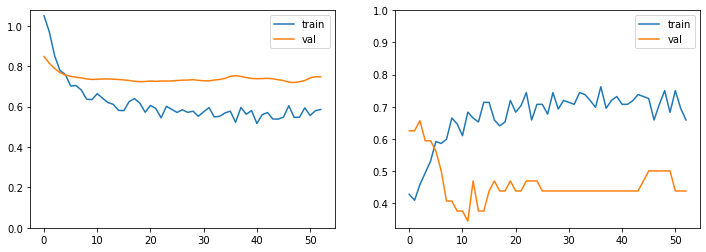

In [28]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 11. Varied Background

130 of 130
150 of 150
(224, 160, 160, 3) float32
(224,) int32
(56, 160, 160, 3) float32
(56,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 24s 244ms/step - loss: 82.3090 - val_loss: 69.2805
Epoch 2/100
100/100 [==============================] - 22s 222ms/step - loss: 47.1179 - val_loss: 64.8280
Epoch 3/100
100/100 [==============================] - 22s 222ms/step - loss: 16.7719 - val_loss: 62.3028
Epoch 4/100
100/100 [==============================] - 22s 222ms/step - loss: 8.3085 - val_loss: 72.0189
Epoch 5/100
100/100 [==============================] - 22s 222ms/step - loss: 6.5117 - val_loss: 69.6662
Epoch 6/100
100/100 [==============================] - 22s 222ms/step - loss: 3.8338 - val_loss: 78.5068
Epoch 7/100
100/100 [==============================] - 22s 222ms/step - loss: 3.3378 - val_loss: 77.3703
Epoch 8/100
100/100 [==============================] - 22s 222ms/step - loss: 2.4684 - val_loss: 82.6233
Epoch 9/100
100/100 [==============================] - 22s 222ms/step - loss: 2.2924 - val_loss: 87.7731
Epoch 10/100
100/100 [==============================

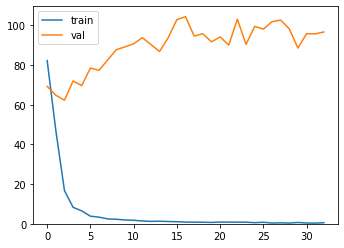

In [29]:
REQ_NAME = 'varied_background'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
7/7 [==============================] - 2s 356ms/step - loss: 0.6673 - accuracy: 0.7054 - precision: 0.8495 - recall: 0.4912 - f1: 0.6046 - specificity: 0.9157 - negative_predictive_value: 0.6616 - matthews_correlation_coefficient: 0.4541 - equal_error_rate: 0.4201 - val_loss: 0.6568 - val_accuracy: 0.6562 - val_precision: 1.0000 - val_recall: 0.3529 - val_f1: 0.5217 - val_specificity: 1.0000 - val_negative_predictive_value: 0.5769 - val_matthews_correlation_coefficient: 0.4512 - val_equal_error_rate: 0.2176

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.45124, saving model to ../../models/siamese_networks/varied_background_2020_06_08-02_08_37.h5
Epoch 2/100
7/7 [==============================] - 1s 116ms/step - loss: 0.6587 - accuracy: 0.6635 - precision: 0.9643 - recall: 0.3592 - f1: 0.5096 - specificity: 0.9286 - negative_predictive_value: 0.5656 - matthews_correlation_coefficient: 0.3883 - equal_error_rate: 0.3121 - val_loss: 0.6123 - val_accu

7/7 [==============================] - 1s 113ms/step - loss: 0.5293 - accuracy: 0.7500 - precision: 0.9821 - recall: 0.5241 - f1: 0.6779 - specificity: 0.9643 - negative_predictive_value: 0.6331 - matthews_correlation_coefficient: 0.5447 - equal_error_rate: 0.1555 - val_loss: 0.4848 - val_accuracy: 0.7188 - val_precision: 0.7857 - val_recall: 0.6471 - val_f1: 0.7097 - val_specificity: 0.8000 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.4497 - val_equal_error_rate: 0.2176

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.54799
Epoch 15/100
7/7 [==============================] - 1s 114ms/step - loss: 0.5071 - accuracy: 0.7692 - precision: 0.9102 - recall: 0.5636 - f1: 0.6900 - specificity: 0.9051 - negative_predictive_value: 0.6676 - matthews_correlation_coefficient: 0.5186 - equal_error_rate: 0.1576 - val_loss: 0.4785 - val_accuracy: 0.7188 - val_precision: 0.7857 - val_recall: 0.6471 - val_f1: 0.7097 - val_specificity: 0.8000

7/7 [==============================] - 1s 117ms/step - loss: 0.4507 - accuracy: 0.8077 - precision: 0.9548 - recall: 0.6570 - f1: 0.7696 - specificity: 0.8827 - negative_predictive_value: 0.6751 - matthews_correlation_coefficient: 0.5816 - equal_error_rate: 0.1429 - val_loss: 0.4231 - val_accuracy: 0.8125 - val_precision: 0.8235 - val_recall: 0.8235 - val_f1: 0.8235 - val_specificity: 0.8000 - val_negative_predictive_value: 0.8000 - val_matthews_correlation_coefficient: 0.6235 - val_equal_error_rate: 0.2176

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.62353
Epoch 28/100
7/7 [==============================] - 1s 118ms/step - loss: 0.4662 - accuracy: 0.8125 - precision: 0.9357 - recall: 0.6598 - f1: 0.7648 - specificity: 0.9126 - negative_predictive_value: 0.7047 - matthews_correlation_coefficient: 0.6036 - equal_error_rate: 0.1697 - val_loss: 0.4207 - val_accuracy: 0.8125 - val_precision: 0.8235 - val_recall: 0.8235 - val_f1: 0.8235 - val_specificity: 0.8000

7/7 [==============================] - 1s 119ms/step - loss: 0.3996 - accuracy: 0.8606 - precision: 0.9520 - recall: 0.7593 - f1: 0.8355 - specificity: 0.9135 - negative_predictive_value: 0.7599 - matthews_correlation_coefficient: 0.6906 - equal_error_rate: 0.1448 - val_loss: 0.3908 - val_accuracy: 0.8125 - val_precision: 0.8235 - val_recall: 0.8235 - val_f1: 0.8235 - val_specificity: 0.8000 - val_negative_predictive_value: 0.8000 - val_matthews_correlation_coefficient: 0.6235 - val_equal_error_rate: 0.2176

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.62353
Epoch 41/100
7/7 [==============================] - 1s 120ms/step - loss: 0.3668 - accuracy: 0.8884 - precision: 0.9762 - recall: 0.7872 - f1: 0.8653 - specificity: 0.9850 - negative_predictive_value: 0.8344 - matthews_correlation_coefficient: 0.7902 - equal_error_rate: 0.1127 - val_loss: 0.3897 - val_accuracy: 0.8125 - val_precision: 0.8235 - val_recall: 0.8235 - val_f1: 0.8235 - val_specificity: 0.8000

7/7 [==============================] - 1s 129ms/step - loss: 0.3867 - accuracy: 0.8462 - precision: 0.9608 - recall: 0.7335 - f1: 0.8294 - specificity: 0.9484 - negative_predictive_value: 0.7424 - matthews_correlation_coefficient: 0.6915 - equal_error_rate: 0.1355 - val_loss: 0.3717 - val_accuracy: 0.8438 - val_precision: 0.8333 - val_recall: 0.8824 - val_f1: 0.8571 - val_specificity: 0.8000 - val_negative_predictive_value: 0.8571 - val_matthews_correlation_coefficient: 0.6864 - val_equal_error_rate: 0.2176

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.68640
Epoch 54/100
7/7 [==============================] - 1s 127ms/step - loss: 0.4000 - accuracy: 0.8413 - precision: 0.9128 - recall: 0.7488 - f1: 0.8159 - specificity: 0.8843 - negative_predictive_value: 0.7576 - matthews_correlation_coefficient: 0.6507 - equal_error_rate: 0.1176 - val_loss: 0.3709 - val_accuracy: 0.8438 - val_precision: 0.8333 - val_recall: 0.8824 - val_f1: 0.8571 - val_specificity: 0.8000


Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.68640
Epoch 67/100
7/7 [==============================] - 1s 132ms/step - loss: 0.3426 - accuracy: 0.8798 - precision: 0.9650 - recall: 0.7971 - f1: 0.8695 - specificity: 0.9492 - negative_predictive_value: 0.7937 - matthews_correlation_coefficient: 0.7518 - equal_error_rate: 0.1180 - val_loss: 0.3613 - val_accuracy: 0.8438 - val_precision: 0.8333 - val_recall: 0.8824 - val_f1: 0.8571 - val_specificity: 0.8000 - val_negative_predictive_value: 0.8571 - val_matthews_correlation_coefficient: 0.6864 - val_equal_error_rate: 0.2176

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.68640
Epoch 68/100
7/7 [==============================] - 1s 130ms/step - loss: 0.3943 - accuracy: 0.8365 - precision: 0.8930 - recall: 0.7544 - f1: 0.8110 - specificity: 0.8742 - negative_predictive_value: 0.7640 - matthews_correlation_coefficient: 0.6419 - equal_error_rate: 0.1639 - val_loss: 0.3602 - val_accuracy: 0

7/7 [==============================] - 1s 134ms/step - loss: 0.3708 - accuracy: 0.8413 - precision: 0.9013 - recall: 0.7693 - f1: 0.8249 - specificity: 0.8794 - negative_predictive_value: 0.7781 - matthews_correlation_coefficient: 0.6634 - equal_error_rate: 0.1652 - val_loss: 0.3490 - val_accuracy: 0.8438 - val_precision: 0.8333 - val_recall: 0.8824 - val_f1: 0.8571 - val_specificity: 0.8000 - val_negative_predictive_value: 0.8571 - val_matthews_correlation_coefficient: 0.6864 - val_equal_error_rate: 0.2176

Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.75308
Epoch 81/100
7/7 [==============================] - 1s 128ms/step - loss: 0.3465 - accuracy: 0.8527 - precision: 0.9393 - recall: 0.7447 - f1: 0.8241 - specificity: 0.9562 - negative_predictive_value: 0.7995 - matthews_correlation_coefficient: 0.7187 - equal_error_rate: 0.0961 - val_loss: 0.3486 - val_accuracy: 0.8438 - val_precision: 0.8333 - val_recall: 0.8824 - val_f1: 0.8571 - val_specificity: 0.8000


Epoch 00093: val_matthews_correlation_coefficient did not improve from 0.75308
Epoch 94/100
7/7 [==============================] - 1s 135ms/step - loss: 0.3566 - accuracy: 0.8606 - precision: 0.9354 - recall: 0.7833 - f1: 0.8504 - specificity: 0.8908 - negative_predictive_value: 0.7672 - matthews_correlation_coefficient: 0.6878 - equal_error_rate: 0.1287 - val_loss: 0.3466 - val_accuracy: 0.8750 - val_precision: 0.8421 - val_recall: 0.9412 - val_f1: 0.8889 - val_specificity: 0.8000 - val_negative_predictive_value: 0.9231 - val_matthews_correlation_coefficient: 0.7531 - val_equal_error_rate: 0.2176

Epoch 00094: val_matthews_correlation_coefficient did not improve from 0.75308
Epoch 95/100
7/7 [==============================] - 1s 132ms/step - loss: 0.3751 - accuracy: 0.8317 - precision: 0.9098 - recall: 0.7353 - f1: 0.8072 - specificity: 0.8798 - negative_predictive_value: 0.7540 - matthews_correlation_coefficient: 0.6385 - equal_error_rate: 0.1571 - val_loss: 0.3466 - val_accuracy: 0

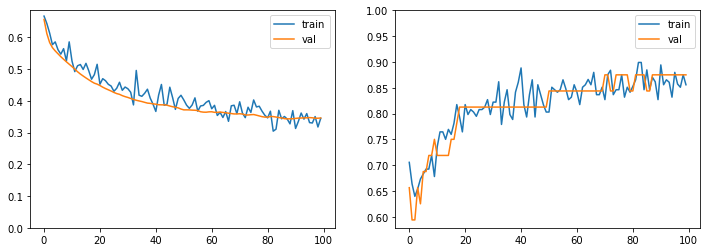

In [30]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 12. Roll/pitch/yaw

150 of 150
141 of 141
(232, 160, 160, 3) float32
(232,) int32
(59, 160, 160, 3) float32
(59,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 25s 255ms/step - loss: 95.9648 - val_loss: 95.9992
Epoch 2/100
100/100 [==============================] - 23s 231ms/step - loss: 89.8648 - val_loss: 96.8645
Epoch 3/100
100/100 [==============================] - 23s 232ms/step - loss: 83.4836 - val_loss: 92.5997
Epoch 4/100
100/100 [==============================] - 23s 232ms/step - loss: 80.0853 - val_loss: 86.1745
Epoch 5/100
100/100 [==============================] - 23s 232ms/step - loss: 72.8622 - val_loss: 84.3405
Epoch 6/100
100/100 [==============================] - 23s 232ms/step - loss: 67.8120 - val_loss: 87.9603
Epoch 7/100
100/100 [==============================] - 23s 232ms/step - loss: 60.6794 - val_loss: 83.7073
Epoch 8/100
100/100 [==============================] - 23s 232ms/step - loss: 55.6828 - val_loss: 83.9836
Epoch 9/100
100/100 [==============================] - 23s 232ms/step - loss: 50.2994 - val_loss: 85.1150
Epoch 10/100
100/100 [========================

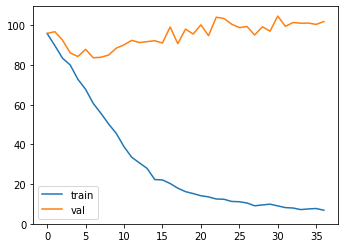

In [31]:
REQ_NAME = 'roll_pitch_yaw'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
7/7 [==============================] - 3s 410ms/step - loss: 0.8472 - accuracy: 0.4375 - precision: 0.4520 - recall: 0.6258 - f1: 0.5154 - specificity: 0.2534 - negative_predictive_value: 0.4178 - matthews_correlation_coefficient: -0.1252 - equal_error_rate: 0.5040 - val_loss: 0.8283 - val_accuracy: 0.4688 - val_precision: 0.5000 - val_recall: 0.7059 - val_f1: 0.5854 - val_specificity: 0.2000 - val_negative_predictive_value: 0.3750 - val_matthews_correlation_coefficient: -0.1085 - val_equal_error_rate: 0.6863

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.10847, saving model to ../../models/siamese_networks/roll_pitch_yaw_2020_06_08-02_25_59.h5
Epoch 2/100
7/7 [==============================] - 1s 136ms/step - loss: 0.7745 - accuracy: 0.4904 - precision: 0.4727 - recall: 0.5664 - f1: 0.5127 - specificity: 0.4106 - negative_predictive_value: 0.5083 - matthews_correlation_coefficient: -0.0210 - equal_error_rate: 0.4861 - val_loss: 0.7738 - val_acc


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.36309
Epoch 14/100
7/7 [==============================] - 1s 114ms/step - loss: 0.6420 - accuracy: 0.6490 - precision: 0.8025 - recall: 0.4632 - f1: 0.5790 - specificity: 0.8899 - negative_predictive_value: 0.6090 - matthews_correlation_coefficient: 0.3807 - equal_error_rate: 0.3623 - val_loss: 0.6423 - val_accuracy: 0.5625 - val_precision: 0.6667 - val_recall: 0.3529 - val_f1: 0.4615 - val_specificity: 0.8000 - val_negative_predictive_value: 0.5217 - val_matthews_correlation_coefficient: 0.1697 - val_equal_error_rate: 0.3431

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.36309
Epoch 15/100
7/7 [==============================] - 1s 117ms/step - loss: 0.6607 - accuracy: 0.6442 - precision: 0.7454 - recall: 0.4776 - f1: 0.5646 - specificity: 0.8524 - negative_predictive_value: 0.6281 - matthews_correlation_coefficient: 0.3503 - equal_error_rate: 0.3982 - val_loss: 0.6413 - val_accuracy: 0

7/7 [==============================] - 1s 114ms/step - loss: 0.6405 - accuracy: 0.6442 - precision: 0.8116 - recall: 0.4365 - f1: 0.5655 - specificity: 0.9009 - negative_predictive_value: 0.5900 - matthews_correlation_coefficient: 0.3678 - equal_error_rate: 0.3838 - val_loss: 0.6268 - val_accuracy: 0.5938 - val_precision: 0.7500 - val_recall: 0.3529 - val_f1: 0.4800 - val_specificity: 0.8667 - val_negative_predictive_value: 0.5417 - val_matthews_correlation_coefficient: 0.2531 - val_equal_error_rate: 0.3431

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.36309
Epoch 28/100
7/7 [==============================] - 1s 114ms/step - loss: 0.6450 - accuracy: 0.6442 - precision: 0.7188 - recall: 0.4059 - f1: 0.5133 - specificity: 0.8714 - negative_predictive_value: 0.6003 - matthews_correlation_coefficient: 0.2974 - equal_error_rate: 0.3527 - val_loss: 0.6256 - val_accuracy: 0.5938 - val_precision: 0.7500 - val_recall: 0.3529 - val_f1: 0.4800 - val_specificity: 0.8667


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.36309
Epoch 41/100
7/7 [==============================] - 1s 116ms/step - loss: 0.6229 - accuracy: 0.6830 - precision: 0.8605 - recall: 0.4455 - f1: 0.5754 - specificity: 0.9368 - negative_predictive_value: 0.6240 - matthews_correlation_coefficient: 0.4294 - equal_error_rate: 0.3385 - val_loss: 0.6242 - val_accuracy: 0.5938 - val_precision: 0.7000 - val_recall: 0.4118 - val_f1: 0.5185 - val_specificity: 0.8000 - val_negative_predictive_value: 0.5455 - val_matthews_correlation_coefficient: 0.2280 - val_equal_error_rate: 0.4059

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.36309
Epoch 42/100
7/7 [==============================] - 1s 115ms/step - loss: 0.6148 - accuracy: 0.6683 - precision: 0.7303 - recall: 0.5188 - f1: 0.5977 - specificity: 0.8254 - negative_predictive_value: 0.6447 - matthews_correlation_coefficient: 0.3590 - equal_error_rate: 0.3354 - val_loss: 0.6234 - val_accuracy: 0

7/7 [==============================] - 1s 117ms/step - loss: 0.6276 - accuracy: 0.6442 - precision: 0.7296 - recall: 0.4954 - f1: 0.5844 - specificity: 0.8382 - negative_predictive_value: 0.6168 - matthews_correlation_coefficient: 0.3397 - equal_error_rate: 0.3209 - val_loss: 0.6091 - val_accuracy: 0.6250 - val_precision: 0.7778 - val_recall: 0.4118 - val_f1: 0.5385 - val_specificity: 0.8667 - val_negative_predictive_value: 0.5652 - val_matthews_correlation_coefficient: 0.3090 - val_equal_error_rate: 0.4059

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.36309
Epoch 55/100
7/7 [==============================] - 1s 114ms/step - loss: 0.6396 - accuracy: 0.6538 - precision: 0.7276 - recall: 0.4363 - f1: 0.5421 - specificity: 0.8648 - negative_predictive_value: 0.6172 - matthews_correlation_coefficient: 0.3219 - equal_error_rate: 0.3490 - val_loss: 0.6076 - val_accuracy: 0.6250 - val_precision: 0.7778 - val_recall: 0.4118 - val_f1: 0.5385 - val_specificity: 0.8667

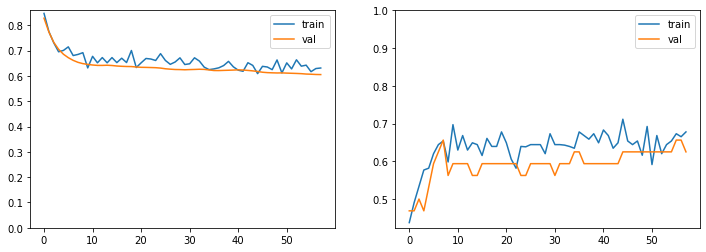

In [32]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 13. Flash Reflection on Skin

84 of 84
70 of 70
(123, 160, 160, 3) float32
(123,) int32
(31, 160, 160, 3) float32
(31,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 20s 203ms/step - loss: 86.3012 - val_loss: 72.4451
Epoch 2/100
100/100 [==============================] - 18s 179ms/step - loss: 57.6607 - val_loss: 76.7822
Epoch 3/100
100/100 [==============================] - 18s 179ms/step - loss: 37.7948 - val_loss: 73.1623
Epoch 4/100
100/100 [==============================] - 18s 179ms/step - loss: 20.6075 - val_loss: 65.5252
Epoch 5/100
100/100 [==============================] - 18s 179ms/step - loss: 11.9000 - val_loss: 68.8809
Epoch 6/100
100/100 [==============================] - 18s 179ms/step - loss: 8.0508 - val_loss: 65.0414
Epoch 7/100
100/100 [==============================] - 18s 179ms/step - loss: 5.7862 - val_loss: 64.7756
Epoch 8/100
100/100 [==============================] - 18s 179ms/step - loss: 5.1327 - val_loss: 57.6854
Epoch 9/100
100/100 [==============================] - 18s 179ms/step - loss: 3.3831 - val_loss: 70.6862
Epoch 10/100
100/100 [============================

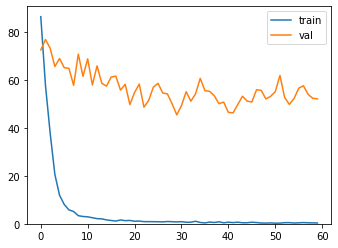

In [33]:
REQ_NAME = 'flash_reflection_on_skin'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
4/4 [==============================] - 2s 607ms/step - loss: 0.6028 - accuracy: 0.8125 - precision: 0.9264 - recall: 0.6637 - f1: 0.7719 - specificity: 0.9556 - negative_predictive_value: 0.7448 - matthews_correlation_coefficient: 0.6441 - equal_error_rate: 0.3050 - val_loss: 0.7010 - val_accuracy: 0.6452 - val_precision: 0.6667 - val_recall: 0.4286 - val_f1: 0.5217 - val_specificity: 0.8235 - val_negative_predictive_value: 0.6364 - val_matthews_correlation_coefficient: 0.2764 - val_equal_error_rate: 0.4202

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.27639, saving model to ../../models/siamese_networks/flash_reflection_on_skin_2020_06_08-02_46_17.h5
Epoch 2/100
4/4 [==============================] - 1s 148ms/step - loss: 0.5707 - accuracy: 0.8039 - precision: 1.0000 - recall: 0.5464 - f1: 0.6943 - specificity: 1.0000 - negative_predictive_value: 0.6951 - matthews_correlation_coefficient: 0.6130 - equal_error_rate: 0.2763 - val_loss: 0.7033 - v

4/4 [==============================] - 0s 91ms/step - loss: 0.4673 - accuracy: 0.7549 - precision: 0.7500 - recall: 0.4235 - f1: 0.5336 - specificity: 1.0000 - negative_predictive_value: 0.6318 - matthews_correlation_coefficient: 0.4612 - equal_error_rate: 0.0639 - val_loss: 0.6954 - val_accuracy: 0.5806 - val_precision: 0.5714 - val_recall: 0.2857 - val_f1: 0.3810 - val_specificity: 0.8235 - val_negative_predictive_value: 0.5833 - val_matthews_correlation_coefficient: 0.1300 - val_equal_error_rate: 0.3256

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.27639
Epoch 15/100
4/4 [==============================] - 0s 101ms/step - loss: 0.4297 - accuracy: 0.8137 - precision: 1.0000 - recall: 0.5742 - f1: 0.7159 - specificity: 1.0000 - negative_predictive_value: 0.7023 - matthews_correlation_coefficient: 0.6321 - equal_error_rate: 0.0813 - val_loss: 0.6967 - val_accuracy: 0.5806 - val_precision: 0.5714 - val_recall: 0.2857 - val_f1: 0.3810 - val_specificity: 0.8235 

4/4 [==============================] - 0s 105ms/step - loss: 0.4012 - accuracy: 0.8431 - precision: 1.0000 - recall: 0.6222 - f1: 0.7496 - specificity: 1.0000 - negative_predictive_value: 0.7291 - matthews_correlation_coefficient: 0.6701 - equal_error_rate: 0.0975 - val_loss: 0.7300 - val_accuracy: 0.7097 - val_precision: 0.7273 - val_recall: 0.5714 - val_f1: 0.6400 - val_specificity: 0.8235 - val_negative_predictive_value: 0.7000 - val_matthews_correlation_coefficient: 0.4108 - val_equal_error_rate: 0.3256

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.41080
Epoch 28/100
4/4 [==============================] - 1s 129ms/step - loss: 0.2569 - accuracy: 0.8922 - precision: 0.9808 - recall: 0.7724 - f1: 0.8612 - specificity: 0.9844 - negative_predictive_value: 0.8224 - matthews_correlation_coefficient: 0.7795 - equal_error_rate: 0.0825 - val_loss: 0.7306 - val_accuracy: 0.7097 - val_precision: 0.7273 - val_recall: 0.5714 - val_f1: 0.6400 - val_specificity: 0.8235


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.41080
Epoch 41/100
4/4 [==============================] - 0s 125ms/step - loss: 0.2613 - accuracy: 0.9219 - precision: 0.9629 - recall: 0.8788 - f1: 0.9179 - specificity: 0.9712 - negative_predictive_value: 0.8836 - matthews_correlation_coefficient: 0.8482 - equal_error_rate: 0.0696 - val_loss: 0.7876 - val_accuracy: 0.6774 - val_precision: 0.6429 - val_recall: 0.6429 - val_f1: 0.6429 - val_specificity: 0.7059 - val_negative_predictive_value: 0.7059 - val_matthews_correlation_coefficient: 0.3487 - val_equal_error_rate: 0.3256

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.41080
Epoch 42/100
4/4 [==============================] - 0s 120ms/step - loss: 0.2685 - accuracy: 0.9118 - precision: 1.0000 - recall: 0.7314 - f1: 0.8179 - specificity: 1.0000 - negative_predictive_value: 0.8031 - matthews_correlation_coefficient: 0.7622 - equal_error_rate: 0.0657 - val_loss: 0.7908 - val_accuracy: 0

4/4 [==============================] - 1s 134ms/step - loss: 0.2425 - accuracy: 0.8922 - precision: 1.0000 - recall: 0.8405 - f1: 0.9104 - specificity: 1.0000 - negative_predictive_value: 0.8516 - matthews_correlation_coefficient: 0.8460 - equal_error_rate: 0.0795 - val_loss: 0.8224 - val_accuracy: 0.6452 - val_precision: 0.6000 - val_recall: 0.6429 - val_f1: 0.6207 - val_specificity: 0.6471 - val_negative_predictive_value: 0.6875 - val_matthews_correlation_coefficient: 0.2887 - val_equal_error_rate: 0.3550

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.41080
Epoch 55/100
4/4 [==============================] - 1s 129ms/step - loss: 0.2361 - accuracy: 0.9118 - precision: 0.9661 - recall: 0.8944 - f1: 0.9271 - specificity: 0.9676 - negative_predictive_value: 0.8974 - matthews_correlation_coefficient: 0.8627 - equal_error_rate: 0.0884 - val_loss: 0.8277 - val_accuracy: 0.6452 - val_precision: 0.6000 - val_recall: 0.6429 - val_f1: 0.6207 - val_specificity: 0.6471


Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.41080
Epoch 68/100
4/4 [==============================] - 1s 154ms/step - loss: 0.1868 - accuracy: 0.9608 - precision: 0.9496 - recall: 0.9808 - f1: 0.9646 - specificity: 0.9581 - negative_predictive_value: 0.9861 - matthews_correlation_coefficient: 0.9372 - equal_error_rate: 0.0897 - val_loss: 0.8798 - val_accuracy: 0.6129 - val_precision: 0.5625 - val_recall: 0.6429 - val_f1: 0.6000 - val_specificity: 0.5882 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.2301 - val_equal_error_rate: 0.3550

Epoch 00068: val_matthews_correlation_coefficient did not improve from 0.41080
Epoch 69/100
4/4 [==============================] - 0s 122ms/step - loss: 0.2045 - accuracy: 0.9314 - precision: 0.9844 - recall: 0.8435 - f1: 0.9038 - specificity: 0.9844 - negative_predictive_value: 0.8608 - matthews_correlation_coefficient: 0.8362 - equal_error_rate: 0.0795 - val_loss: 0.8844 - val_accuracy: 0

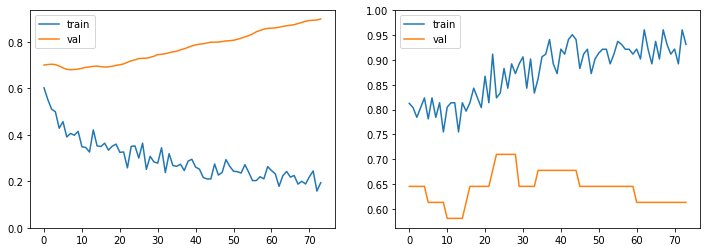

In [34]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 14. Red Eyes 

78 of 78
39 of 39
(93, 160, 160, 3) float32
(93,) int32
(24, 160, 160, 3) float32
(24,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 18s 177ms/step - loss: 90.2132 - val_loss: 91.4016
Epoch 2/100
100/100 [==============================] - 16s 157ms/step - loss: 65.7488 - val_loss: 69.2669
Epoch 3/100
100/100 [==============================] - 16s 158ms/step - loss: 39.3548 - val_loss: 70.3422
Epoch 4/100
100/100 [==============================] - 16s 158ms/step - loss: 24.8371 - val_loss: 67.3776
Epoch 5/100
100/100 [==============================] - 16s 158ms/step - loss: 15.0084 - val_loss: 71.3024
Epoch 6/100
100/100 [==============================] - 16s 158ms/step - loss: 7.6059 - val_loss: 74.6259
Epoch 7/100
100/100 [==============================] - 16s 157ms/step - loss: 4.6726 - val_loss: 67.1759
Epoch 8/100
100/100 [==============================] - 16s 157ms/step - loss: 3.1192 - val_loss: 73.3096
Epoch 9/100
100/100 [==============================] - 16s 158ms/step - loss: 2.0632 - val_loss: 72.1853
Epoch 10/100
100/100 [============================

100/100 [==============================] - 16s 158ms/step - loss: 0.1080 - val_loss: 56.9114
Epoch 79/100
100/100 [==============================] - 16s 158ms/step - loss: 0.1552 - val_loss: 46.4382
Epoch 80/100
100/100 [==============================] - 16s 157ms/step - loss: 0.1265 - val_loss: 43.0705
Epoch 81/100
100/100 [==============================] - 16s 158ms/step - loss: 0.2135 - val_loss: 32.7096
Epoch 82/100
100/100 [==============================] - 16s 157ms/step - loss: 0.1300 - val_loss: 44.6653
Epoch 83/100
100/100 [==============================] - 16s 158ms/step - loss: 0.1158 - val_loss: 55.3482
Epoch 84/100
100/100 [==============================] - 16s 158ms/step - loss: 0.2491 - val_loss: 56.2528
Epoch 85/100
100/100 [==============================] - 16s 158ms/step - loss: 0.0991 - val_loss: 50.8260
Epoch 86/100
100/100 [==============================] - 16s 158ms/step - loss: 0.0975 - val_loss: 47.4206
Epoch 87/100
100/100 [==============================] - 16s

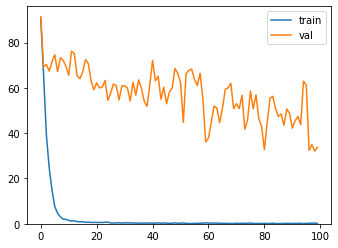

In [35]:
REQ_NAME = 'red_eyes'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 3s 854ms/step - loss: 0.6916 - accuracy: 0.6458 - precision: 0.6932 - recall: 0.5940 - f1: 0.6365 - specificity: 0.7059 - negative_predictive_value: 0.6021 - matthews_correlation_coefficient: 0.2976 - equal_error_rate: 0.3731 - val_loss: 0.6032 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.4545 - val_f1: 0.6250 - val_specificity: 1.0000 - val_negative_predictive_value: 0.6842 - val_matthews_correlation_coefficient: 0.5577 - val_equal_error_rate: 0.1748

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.55768, saving model to ../../models/siamese_networks/red_eyes_2020_06_08-03_14_49.h5
Epoch 2/100
3/3 [==============================] - 0s 150ms/step - loss: 0.5827 - accuracy: 0.7717 - precision: 0.8949 - recall: 0.5990 - f1: 0.7060 - specificity: 0.9094 - negative_predictive_value: 0.7123 - matthews_correlation_coefficient: 0.5519 - equal_error_rate: 0.2493 - val_loss: 0.5486 - val_accuracy: 0.7

3/3 [==============================] - 0s 106ms/step - loss: 0.2504 - accuracy: 0.8913 - precision: 1.0000 - recall: 0.7791 - f1: 0.8756 - specificity: 1.0000 - negative_predictive_value: 0.8214 - matthews_correlation_coefficient: 0.7994 - equal_error_rate: 0.0451 - val_loss: 0.2535 - val_accuracy: 0.9167 - val_precision: 1.0000 - val_recall: 0.8182 - val_f1: 0.9000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.8667 - val_matthews_correlation_coefficient: 0.8421 - val_equal_error_rate: 0.0839

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.84208
Epoch 15/100
3/3 [==============================] - 0s 131ms/step - loss: 0.2189 - accuracy: 0.9022 - precision: 0.9630 - recall: 0.8258 - f1: 0.8857 - specificity: 0.9804 - negative_predictive_value: 0.8493 - matthews_correlation_coefficient: 0.8089 - equal_error_rate: 0.0425 - val_loss: 0.2457 - val_accuracy: 0.9167 - val_precision: 1.0000 - val_recall: 0.8182 - val_f1: 0.9000 - val_specificity: 1.0000


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.84208
Epoch 28/100
3/3 [==============================] - 0s 153ms/step - loss: 0.1239 - accuracy: 0.9783 - precision: 1.0000 - recall: 0.9487 - f1: 0.9722 - specificity: 1.0000 - negative_predictive_value: 0.9683 - matthews_correlation_coefficient: 0.9583 - equal_error_rate: 0.0372 - val_loss: 0.1886 - val_accuracy: 0.9167 - val_precision: 1.0000 - val_recall: 0.8182 - val_f1: 0.9000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.8667 - val_matthews_correlation_coefficient: 0.8421 - val_equal_error_rate: 0.0839

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.84208
Epoch 29/100
3/3 [==============================] - 0s 134ms/step - loss: 0.1267 - accuracy: 0.9583 - precision: 1.0000 - recall: 0.9154 - f1: 0.9547 - specificity: 1.0000 - negative_predictive_value: 0.9206 - matthews_correlation_coefficient: 0.9178 - equal_error_rate: 0.0304 - val_loss: 0.1858 - val_accuracy: 0

3/3 [==============================] - 0s 127ms/step - loss: 0.1487 - accuracy: 0.9375 - precision: 1.0000 - recall: 0.8821 - f1: 0.9352 - specificity: 1.0000 - negative_predictive_value: 0.8849 - matthews_correlation_coefficient: 0.8832 - equal_error_rate: 0.0304 - val_loss: 0.1650 - val_accuracy: 0.9167 - val_precision: 1.0000 - val_recall: 0.8182 - val_f1: 0.9000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.8667 - val_matthews_correlation_coefficient: 0.8421 - val_equal_error_rate: 0.0839

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.84208
Epoch 42/100
3/3 [==============================] - 0s 157ms/step - loss: 0.1013 - accuracy: 0.9783 - precision: 1.0000 - recall: 0.9667 - f1: 0.9825 - specificity: 1.0000 - negative_predictive_value: 0.9524 - matthews_correlation_coefficient: 0.9594 - equal_error_rate: 0.0363 - val_loss: 0.1634 - val_accuracy: 0.9167 - val_precision: 1.0000 - val_recall: 0.8182 - val_f1: 0.9000 - val_specificity: 1.0000


Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.84208
Epoch 55/100
3/3 [==============================] - 0s 146ms/step - loss: 0.1160 - accuracy: 0.9565 - precision: 0.9825 - recall: 0.9227 - f1: 0.9491 - specificity: 0.9762 - negative_predictive_value: 0.9393 - matthews_correlation_coefficient: 0.9100 - equal_error_rate: 0.0327 - val_loss: 0.1493 - val_accuracy: 0.9167 - val_precision: 1.0000 - val_recall: 0.8182 - val_f1: 0.9000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.8667 - val_matthews_correlation_coefficient: 0.8421 - val_equal_error_rate: 0.0839

Epoch 00055: val_matthews_correlation_coefficient did not improve from 0.84208
Epoch 56/100
3/3 [==============================] - ETA: 0s - loss: 0.1069 - accuracy: 0.9688 - precision: 1.0000 - recall: 0.9231 - f1: 0.9583 - specificity: 1.0000 - negative_predictive_value: 0.9524 - matthews_correlation_coefficient: 0.9375 - equal_error_rate: 0.03 - 0s 143ms/step - loss: 0.1023 - accuracy: 0

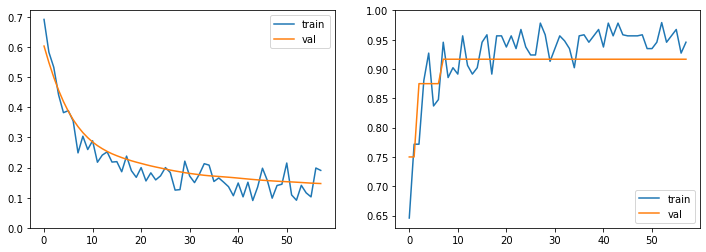

In [36]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 15. Shadows Behind Head 

99 of 99
94 of 94
(154, 160, 160, 3) float32
(154,) int32
(39, 160, 160, 3) float32
(39,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 23s 227ms/step - loss: 80.1128 - val_loss: 77.9569
Epoch 2/100
100/100 [==============================] - 21s 207ms/step - loss: 59.5896 - val_loss: 68.5488
Epoch 3/100
100/100 [==============================] - 21s 207ms/step - loss: 44.0625 - val_loss: 59.5668
Epoch 4/100
100/100 [==============================] - 21s 207ms/step - loss: 29.5496 - val_loss: 53.4468
Epoch 5/100
100/100 [==============================] - 21s 207ms/step - loss: 18.5435 - val_loss: 58.8485
Epoch 6/100
100/100 [==============================] - 21s 208ms/step - loss: 14.8561 - val_loss: 53.3103
Epoch 7/100
100/100 [==============================] - 21s 207ms/step - loss: 11.1701 - val_loss: 52.8601
Epoch 8/100
100/100 [==============================] - 21s 207ms/step - loss: 8.9796 - val_loss: 53.6099
Epoch 9/100
100/100 [==============================] - 21s 207ms/step - loss: 6.9672 - val_loss: 45.6466
Epoch 10/100
100/100 [==========================

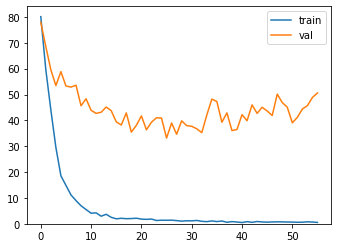

In [37]:
REQ_NAME = 'shadows_behind_head'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
4/4 [==============================] - 3s 700ms/step - loss: 0.5214 - accuracy: 0.7734 - precision: 0.9444 - recall: 0.5524 - f1: 0.6957 - specificity: 0.9706 - negative_predictive_value: 0.7101 - matthews_correlation_coefficient: 0.5850 - equal_error_rate: 0.2275 - val_loss: 0.5772 - val_accuracy: 0.6562 - val_precision: 1.0000 - val_recall: 0.3889 - val_f1: 0.5600 - val_specificity: 1.0000 - val_negative_predictive_value: 0.5600 - val_matthews_correlation_coefficient: 0.4667 - val_equal_error_rate: 0.2183

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.46667, saving model to ../../models/siamese_networks/shadows_behind_head_2020_06_08-03_36_38.h5
Epoch 2/100
4/4 [==============================] - 1s 128ms/step - loss: 0.4607 - accuracy: 0.7619 - precision: 0.9472 - recall: 0.5616 - f1: 0.7049 - specificity: 0.9697 - negative_predictive_value: 0.6766 - matthews_correlation_coefficient: 0.5749 - equal_error_rate: 0.1513 - val_loss: 0.5579 - val_ac

4/4 [==============================] - 0s 105ms/step - loss: 0.2760 - accuracy: 0.8889 - precision: 0.9821 - recall: 0.7891 - f1: 0.8726 - specificity: 0.9853 - negative_predictive_value: 0.8256 - matthews_correlation_coefficient: 0.7903 - equal_error_rate: 0.0626 - val_loss: 0.5603 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.5556 - val_f1: 0.7143 - val_specificity: 1.0000 - val_negative_predictive_value: 0.6364 - val_matthews_correlation_coefficient: 0.5946 - val_equal_error_rate: 0.1548

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.59459
Epoch 15/100
4/4 [==============================] - 0s 103ms/step - loss: 0.2732 - accuracy: 0.8889 - precision: 1.0000 - recall: 0.7863 - f1: 0.8743 - specificity: 1.0000 - negative_predictive_value: 0.8150 - matthews_correlation_coefficient: 0.7996 - equal_error_rate: 0.0564 - val_loss: 0.5636 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.5556 - val_f1: 0.7143 - val_specificity: 1.0000


Epoch 00027: val_matthews_correlation_coefficient improved from 0.59459 to 0.63828, saving model to ../../models/siamese_networks/shadows_behind_head_2020_06_08-03_36_38.h5
Epoch 28/100
4/4 [==============================] - 0s 110ms/step - loss: 0.2121 - accuracy: 0.9206 - precision: 1.0000 - recall: 0.8389 - f1: 0.9117 - specificity: 1.0000 - negative_predictive_value: 0.8605 - matthews_correlation_coefficient: 0.8493 - equal_error_rate: 0.0386 - val_loss: 0.5528 - val_accuracy: 0.8125 - val_precision: 1.0000 - val_recall: 0.6667 - val_f1: 0.8000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.7000 - val_matthews_correlation_coefficient: 0.6831 - val_equal_error_rate: 0.1548

Epoch 00028: val_matthews_correlation_coefficient improved from 0.63828 to 0.68313, saving model to ../../models/siamese_networks/shadows_behind_head_2020_06_08-03_36_38.h5
Epoch 29/100
4/4 [==============================] - 0s 103ms/step - loss: 0.2510 - accuracy: 0.8968 - precision: 0.9853 - reca

4/4 [==============================] - 0s 87ms/step - loss: 0.2892 - accuracy: 0.9062 - precision: 1.0000 - recall: 0.7985 - f1: 0.8871 - specificity: 1.0000 - negative_predictive_value: 0.8514 - matthews_correlation_coefficient: 0.8244 - equal_error_rate: 0.0638 - val_loss: 0.5287 - val_accuracy: 0.8438 - val_precision: 1.0000 - val_recall: 0.7222 - val_f1: 0.8387 - val_specificity: 1.0000 - val_negative_predictive_value: 0.7368 - val_matthews_correlation_coefficient: 0.7295 - val_equal_error_rate: 0.1548

Epoch 00041: val_matthews_correlation_coefficient improved from 0.68313 to 0.72950, saving model to ../../models/siamese_networks/shadows_behind_head_2020_06_08-03_36_38.h5
Epoch 42/100
4/4 [==============================] - 0s 106ms/step - loss: 0.2165 - accuracy: 0.9286 - precision: 0.9844 - recall: 0.8653 - f1: 0.9146 - specificity: 0.9844 - negative_predictive_value: 0.8953 - matthews_correlation_coefficient: 0.8638 - equal_error_rate: 0.0386 - val_loss: 0.5232 - val_accuracy: 0

4/4 [==============================] - 0s 108ms/step - loss: 0.1961 - accuracy: 0.9127 - precision: 0.9861 - recall: 0.8356 - f1: 0.9023 - specificity: 0.9773 - negative_predictive_value: 0.8602 - matthews_correlation_coefficient: 0.8291 - equal_error_rate: 0.0648 - val_loss: 0.4987 - val_accuracy: 0.8125 - val_precision: 0.9286 - val_recall: 0.7222 - val_f1: 0.8125 - val_specificity: 0.9286 - val_negative_predictive_value: 0.7222 - val_matthews_correlation_coefficient: 0.6508 - val_equal_error_rate: 0.1548

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.72950
Epoch 55/100
4/4 [==============================] - 0s 114ms/step - loss: 0.1696 - accuracy: 0.9444 - precision: 0.9686 - recall: 0.9272 - f1: 0.9457 - specificity: 0.9697 - negative_predictive_value: 0.9178 - matthews_correlation_coefficient: 0.8915 - equal_error_rate: 0.0384 - val_loss: 0.4992 - val_accuracy: 0.8125 - val_precision: 0.9286 - val_recall: 0.7222 - val_f1: 0.8125 - val_specificity: 0.9286


Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.72950
Epoch 68/100
4/4 [==============================] - 1s 130ms/step - loss: 0.1672 - accuracy: 0.9444 - precision: 0.9868 - recall: 0.8999 - f1: 0.9390 - specificity: 0.9773 - negative_predictive_value: 0.9152 - matthews_correlation_coefficient: 0.8894 - equal_error_rate: 0.0565 - val_loss: 0.5048 - val_accuracy: 0.8125 - val_precision: 0.9286 - val_recall: 0.7222 - val_f1: 0.8125 - val_specificity: 0.9286 - val_negative_predictive_value: 0.7222 - val_matthews_correlation_coefficient: 0.6508 - val_equal_error_rate: 0.1548

Epoch 00068: val_matthews_correlation_coefficient did not improve from 0.72950
Epoch 69/100
4/4 [==============================] - 0s 102ms/step - loss: 0.2158 - accuracy: 0.9286 - precision: 1.0000 - recall: 0.8499 - f1: 0.9162 - specificity: 1.0000 - negative_predictive_value: 0.8819 - matthews_correlation_coefficient: 0.8655 - equal_error_rate: 0.0538 - val_loss: 0.5028 - val_accuracy: 0

4/4 [==============================] - 0s 99ms/step - loss: 0.2211 - accuracy: 0.9219 - precision: 0.9844 - recall: 0.8451 - f1: 0.9035 - specificity: 0.9844 - negative_predictive_value: 0.8898 - matthews_correlation_coefficient: 0.8509 - equal_error_rate: 0.0477 - val_loss: 0.4930 - val_accuracy: 0.8125 - val_precision: 0.9286 - val_recall: 0.7222 - val_f1: 0.8125 - val_specificity: 0.9286 - val_negative_predictive_value: 0.7222 - val_matthews_correlation_coefficient: 0.6508 - val_equal_error_rate: 0.1548

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.72950
Epoch 82/100
4/4 [==============================] - 0s 118ms/step - loss: 0.2196 - accuracy: 0.8968 - precision: 0.9520 - recall: 0.8379 - f1: 0.8833 - specificity: 0.9550 - negative_predictive_value: 0.8627 - matthews_correlation_coefficient: 0.8028 - equal_error_rate: 0.0796 - val_loss: 0.4899 - val_accuracy: 0.8125 - val_precision: 0.9286 - val_recall: 0.7222 - val_f1: 0.8125 - val_specificity: 0.9286 

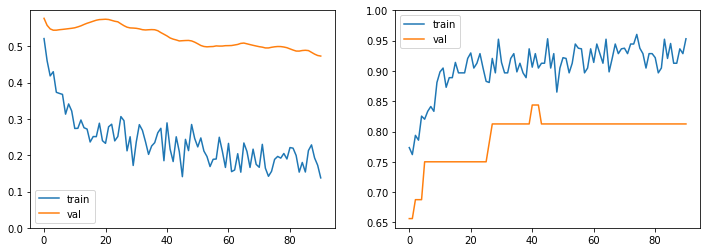

In [38]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 16. Shadows Across Face

158 of 158
141 of 141
(238, 160, 160, 3) float32
(238,) int32
(61, 160, 160, 3) float32
(61,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 26s 263ms/step - loss: 85.1486 - val_loss: 61.2832
Epoch 2/100
100/100 [==============================] - 25s 247ms/step - loss: 59.9647 - val_loss: 57.2856
Epoch 3/100
100/100 [==============================] - 25s 249ms/step - loss: 40.0123 - val_loss: 55.0843
Epoch 4/100
100/100 [==============================] - 25s 247ms/step - loss: 21.7711 - val_loss: 51.9477
Epoch 5/100
100/100 [==============================] - 25s 249ms/step - loss: 12.5774 - val_loss: 50.5127
Epoch 6/100
100/100 [==============================] - 25s 249ms/step - loss: 9.2135 - val_loss: 51.8327
Epoch 7/100
100/100 [==============================] - 25s 249ms/step - loss: 6.3002 - val_loss: 50.7646
Epoch 8/100
100/100 [==============================] - 25s 248ms/step - loss: 5.2141 - val_loss: 49.9100
Epoch 9/100
100/100 [==============================] - 25s 248ms/step - loss: 4.3790 - val_loss: 50.0975
Epoch 10/100
100/100 [============================

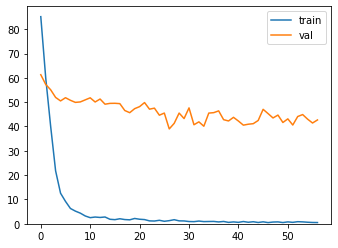

In [39]:
REQ_NAME = 'shadows_across_face'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
7/7 [==============================] - 4s 547ms/step - loss: 0.8929 - accuracy: 0.4152 - precision: 0.4488 - recall: 0.7111 - f1: 0.5446 - specificity: 0.1210 - negative_predictive_value: 0.3040 - matthews_correlation_coefficient: -0.2014 - equal_error_rate: 0.5716 - val_loss: 0.7269 - val_accuracy: 0.6250 - val_precision: 0.6429 - val_recall: 0.5902 - val_f1: 0.6129 - val_specificity: 0.6647 - val_negative_predictive_value: 0.6146 - val_matthews_correlation_coefficient: 0.2562 - val_equal_error_rate: 0.3598

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.25617, saving model to ../../models/siamese_networks/shadows_across_face_2020_06_08-04_03_16.h5
Epoch 2/100
7/7 [==============================] - 1s 159ms/step - loss: 0.7404 - accuracy: 0.4773 - precision: 0.5031 - recall: 0.6468 - f1: 0.5563 - specificity: 0.2990 - negative_predictive_value: 0.3845 - matthews_correlation_coefficient: -0.0795 - equal_error_rate: 0.4307 - val_loss: 0.6453 - val_

7/7 [==============================] - 1s 137ms/step - loss: 0.6362 - accuracy: 0.6591 - precision: 0.8964 - recall: 0.4238 - f1: 0.5046 - specificity: 0.9053 - negative_predictive_value: 0.6370 - matthews_correlation_coefficient: 0.4075 - equal_error_rate: 0.3142 - val_loss: 0.5553 - val_accuracy: 0.7500 - val_precision: 0.7281 - val_recall: 0.7745 - val_f1: 0.7500 - val_specificity: 0.7196 - val_negative_predictive_value: 0.7760 - val_matthews_correlation_coefficient: 0.4991 - val_equal_error_rate: 0.2343

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.62355
Epoch 15/100
7/7 [==============================] - 1s 136ms/step - loss: 0.6125 - accuracy: 0.6727 - precision: 0.9048 - recall: 0.4012 - f1: 0.5321 - specificity: 0.9429 - negative_predictive_value: 0.6072 - matthews_correlation_coefficient: 0.4145 - equal_error_rate: 0.3081 - val_loss: 0.5550 - val_accuracy: 0.7656 - val_precision: 0.7333 - val_recall: 0.8039 - val_f1: 0.7658 - val_specificity: 0.7196

7/7 [==============================] - 1s 135ms/step - loss: 0.6070 - accuracy: 0.7045 - precision: 0.8898 - recall: 0.4947 - f1: 0.5912 - specificity: 0.9066 - negative_predictive_value: 0.6669 - matthews_correlation_coefficient: 0.4640 - equal_error_rate: 0.2959 - val_loss: 0.5334 - val_accuracy: 0.8125 - val_precision: 0.7577 - val_recall: 0.9000 - val_f1: 0.8224 - val_specificity: 0.7196 - val_negative_predictive_value: 0.9000 - val_matthews_correlation_coefficient: 0.6382 - val_equal_error_rate: 0.2343

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.63818
Epoch 28/100
7/7 [==============================] - 1s 136ms/step - loss: 0.5888 - accuracy: 0.7000 - precision: 0.8346 - recall: 0.4778 - f1: 0.5821 - specificity: 0.8901 - negative_predictive_value: 0.6591 - matthews_correlation_coefficient: 0.4225 - equal_error_rate: 0.2868 - val_loss: 0.5340 - val_accuracy: 0.8125 - val_precision: 0.7577 - val_recall: 0.9000 - val_f1: 0.8224 - val_specificity: 0.7196

7/7 [==============================] - 1s 146ms/step - loss: 0.5492 - accuracy: 0.7500 - precision: 0.8700 - recall: 0.6193 - f1: 0.6831 - specificity: 0.8669 - negative_predictive_value: 0.7338 - matthews_correlation_coefficient: 0.5388 - equal_error_rate: 0.2311 - val_loss: 0.5467 - val_accuracy: 0.7812 - val_precision: 0.7117 - val_recall: 0.9333 - val_f1: 0.8074 - val_specificity: 0.6235 - val_negative_predictive_value: 0.9231 - val_matthews_correlation_coefficient: 0.5940 - val_equal_error_rate: 0.2343

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.67322
Epoch 41/100
7/7 [==============================] - 1s 146ms/step - loss: 0.5462 - accuracy: 0.7455 - precision: 0.8552 - recall: 0.6221 - f1: 0.6957 - specificity: 0.8642 - negative_predictive_value: 0.7073 - matthews_correlation_coefficient: 0.5209 - equal_error_rate: 0.2183 - val_loss: 0.5460 - val_accuracy: 0.7812 - val_precision: 0.7117 - val_recall: 0.9333 - val_f1: 0.8074 - val_specificity: 0.6235


Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.67322
Epoch 54/100
7/7 [==============================] - 1s 141ms/step - loss: 0.5740 - accuracy: 0.7227 - precision: 0.8919 - recall: 0.5336 - f1: 0.6376 - specificity: 0.9179 - negative_predictive_value: 0.6783 - matthews_correlation_coefficient: 0.5042 - equal_error_rate: 0.2830 - val_loss: 0.5486 - val_accuracy: 0.7812 - val_precision: 0.7117 - val_recall: 0.9333 - val_f1: 0.8074 - val_specificity: 0.6235 - val_negative_predictive_value: 0.9231 - val_matthews_correlation_coefficient: 0.5940 - val_equal_error_rate: 0.2657

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.67322
Epoch 55/100
7/7 [==============================] - 1s 143ms/step - loss: 0.5665 - accuracy: 0.6955 - precision: 0.8985 - recall: 0.4782 - f1: 0.5874 - specificity: 0.9027 - negative_predictive_value: 0.6418 - matthews_correlation_coefficient: 0.4481 - equal_error_rate: 0.2666 - val_loss: 0.5478 - val_accuracy: 0

7/7 [==============================] - 1s 146ms/step - loss: 0.5220 - accuracy: 0.7682 - precision: 0.8798 - recall: 0.6469 - f1: 0.7103 - specificity: 0.8848 - negative_predictive_value: 0.7561 - matthews_correlation_coefficient: 0.5790 - equal_error_rate: 0.2107 - val_loss: 0.5479 - val_accuracy: 0.7812 - val_precision: 0.7117 - val_recall: 0.9333 - val_f1: 0.8074 - val_specificity: 0.6235 - val_negative_predictive_value: 0.9231 - val_matthews_correlation_coefficient: 0.5940 - val_equal_error_rate: 0.2343

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.67322
Epoch 68/100
7/7 [==============================] - 1s 150ms/step - loss: 0.5215 - accuracy: 0.7273 - precision: 0.7954 - recall: 0.5993 - f1: 0.6506 - specificity: 0.8242 - negative_predictive_value: 0.7169 - matthews_correlation_coefficient: 0.4624 - equal_error_rate: 0.2261 - val_loss: 0.5474 - val_accuracy: 0.7812 - val_precision: 0.7117 - val_recall: 0.9333 - val_f1: 0.8074 - val_specificity: 0.6235


Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.67322
Epoch 81/100
7/7 [==============================] - 1s 153ms/step - loss: 0.5118 - accuracy: 0.7411 - precision: 0.8148 - recall: 0.6479 - f1: 0.7010 - specificity: 0.8208 - negative_predictive_value: 0.7136 - matthews_correlation_coefficient: 0.4961 - equal_error_rate: 0.2279 - val_loss: 0.5607 - val_accuracy: 0.7812 - val_precision: 0.7042 - val_recall: 0.9667 - val_f1: 0.8146 - val_specificity: 0.5902 - val_negative_predictive_value: 0.9583 - val_matthews_correlation_coefficient: 0.6064 - val_equal_error_rate: 0.2657

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.67322
Epoch 82/100
7/7 [==============================] - 1s 157ms/step - loss: 0.5269 - accuracy: 0.7500 - precision: 0.8428 - recall: 0.6596 - f1: 0.6948 - specificity: 0.8372 - negative_predictive_value: 0.7560 - matthews_correlation_coefficient: 0.5422 - equal_error_rate: 0.2408 - val_loss: 0.5585 - val_accuracy: 0

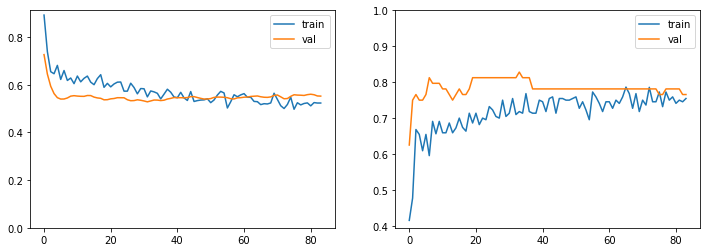

In [40]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 17. Dark Tinted Lenses

315 of 315
136 of 136
(360, 160, 160, 3) float32
(360,) int32
(91, 160, 160, 3) float32
(91,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 26s 259ms/step - loss: 93.0323 - val_loss: 83.4176
Epoch 2/100
100/100 [==============================] - 23s 230ms/step - loss: 80.8941 - val_loss: 84.7774
Epoch 3/100
100/100 [==============================] - 23s 231ms/step - loss: 71.3826 - val_loss: 101.6694
Epoch 4/100
100/100 [==============================] - 23s 234ms/step - loss: 62.6387 - val_loss: 110.9106
Epoch 5/100
100/100 [==============================] - 23s 231ms/step - loss: 56.9922 - val_loss: 112.1990
Epoch 6/100
100/100 [==============================] - 23s 232ms/step - loss: 51.6639 - val_loss: 113.3665
Epoch 7/100
100/100 [==============================] - 23s 233ms/step - loss: 45.6822 - val_loss: 104.6736
Epoch 8/100
100/100 [==============================] - 23s 231ms/step - loss: 37.7573 - val_loss: 104.2432
Epoch 9/100
100/100 [==============================] - 23s 231ms/step - loss: 31.3741 - val_loss: 104.2742
Epoch 10/100
100/100 [=================

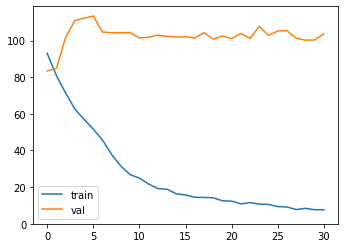

In [41]:
REQ_NAME = 'dark_tinted_lenses'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
15/15 [==============================] - 5s 333ms/step - loss: 0.7606 - accuracy: 0.4521 - precision: 0.4622 - recall: 0.5331 - f1: 0.4851 - specificity: 0.3797 - negative_predictive_value: 0.4483 - matthews_correlation_coefficient: -0.0883 - equal_error_rate: 0.5433 - val_loss: 0.7420 - val_accuracy: 0.3854 - val_precision: 0.4282 - val_recall: 0.6501 - val_f1: 0.5126 - val_specificity: 0.1293 - val_negative_predictive_value: 0.2587 - val_matthews_correlation_coefficient: -0.2623 - val_equal_error_rate: 0.5620

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.26225, saving model to ../../models/siamese_networks/dark_tinted_lenses_2020_06_08-04_19_16.h5
Epoch 2/100
15/15 [==============================] - 2s 146ms/step - loss: 0.7162 - accuracy: 0.5403 - precision: 0.5270 - recall: 0.6118 - f1: 0.5582 - specificity: 0.4725 - negative_predictive_value: 0.5548 - matthews_correlation_coefficient: 0.0830 - equal_error_rate: 0.4510 - val_loss: 0.7188 - 


Epoch 00013: val_matthews_correlation_coefficient did not improve from -0.00288
Epoch 14/100
15/15 [==============================] - 2s 145ms/step - loss: 0.6944 - accuracy: 0.5403 - precision: 0.5278 - recall: 0.6237 - f1: 0.5665 - specificity: 0.4587 - negative_predictive_value: 0.5533 - matthews_correlation_coefficient: 0.0817 - equal_error_rate: 0.4776 - val_loss: 0.7151 - val_accuracy: 0.5000 - val_precision: 0.4965 - val_recall: 0.6581 - val_f1: 0.5652 - val_specificity: 0.3366 - val_negative_predictive_value: 0.5034 - val_matthews_correlation_coefficient: -0.0029 - val_equal_error_rate: 0.5316

Epoch 00014: val_matthews_correlation_coefficient did not improve from -0.00288
Epoch 15/100
15/15 [==============================] - 2s 144ms/step - loss: 0.6980 - accuracy: 0.5360 - precision: 0.5450 - recall: 0.5436 - f1: 0.5361 - specificity: 0.5235 - negative_predictive_value: 0.5205 - matthews_correlation_coefficient: 0.0663 - equal_error_rate: 0.4574 - val_loss: 0.7143 - val_accu

15/15 [==============================] - 2s 141ms/step - loss: 0.6977 - accuracy: 0.5127 - precision: 0.5104 - recall: 0.5172 - f1: 0.5086 - specificity: 0.5054 - negative_predictive_value: 0.5125 - matthews_correlation_coefficient: 0.0228 - equal_error_rate: 0.4841 - val_loss: 0.7222 - val_accuracy: 0.4688 - val_precision: 0.4721 - val_recall: 0.5979 - val_f1: 0.5259 - val_specificity: 0.3366 - val_negative_predictive_value: 0.4610 - val_matthews_correlation_coefficient: -0.0662 - val_equal_error_rate: 0.5316

Epoch 00027: val_matthews_correlation_coefficient did not improve from -0.00288
Epoch 28/100
15/15 [==============================] - 2s 142ms/step - loss: 0.6796 - accuracy: 0.5466 - precision: 0.5466 - recall: 0.5465 - f1: 0.5374 - specificity: 0.5564 - negative_predictive_value: 0.5548 - matthews_correlation_coefficient: 0.1022 - equal_error_rate: 0.4600 - val_loss: 0.7222 - val_accuracy: 0.4688 - val_precision: 0.4721 - val_recall: 0.5979 - val_f1: 0.5259 - val_specificity: 


Epoch 00040: val_matthews_correlation_coefficient did not improve from -0.00288
Epoch 41/100
15/15 [==============================] - 2s 141ms/step - loss: 0.6596 - accuracy: 0.5678 - precision: 0.5744 - recall: 0.5717 - f1: 0.5662 - specificity: 0.5662 - negative_predictive_value: 0.5636 - matthews_correlation_coefficient: 0.1380 - equal_error_rate: 0.4076 - val_loss: 0.7186 - val_accuracy: 0.4792 - val_precision: 0.4833 - val_recall: 0.5817 - val_f1: 0.5263 - val_specificity: 0.3760 - val_negative_predictive_value: 0.4722 - val_matthews_correlation_coefficient: -0.0434 - val_equal_error_rate: 0.5104

Epoch 00041: val_matthews_correlation_coefficient did not improve from -0.00288
Epoch 42/100
15/15 [==============================] - 2s 141ms/step - loss: 0.6684 - accuracy: 0.5508 - precision: 0.5483 - recall: 0.5606 - f1: 0.5492 - specificity: 0.5330 - negative_predictive_value: 0.5432 - matthews_correlation_coefficient: 0.0926 - equal_error_rate: 0.4581 - val_loss: 0.7179 - val_accu

15/15 [==============================] - 2s 142ms/step - loss: 0.6605 - accuracy: 0.5805 - precision: 0.5836 - recall: 0.5601 - f1: 0.5669 - specificity: 0.5911 - negative_predictive_value: 0.5659 - matthews_correlation_coefficient: 0.1503 - equal_error_rate: 0.4240 - val_loss: 0.7225 - val_accuracy: 0.4688 - val_precision: 0.4735 - val_recall: 0.5608 - val_f1: 0.5115 - val_specificity: 0.3760 - val_negative_predictive_value: 0.4611 - val_matthews_correlation_coefficient: -0.0642 - val_equal_error_rate: 0.5104

Epoch 00054: val_matthews_correlation_coefficient did not improve from -0.00288
Epoch 55/100
15/15 [==============================] - 2s 141ms/step - loss: 0.6576 - accuracy: 0.6081 - precision: 0.6035 - recall: 0.6173 - f1: 0.6006 - specificity: 0.6101 - negative_predictive_value: 0.6228 - matthews_correlation_coefficient: 0.2265 - equal_error_rate: 0.3839 - val_loss: 0.7234 - val_accuracy: 0.4896 - val_precision: 0.4905 - val_recall: 0.6002 - val_f1: 0.5385 - val_specificity: 

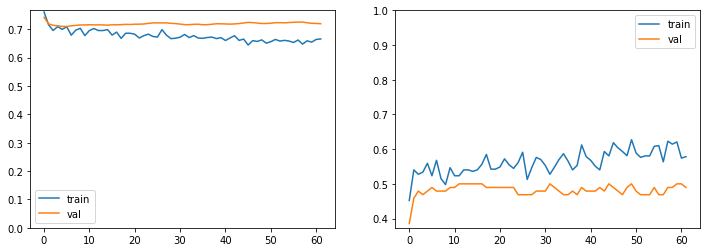

In [42]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 18. Flash Reflection on Lenses

437 of 437
363 of 363
(639, 160, 160, 3) float32
(639,) int32
(161, 160, 160, 3) float32
(161,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 28s 277ms/step - loss: 88.9155 - val_loss: 78.8737
Epoch 2/100
100/100 [==============================] - 25s 247ms/step - loss: 69.1826 - val_loss: 89.1956
Epoch 3/100
100/100 [==============================] - 25s 247ms/step - loss: 59.3616 - val_loss: 96.1052
Epoch 4/100
100/100 [==============================] - 25s 247ms/step - loss: 56.0759 - val_loss: 105.3374
Epoch 5/100
100/100 [==============================] - 25s 247ms/step - loss: 51.6511 - val_loss: 97.1892
Epoch 6/100
100/100 [==============================] - 25s 247ms/step - loss: 45.5073 - val_loss: 105.1524
Epoch 7/100
100/100 [==============================] - 25s 246ms/step - loss: 42.9088 - val_loss: 100.8407
Epoch 8/100
100/100 [==============================] - 25s 247ms/step - loss: 33.0712 - val_loss: 98.0648
Epoch 9/100
100/100 [==============================] - 25s 247ms/step - loss: 34.9448 - val_loss: 101.9524
Epoch 10/100
100/100 [====================

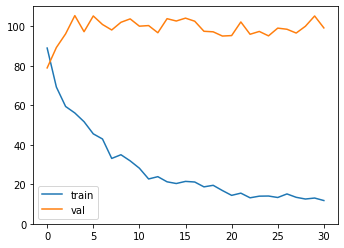

In [43]:
REQ_NAME = 'flash_reflection_on_lenses'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
21/21 [==============================] - 6s 291ms/step - loss: 0.7224 - accuracy: 0.4881 - precision: 0.4893 - recall: 0.5439 - f1: 0.5092 - specificity: 0.4326 - negative_predictive_value: 0.4860 - matthews_correlation_coefficient: -0.0241 - equal_error_rate: 0.4969 - val_loss: 0.6823 - val_accuracy: 0.5875 - val_precision: 0.6023 - val_recall: 0.4548 - val_f1: 0.5089 - val_specificity: 0.7145 - val_negative_predictive_value: 0.5800 - val_matthews_correlation_coefficient: 0.1757 - val_equal_error_rate: 0.4009

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.17569, saving model to ../../models/siamese_networks/flash_reflection_on_lenses_2020_06_08-04_37_25.h5
Epoch 2/100
21/21 [==============================] - 3s 144ms/step - loss: 0.6674 - accuracy: 0.5796 - precision: 0.5898 - recall: 0.6216 - f1: 0.5954 - specificity: 0.5496 - negative_predictive_value: 0.5813 - matthews_correlation_coefficient: 0.1712 - equal_error_rate: 0.4048 - val_loss: 0.6

21/21 [==============================] - 3s 142ms/step - loss: 0.6738 - accuracy: 0.5916 - precision: 0.5986 - recall: 0.6023 - f1: 0.5899 - specificity: 0.5958 - negative_predictive_value: 0.5976 - matthews_correlation_coefficient: 0.1971 - equal_error_rate: 0.3951 - val_loss: 0.6675 - val_accuracy: 0.5813 - val_precision: 0.6844 - val_recall: 0.3162 - val_f1: 0.4258 - val_specificity: 0.8504 - val_negative_predictive_value: 0.5539 - val_matthews_correlation_coefficient: 0.1987 - val_equal_error_rate: 0.3944

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.22076
Epoch 15/100
21/21 [==============================] - 3s 141ms/step - loss: 0.6606 - accuracy: 0.5841 - precision: 0.5834 - recall: 0.6136 - f1: 0.5897 - specificity: 0.5653 - negative_predictive_value: 0.5930 - matthews_correlation_coefficient: 0.1776 - equal_error_rate: 0.4057 - val_loss: 0.6670 - val_accuracy: 0.5750 - val_precision: 0.6733 - val_recall: 0.3020 - val_f1: 0.4116 - val_specificity: 0.

21/21 [==============================] - 3s 140ms/step - loss: 0.6482 - accuracy: 0.6231 - precision: 0.6456 - recall: 0.5924 - f1: 0.6040 - specificity: 0.6650 - negative_predictive_value: 0.6158 - matthews_correlation_coefficient: 0.2590 - equal_error_rate: 0.3834 - val_loss: 0.6732 - val_accuracy: 0.5875 - val_precision: 0.7222 - val_recall: 0.3020 - val_f1: 0.4195 - val_specificity: 0.8771 - val_negative_predictive_value: 0.5562 - val_matthews_correlation_coefficient: 0.2224 - val_equal_error_rate: 0.3806

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.24429
Epoch 28/100
21/21 [==============================] - 3s 138ms/step - loss: 0.6495 - accuracy: 0.6246 - precision: 0.6455 - recall: 0.6068 - f1: 0.6172 - specificity: 0.6477 - negative_predictive_value: 0.6114 - matthews_correlation_coefficient: 0.2556 - equal_error_rate: 0.3754 - val_loss: 0.6724 - val_accuracy: 0.5875 - val_precision: 0.7389 - val_recall: 0.2914 - val_f1: 0.4077 - val_specificity: 0.


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.24429
Epoch 41/100
21/21 [==============================] - 3s 141ms/step - loss: 0.6447 - accuracy: 0.6276 - precision: 0.6453 - recall: 0.6022 - f1: 0.6139 - specificity: 0.6630 - negative_predictive_value: 0.6200 - matthews_correlation_coefficient: 0.2652 - equal_error_rate: 0.3710 - val_loss: 0.6785 - val_accuracy: 0.5875 - val_precision: 0.7433 - val_recall: 0.2902 - val_f1: 0.4105 - val_specificity: 0.8925 - val_negative_predictive_value: 0.5558 - val_matthews_correlation_coefficient: 0.2331 - val_equal_error_rate: 0.3819

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.24429
Epoch 42/100
21/21 [==============================] - 3s 140ms/step - loss: 0.6498 - accuracy: 0.6306 - precision: 0.6364 - recall: 0.6097 - f1: 0.6130 - specificity: 0.6568 - negative_predictive_value: 0.6307 - matthews_correlation_coefficient: 0.2666 - equal_error_rate: 0.3634 - val_loss: 0.6758 - val_accurac

21/21 [==============================] - 3s 139ms/step - loss: 0.6239 - accuracy: 0.6757 - precision: 0.7049 - recall: 0.6160 - f1: 0.6496 - specificity: 0.7413 - negative_predictive_value: 0.6541 - matthews_correlation_coefficient: 0.3581 - equal_error_rate: 0.3306 - val_loss: 0.6760 - val_accuracy: 0.5938 - val_precision: 0.7317 - val_recall: 0.3125 - val_f1: 0.4338 - val_specificity: 0.8813 - val_negative_predictive_value: 0.5601 - val_matthews_correlation_coefficient: 0.2378 - val_equal_error_rate: 0.3808

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.25811
Epoch 55/100
21/21 [==============================] - 3s 136ms/step - loss: 0.6381 - accuracy: 0.6321 - precision: 0.6666 - recall: 0.5683 - f1: 0.6007 - specificity: 0.7068 - negative_predictive_value: 0.6222 - matthews_correlation_coefficient: 0.2817 - equal_error_rate: 0.3551 - val_loss: 0.6783 - val_accuracy: 0.5875 - val_precision: 0.7251 - val_recall: 0.3020 - val_f1: 0.4204 - val_specificity: 0.


Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.25811
Epoch 68/100
21/21 [==============================] - 3s 138ms/step - loss: 0.6456 - accuracy: 0.6321 - precision: 0.6533 - recall: 0.5940 - f1: 0.6135 - specificity: 0.6788 - negative_predictive_value: 0.6198 - matthews_correlation_coefficient: 0.2729 - equal_error_rate: 0.3624 - val_loss: 0.6747 - val_accuracy: 0.5938 - val_precision: 0.6992 - val_recall: 0.3348 - val_f1: 0.4498 - val_specificity: 0.8547 - val_negative_predictive_value: 0.5612 - val_matthews_correlation_coefficient: 0.2219 - val_equal_error_rate: 0.3874

Epoch 00068: val_matthews_correlation_coefficient did not improve from 0.25811
Epoch 69/100
21/21 [==============================] - 3s 139ms/step - loss: 0.6423 - accuracy: 0.6336 - precision: 0.6457 - recall: 0.5907 - f1: 0.6090 - specificity: 0.6778 - negative_predictive_value: 0.6263 - matthews_correlation_coefficient: 0.2701 - equal_error_rate: 0.3765 - val_loss: 0.6773 - val_accurac

21/21 [==============================] - 3s 139ms/step - loss: 0.6419 - accuracy: 0.6562 - precision: 0.6880 - recall: 0.5846 - f1: 0.6243 - specificity: 0.7293 - negative_predictive_value: 0.6339 - matthews_correlation_coefficient: 0.3177 - equal_error_rate: 0.3639 - val_loss: 0.6783 - val_accuracy: 0.5875 - val_precision: 0.6937 - val_recall: 0.3230 - val_f1: 0.4381 - val_specificity: 0.8547 - val_negative_predictive_value: 0.5565 - val_matthews_correlation_coefficient: 0.2107 - val_equal_error_rate: 0.3874

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.25811
Epoch 82/100
21/21 [==============================] - 3s 137ms/step - loss: 0.6275 - accuracy: 0.6396 - precision: 0.6647 - recall: 0.5776 - f1: 0.6124 - specificity: 0.7059 - negative_predictive_value: 0.6193 - matthews_correlation_coefficient: 0.2836 - equal_error_rate: 0.3537 - val_loss: 0.6789 - val_accuracy: 0.5875 - val_precision: 0.6937 - val_recall: 0.3230 - val_f1: 0.4381 - val_specificity: 0.


Epoch 00094: val_matthews_correlation_coefficient did not improve from 0.25811
Epoch 95/100
21/21 [==============================] - 3s 136ms/step - loss: 0.6306 - accuracy: 0.6667 - precision: 0.6981 - recall: 0.5943 - f1: 0.6370 - specificity: 0.7420 - negative_predictive_value: 0.6428 - matthews_correlation_coefficient: 0.3385 - equal_error_rate: 0.3482 - val_loss: 0.6782 - val_accuracy: 0.5875 - val_precision: 0.6937 - val_recall: 0.3230 - val_f1: 0.4381 - val_specificity: 0.8547 - val_negative_predictive_value: 0.5565 - val_matthews_correlation_coefficient: 0.2107 - val_equal_error_rate: 0.3874

Epoch 00095: val_matthews_correlation_coefficient did not improve from 0.25811
Epoch 96/100
21/21 [==============================] - 3s 138ms/step - loss: 0.6419 - accuracy: 0.6486 - precision: 0.6831 - recall: 0.5580 - f1: 0.6088 - specificity: 0.7305 - negative_predictive_value: 0.6209 - matthews_correlation_coefficient: 0.2959 - equal_error_rate: 0.3822 - val_loss: 0.6761 - val_accurac

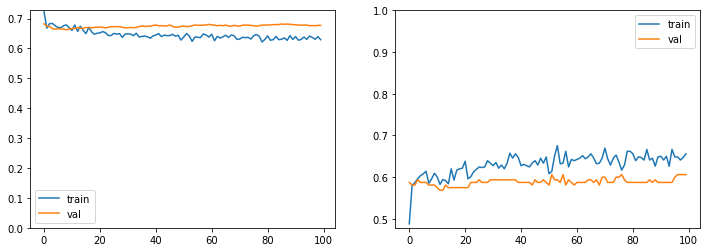

In [44]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### ~~19. Frames Too Heavy~~

#### 20. Frame Covering Eyes  

334 of 334
211 of 211
(435, 160, 160, 3) float32
(435,) int32
(110, 160, 160, 3) float32
(110,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 28s 280ms/step - loss: 98.3158 - val_loss: 88.1995
Epoch 2/100
100/100 [==============================] - 25s 246ms/step - loss: 86.4212 - val_loss: 65.6845
Epoch 3/100
100/100 [==============================] - 25s 246ms/step - loss: 74.3335 - val_loss: 66.7377
Epoch 4/100
100/100 [==============================] - 25s 246ms/step - loss: 65.4010 - val_loss: 66.7548
Epoch 5/100
100/100 [==============================] - 25s 246ms/step - loss: 57.0750 - val_loss: 70.2341
Epoch 6/100
100/100 [==============================] - 25s 246ms/step - loss: 47.9369 - val_loss: 71.2245
Epoch 7/100
100/100 [==============================] - 25s 246ms/step - loss: 39.6096 - val_loss: 76.0995
Epoch 8/100
100/100 [==============================] - 25s 246ms/step - loss: 34.2875 - val_loss: 76.1993
Epoch 9/100
100/100 [==============================] - 25s 246ms/step - loss: 30.3415 - val_loss: 70.5936
Epoch 10/100
100/100 [========================

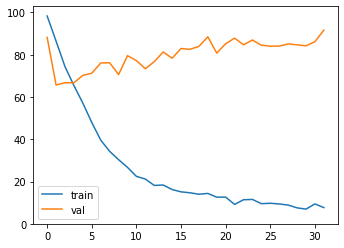

In [45]:
REQ_NAME = 'frame_covering_eyes'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
16/16 [==============================] - 6s 363ms/step - loss: 0.7114 - accuracy: 0.5254 - precision: 0.5188 - recall: 0.6710 - f1: 0.5767 - specificity: 0.3835 - negative_predictive_value: 0.5387 - matthews_correlation_coefficient: 0.0561 - equal_error_rate: 0.4825 - val_loss: 0.7314 - val_accuracy: 0.6250 - val_precision: 0.6458 - val_recall: 0.5262 - val_f1: 0.5772 - val_specificity: 0.7178 - val_negative_predictive_value: 0.5999 - val_matthews_correlation_coefficient: 0.2447 - val_equal_error_rate: 0.3701

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.24469, saving model to ../../models/siamese_networks/frame_covering_eyes_2020_06_08-04_58_33.h5
Epoch 2/100
16/16 [==============================] - 2s 154ms/step - loss: 0.6840 - accuracy: 0.6076 - precision: 0.6382 - recall: 0.4899 - f1: 0.5473 - specificity: 0.7187 - negative_predictive_value: 0.5807 - matthews_correlation_coefficient: 0.2136 - equal_error_rate: 0.4322 - val_loss: 0.7508 - va

16/16 [==============================] - 2s 134ms/step - loss: 0.6607 - accuracy: 0.6235 - precision: 0.6689 - recall: 0.5013 - f1: 0.5705 - specificity: 0.7415 - negative_predictive_value: 0.5912 - matthews_correlation_coefficient: 0.2511 - equal_error_rate: 0.3811 - val_loss: 0.7273 - val_accuracy: 0.6406 - val_precision: 0.7083 - val_recall: 0.4690 - val_f1: 0.5632 - val_specificity: 0.8124 - val_negative_predictive_value: 0.6011 - val_matthews_correlation_coefficient: 0.2949 - val_equal_error_rate: 0.3814

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.29605
Epoch 15/100
16/16 [==============================] - 2s 134ms/step - loss: 0.6575 - accuracy: 0.6454 - precision: 0.6991 - recall: 0.5169 - f1: 0.5867 - specificity: 0.7789 - negative_predictive_value: 0.6160 - matthews_correlation_coefficient: 0.3046 - equal_error_rate: 0.3814 - val_loss: 0.7299 - val_accuracy: 0.6406 - val_precision: 0.7083 - val_recall: 0.4690 - val_f1: 0.5632 - val_specificity: 0.

16/16 [==============================] - 2s 138ms/step - loss: 0.6300 - accuracy: 0.6434 - precision: 0.6863 - recall: 0.5220 - f1: 0.5897 - specificity: 0.7563 - negative_predictive_value: 0.6068 - matthews_correlation_coefficient: 0.2854 - equal_error_rate: 0.3544 - val_loss: 0.7203 - val_accuracy: 0.6484 - val_precision: 0.7115 - val_recall: 0.4810 - val_f1: 0.5734 - val_specificity: 0.8124 - val_negative_predictive_value: 0.6071 - val_matthews_correlation_coefficient: 0.3054 - val_equal_error_rate: 0.3428

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.30539
Epoch 28/100
16/16 [==============================] - 2s 137ms/step - loss: 0.6468 - accuracy: 0.6414 - precision: 0.6892 - recall: 0.5235 - f1: 0.5898 - specificity: 0.7612 - negative_predictive_value: 0.6064 - matthews_correlation_coefficient: 0.2899 - equal_error_rate: 0.3758 - val_loss: 0.7127 - val_accuracy: 0.6406 - val_precision: 0.6979 - val_recall: 0.4810 - val_f1: 0.5688 - val_specificity: 0.


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.30539
Epoch 41/100
16/16 [==============================] - 2s 131ms/step - loss: 0.6260 - accuracy: 0.6474 - precision: 0.7055 - recall: 0.5132 - f1: 0.5911 - specificity: 0.7811 - negative_predictive_value: 0.6090 - matthews_correlation_coefficient: 0.3040 - equal_error_rate: 0.3653 - val_loss: 0.7211 - val_accuracy: 0.6484 - val_precision: 0.7115 - val_recall: 0.4810 - val_f1: 0.5734 - val_specificity: 0.8124 - val_negative_predictive_value: 0.6071 - val_matthews_correlation_coefficient: 0.3054 - val_equal_error_rate: 0.3428

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.30539
Epoch 42/100
16/16 [==============================] - 2s 135ms/step - loss: 0.6259 - accuracy: 0.6434 - precision: 0.6775 - recall: 0.5425 - f1: 0.5963 - specificity: 0.7504 - negative_predictive_value: 0.6279 - matthews_correlation_coefficient: 0.2988 - equal_error_rate: 0.3572 - val_loss: 0.7171 - val_accurac

16/16 [==============================] - 2s 136ms/step - loss: 0.6279 - accuracy: 0.6494 - precision: 0.7056 - recall: 0.5253 - f1: 0.5977 - specificity: 0.7812 - negative_predictive_value: 0.6161 - matthews_correlation_coefficient: 0.3139 - equal_error_rate: 0.3521 - val_loss: 0.7024 - val_accuracy: 0.6406 - val_precision: 0.6979 - val_recall: 0.4810 - val_f1: 0.5688 - val_specificity: 0.7977 - val_negative_predictive_value: 0.6022 - val_matthews_correlation_coefficient: 0.2889 - val_equal_error_rate: 0.3018

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.30552
Epoch 55/100
16/16 [==============================] - 2s 138ms/step - loss: 0.6321 - accuracy: 0.6534 - precision: 0.6933 - recall: 0.5179 - f1: 0.5898 - specificity: 0.7789 - negative_predictive_value: 0.6214 - matthews_correlation_coefficient: 0.3053 - equal_error_rate: 0.3666 - val_loss: 0.6991 - val_accuracy: 0.6406 - val_precision: 0.6979 - val_recall: 0.4810 - val_f1: 0.5688 - val_specificity: 0.


Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.30552
Epoch 68/100
16/16 [==============================] - 2s 137ms/step - loss: 0.6259 - accuracy: 0.6494 - precision: 0.6957 - recall: 0.5314 - f1: 0.5964 - specificity: 0.7692 - negative_predictive_value: 0.6182 - matthews_correlation_coefficient: 0.3069 - equal_error_rate: 0.3464 - val_loss: 0.6882 - val_accuracy: 0.6484 - val_precision: 0.7074 - val_recall: 0.4976 - val_f1: 0.5831 - val_specificity: 0.7977 - val_negative_predictive_value: 0.6093 - val_matthews_correlation_coefficient: 0.3055 - val_equal_error_rate: 0.3088

Epoch 00068: val_matthews_correlation_coefficient did not improve from 0.30552
Epoch 69/100
16/16 [==============================] - 2s 138ms/step - loss: 0.6315 - accuracy: 0.6289 - precision: 0.6577 - recall: 0.5215 - f1: 0.5767 - specificity: 0.7426 - negative_predictive_value: 0.6103 - matthews_correlation_coefficient: 0.2661 - equal_error_rate: 0.3538 - val_loss: 0.6837 - val_accurac

16/16 [==============================] - 2s 136ms/step - loss: 0.6191 - accuracy: 0.6574 - precision: 0.6929 - recall: 0.5376 - f1: 0.6010 - specificity: 0.7727 - negative_predictive_value: 0.6329 - matthews_correlation_coefficient: 0.3178 - equal_error_rate: 0.3466 - val_loss: 0.6891 - val_accuracy: 0.6484 - val_precision: 0.7074 - val_recall: 0.4976 - val_f1: 0.5831 - val_specificity: 0.7977 - val_negative_predictive_value: 0.6093 - val_matthews_correlation_coefficient: 0.3055 - val_equal_error_rate: 0.2855

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.30552
Epoch 82/100
16/16 [==============================] - 2s 134ms/step - loss: 0.6279 - accuracy: 0.6633 - precision: 0.7223 - recall: 0.5423 - f1: 0.6162 - specificity: 0.7897 - negative_predictive_value: 0.6255 - matthews_correlation_coefficient: 0.3397 - equal_error_rate: 0.3572 - val_loss: 0.6866 - val_accuracy: 0.6484 - val_precision: 0.7074 - val_recall: 0.4976 - val_f1: 0.5831 - val_specificity: 0.


Epoch 00094: val_matthews_correlation_coefficient did not improve from 0.30552
Epoch 95/100
16/16 [==============================] - 2s 136ms/step - loss: 0.6199 - accuracy: 0.6474 - precision: 0.6787 - recall: 0.5378 - f1: 0.5949 - specificity: 0.7508 - negative_predictive_value: 0.6174 - matthews_correlation_coefficient: 0.2922 - equal_error_rate: 0.3646 - val_loss: 0.6899 - val_accuracy: 0.6406 - val_precision: 0.6979 - val_recall: 0.4810 - val_f1: 0.5688 - val_specificity: 0.7977 - val_negative_predictive_value: 0.6022 - val_matthews_correlation_coefficient: 0.2889 - val_equal_error_rate: 0.2772

Epoch 00095: val_matthews_correlation_coefficient did not improve from 0.30552
Epoch 96/100
16/16 [==============================] - 2s 139ms/step - loss: 0.6170 - accuracy: 0.6633 - precision: 0.7059 - recall: 0.5709 - f1: 0.6270 - specificity: 0.7586 - negative_predictive_value: 0.6299 - matthews_correlation_coefficient: 0.3325 - equal_error_rate: 0.3378 - val_loss: 0.6954 - val_accurac

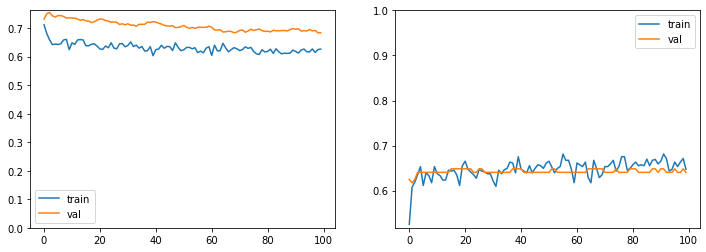

In [46]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 21. Hat/cap 

900 of 900
846 of 846
(1396, 160, 160, 3) float32
(1396,) int32
(350, 160, 160, 3) float32
(350,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 28s 281ms/step - loss: 96.6628 - val_loss: 70.9004
Epoch 2/100
100/100 [==============================] - 24s 244ms/step - loss: 80.1778 - val_loss: 60.1959
Epoch 3/100
100/100 [==============================] - 24s 244ms/step - loss: 74.6030 - val_loss: 59.4968
Epoch 4/100
100/100 [==============================] - 24s 244ms/step - loss: 70.8421 - val_loss: 54.8681
Epoch 5/100
100/100 [==============================] - 24s 245ms/step - loss: 66.0756 - val_loss: 55.6090
Epoch 6/100
100/100 [==============================] - 25s 249ms/step - loss: 59.4471 - val_loss: 57.6372
Epoch 7/100
100/100 [==============================] - 25s 246ms/step - loss: 52.1269 - val_loss: 51.8524
Epoch 8/100
100/100 [==============================] - 24s 245ms/step - loss: 45.2531 - val_loss: 50.1677
Epoch 9/100
100/100 [==============================] - 25s 245ms/step - loss: 38.3254 - val_loss: 44.4125
Epoch 10/100
100/100 [========================

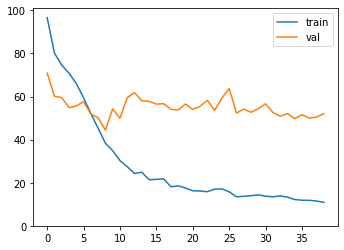

In [47]:
REQ_NAME = 'hat_cap'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
45/45 [==============================] - 9s 208ms/step - loss: 0.7302 - accuracy: 0.5917 - precision: 0.6167 - recall: 0.4113 - f1: 0.4749 - specificity: 0.7575 - negative_predictive_value: 0.5713 - matthews_correlation_coefficient: 0.1770 - equal_error_rate: 0.4009 - val_loss: 0.5455 - val_accuracy: 0.6619 - val_precision: 0.7111 - val_recall: 0.5303 - val_f1: 0.6009 - val_specificity: 0.7777 - val_negative_predictive_value: 0.6250 - val_matthews_correlation_coefficient: 0.3211 - val_equal_error_rate: 0.3669

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.32107, saving model to ../../models/siamese_networks/hat_cap_2020_06_08-05_22_33.h5
Epoch 2/100
45/45 [==============================] - 6s 134ms/step - loss: 0.6346 - accuracy: 0.6438 - precision: 0.7012 - recall: 0.4993 - f1: 0.5725 - specificity: 0.7822 - negative_predictive_value: 0.6114 - matthews_correlation_coefficient: 0.2957 - equal_error_rate: 0.3719 - val_loss: 0.5565 - val_accuracy: 


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.39562
Epoch 14/100
45/45 [==============================] - 6s 132ms/step - loss: 0.5912 - accuracy: 0.6611 - precision: 0.7410 - recall: 0.5026 - f1: 0.5862 - specificity: 0.8146 - negative_predictive_value: 0.6231 - matthews_correlation_coefficient: 0.3373 - equal_error_rate: 0.3314 - val_loss: 0.5148 - val_accuracy: 0.6847 - val_precision: 0.7780 - val_recall: 0.4950 - val_f1: 0.5911 - val_specificity: 0.8682 - val_negative_predictive_value: 0.6383 - val_matthews_correlation_coefficient: 0.3871 - val_equal_error_rate: 0.3187

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.39562
Epoch 15/100
45/45 [==============================] - 6s 130ms/step - loss: 0.5791 - accuracy: 0.6965 - precision: 0.8009 - recall: 0.5339 - f1: 0.6270 - specificity: 0.8543 - negative_predictive_value: 0.6503 - matthews_correlation_coefficient: 0.4163 - equal_error_rate: 0.3343 - val_loss: 0.5129 - val_accurac

45/45 [==============================] - 6s 132ms/step - loss: 0.5785 - accuracy: 0.6743 - precision: 0.7577 - recall: 0.5158 - f1: 0.6024 - specificity: 0.8287 - negative_predictive_value: 0.6336 - matthews_correlation_coefficient: 0.3660 - equal_error_rate: 0.3294 - val_loss: 0.4884 - val_accuracy: 0.7017 - val_precision: 0.8047 - val_recall: 0.5032 - val_f1: 0.6077 - val_specificity: 0.8876 - val_negative_predictive_value: 0.6492 - val_matthews_correlation_coefficient: 0.4195 - val_equal_error_rate: 0.3073

Epoch 00027: val_matthews_correlation_coefficient improved from 0.40932 to 0.41954, saving model to ../../models/siamese_networks/hat_cap_2020_06_08-05_22_33.h5
Epoch 28/100
45/45 [==============================] - 6s 133ms/step - loss: 0.5748 - accuracy: 0.6771 - precision: 0.7428 - recall: 0.5257 - f1: 0.6055 - specificity: 0.8219 - negative_predictive_value: 0.6399 - matthews_correlation_coefficient: 0.3639 - equal_error_rate: 0.3322 - val_loss: 0.4847 - val_accuracy: 0.6932 -

45/45 [==============================] - 6s 133ms/step - loss: 0.5672 - accuracy: 0.6938 - precision: 0.7808 - recall: 0.5564 - f1: 0.6310 - specificity: 0.8302 - negative_predictive_value: 0.6578 - matthews_correlation_coefficient: 0.4090 - equal_error_rate: 0.3255 - val_loss: 0.4800 - val_accuracy: 0.6903 - val_precision: 0.7759 - val_recall: 0.4967 - val_f1: 0.5928 - val_specificity: 0.8693 - val_negative_predictive_value: 0.6424 - val_matthews_correlation_coefficient: 0.3900 - val_equal_error_rate: 0.2922

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.41954
Epoch 41/100
45/45 [==============================] - 6s 130ms/step - loss: 0.5690 - accuracy: 0.6889 - precision: 0.7601 - recall: 0.5365 - f1: 0.6219 - specificity: 0.8334 - negative_predictive_value: 0.6462 - matthews_correlation_coefficient: 0.3870 - equal_error_rate: 0.3192 - val_loss: 0.4853 - val_accuracy: 0.6932 - val_precision: 0.7761 - val_recall: 0.5102 - val_f1: 0.6047 - val_specificity: 0.

45/45 [==============================] - 6s 133ms/step - loss: 0.5725 - accuracy: 0.6826 - precision: 0.7504 - recall: 0.5425 - f1: 0.6191 - specificity: 0.8203 - negative_predictive_value: 0.6455 - matthews_correlation_coefficient: 0.3780 - equal_error_rate: 0.3161 - val_loss: 0.4804 - val_accuracy: 0.7074 - val_precision: 0.8127 - val_recall: 0.5150 - val_f1: 0.6198 - val_specificity: 0.8876 - val_negative_predictive_value: 0.6537 - val_matthews_correlation_coefficient: 0.4318 - val_equal_error_rate: 0.3012

Epoch 00053: val_matthews_correlation_coefficient improved from 0.42600 to 0.43178, saving model to ../../models/siamese_networks/hat_cap_2020_06_08-05_22_33.h5
Epoch 54/100
45/45 [==============================] - 6s 133ms/step - loss: 0.5598 - accuracy: 0.6958 - precision: 0.7623 - recall: 0.5470 - f1: 0.6256 - specificity: 0.8383 - negative_predictive_value: 0.6560 - matthews_correlation_coefficient: 0.4010 - equal_error_rate: 0.3072 - val_loss: 0.4847 - val_accuracy: 0.6989 -

45/45 [==============================] - 6s 133ms/step - loss: 0.5622 - accuracy: 0.6903 - precision: 0.7656 - recall: 0.5453 - f1: 0.6243 - specificity: 0.8294 - negative_predictive_value: 0.6521 - matthews_correlation_coefficient: 0.3941 - equal_error_rate: 0.3082 - val_loss: 0.4633 - val_accuracy: 0.6989 - val_precision: 0.7972 - val_recall: 0.5015 - val_f1: 0.6057 - val_specificity: 0.8815 - val_negative_predictive_value: 0.6468 - val_matthews_correlation_coefficient: 0.4108 - val_equal_error_rate: 0.2953

Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.43178
Epoch 67/100
45/45 [==============================] - 6s 134ms/step - loss: 0.5645 - accuracy: 0.6833 - precision: 0.7543 - recall: 0.5575 - f1: 0.6259 - specificity: 0.8104 - negative_predictive_value: 0.6526 - matthews_correlation_coefficient: 0.3859 - equal_error_rate: 0.3107 - val_loss: 0.4767 - val_accuracy: 0.7074 - val_precision: 0.8111 - val_recall: 0.5214 - val_f1: 0.6247 - val_specificity: 0.

45/45 [==============================] - 6s 135ms/step - loss: 0.5619 - accuracy: 0.6861 - precision: 0.7517 - recall: 0.5480 - f1: 0.6205 - specificity: 0.8184 - negative_predictive_value: 0.6516 - matthews_correlation_coefficient: 0.3833 - equal_error_rate: 0.3149 - val_loss: 0.4698 - val_accuracy: 0.6989 - val_precision: 0.7841 - val_recall: 0.5192 - val_f1: 0.6176 - val_specificity: 0.8639 - val_negative_predictive_value: 0.6489 - val_matthews_correlation_coefficient: 0.4062 - val_equal_error_rate: 0.2904

Epoch 00079: val_matthews_correlation_coefficient did not improve from 0.44957
Epoch 80/100
45/45 [==============================] - 6s 132ms/step - loss: 0.5672 - accuracy: 0.6771 - precision: 0.7517 - recall: 0.5306 - f1: 0.6133 - specificity: 0.8168 - negative_predictive_value: 0.6361 - matthews_correlation_coefficient: 0.3658 - equal_error_rate: 0.3101 - val_loss: 0.4711 - val_accuracy: 0.7159 - val_precision: 0.8117 - val_recall: 0.5386 - val_f1: 0.6380 - val_specificity: 0.


Epoch 00092: val_matthews_correlation_coefficient did not improve from 0.44957
Epoch 93/100
45/45 [==============================] - 6s 133ms/step - loss: 0.5601 - accuracy: 0.7035 - precision: 0.7871 - recall: 0.5640 - f1: 0.6456 - specificity: 0.8419 - negative_predictive_value: 0.6608 - matthews_correlation_coefficient: 0.4251 - equal_error_rate: 0.3145 - val_loss: 0.4706 - val_accuracy: 0.6960 - val_precision: 0.7609 - val_recall: 0.5437 - val_f1: 0.6273 - val_specificity: 0.8382 - val_negative_predictive_value: 0.6528 - val_matthews_correlation_coefficient: 0.3967 - val_equal_error_rate: 0.3044

Epoch 00093: val_matthews_correlation_coefficient did not improve from 0.44957
Epoch 94/100
45/45 [==============================] - 6s 134ms/step - loss: 0.5651 - accuracy: 0.6938 - precision: 0.7692 - recall: 0.5522 - f1: 0.6302 - specificity: 0.8310 - negative_predictive_value: 0.6537 - matthews_correlation_coefficient: 0.4015 - equal_error_rate: 0.3202 - val_loss: 0.4666 - val_accurac

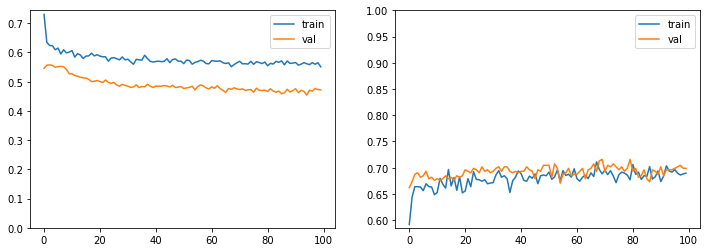

In [48]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### *22. Veil Over Face*

354 of 354
354 of 354
(566, 160, 160, 3) float32
(566,) int32
(142, 160, 160, 3) float32
(142,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 29s 289ms/step - loss: 76.3640 - val_loss: 52.6625
Epoch 2/100
100/100 [==============================] - 25s 251ms/step - loss: 34.8220 - val_loss: 47.3873
Epoch 3/100
100/100 [==============================] - 25s 251ms/step - loss: 19.5613 - val_loss: 47.7697
Epoch 4/100
100/100 [==============================] - 25s 251ms/step - loss: 12.4807 - val_loss: 49.7617
Epoch 5/100
100/100 [==============================] - 25s 251ms/step - loss: 8.4951 - val_loss: 50.1106
Epoch 6/100
100/100 [==============================] - 25s 250ms/step - loss: 6.5758 - val_loss: 50.0535
Epoch 7/100
100/100 [==============================] - 25s 254ms/step - loss: 4.2444 - val_loss: 50.3725
Epoch 8/100
100/100 [==============================] - 25s 252ms/step - loss: 3.5247 - val_loss: 50.7916
Epoch 9/100
100/100 [==============================] - 25s 252ms/step - loss: 3.7052 - val_loss: 49.8111
Epoch 10/100
100/100 [=============================

100/100 [==============================] - 25s 251ms/step - loss: 0.3379 - val_loss: 46.0424
Epoch 79/100
100/100 [==============================] - 25s 253ms/step - loss: 0.3393 - val_loss: 46.9326
Epoch 80/100
100/100 [==============================] - 25s 252ms/step - loss: 0.3678 - val_loss: 49.2408
Epoch 81/100
100/100 [==============================] - 25s 251ms/step - loss: 0.3888 - val_loss: 49.9020
Epoch 82/100
100/100 [==============================] - 25s 251ms/step - loss: 0.3499 - val_loss: 48.8581
Epoch 83/100
100/100 [==============================] - 25s 251ms/step - loss: 0.4525 - val_loss: 48.6197
Epoch 84/100
100/100 [==============================] - 25s 252ms/step - loss: 0.4805 - val_loss: 49.7819
Epoch 85/100
100/100 [==============================] - 25s 252ms/step - loss: 0.3912 - val_loss: 49.2560
Epoch 86/100
100/100 [==============================] - 25s 252ms/step - loss: 0.2506 - val_loss: 49.4354
Epoch 87/100
100/100 [==============================] - 25s

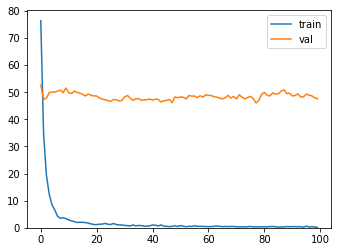

In [49]:
REQ_NAME = 'veil_over_face'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
17/17 [==============================] - 6s 370ms/step - loss: 0.7563 - accuracy: 0.5074 - precision: 0.5380 - recall: 0.4680 - f1: 0.4887 - specificity: 0.5366 - negative_predictive_value: 0.4738 - matthews_correlation_coefficient: 0.0081 - equal_error_rate: 0.4955 - val_loss: 0.8647 - val_accuracy: 0.4531 - val_precision: 0.4817 - val_recall: 0.8300 - val_f1: 0.5938 - val_specificity: 0.1062 - val_negative_predictive_value: 0.3929 - val_matthews_correlation_coefficient: -0.0870 - val_equal_error_rate: 0.5622

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.08702, saving model to ../../models/siamese_networks/veil_over_face_2020_06_08-06_17_55.h5
Epoch 2/100
17/17 [==============================] - 2s 137ms/step - loss: 0.5523 - accuracy: 0.7322 - precision: 0.8450 - recall: 0.5808 - f1: 0.6785 - specificity: 0.8687 - negative_predictive_value: 0.6721 - matthews_correlation_coefficient: 0.4807 - equal_error_rate: 0.2372 - val_loss: 1.1146 - val_a

17/17 [==============================] - 2s 128ms/step - loss: 0.3966 - accuracy: 0.8464 - precision: 0.9289 - recall: 0.7569 - f1: 0.8268 - specificity: 0.9304 - negative_predictive_value: 0.8053 - matthews_correlation_coefficient: 0.7100 - equal_error_rate: 0.1478 - val_loss: 1.0630 - val_accuracy: 0.4688 - val_precision: 0.4824 - val_recall: 0.8647 - val_f1: 0.6105 - val_specificity: 0.0645 - val_negative_predictive_value: 0.2667 - val_matthews_correlation_coefficient: -0.1295 - val_equal_error_rate: 0.3914

Epoch 00014: val_matthews_correlation_coefficient did not improve from -0.06630
Epoch 15/100
17/17 [==============================] - 2s 129ms/step - loss: 0.3651 - accuracy: 0.8502 - precision: 0.9381 - recall: 0.7579 - f1: 0.8283 - specificity: 0.9385 - negative_predictive_value: 0.8079 - matthews_correlation_coefficient: 0.7198 - equal_error_rate: 0.1124 - val_loss: 1.0282 - val_accuracy: 0.4766 - val_precision: 0.4870 - val_recall: 0.8814 - val_f1: 0.6183 - val_specificity: 


Epoch 00027: val_matthews_correlation_coefficient did not improve from -0.06630
Epoch 28/100
17/17 [==============================] - 2s 131ms/step - loss: 0.3130 - accuracy: 0.8652 - precision: 0.9397 - recall: 0.7781 - f1: 0.8447 - specificity: 0.9429 - negative_predictive_value: 0.8212 - matthews_correlation_coefficient: 0.7400 - equal_error_rate: 0.1089 - val_loss: 1.1262 - val_accuracy: 0.4688 - val_precision: 0.4817 - val_recall: 0.8814 - val_f1: 0.6146 - val_specificity: 0.0453 - val_negative_predictive_value: 0.2708 - val_matthews_correlation_coefficient: -0.1303 - val_equal_error_rate: 0.3757

Epoch 00028: val_matthews_correlation_coefficient did not improve from -0.06630
Epoch 29/100
17/17 [==============================] - 2s 142ms/step - loss: 0.2981 - accuracy: 0.8820 - precision: 0.9270 - recall: 0.8463 - f1: 0.8776 - specificity: 0.9081 - negative_predictive_value: 0.8616 - matthews_correlation_coefficient: 0.7706 - equal_error_rate: 0.1189 - val_loss: 1.1552 - val_accu

17/17 [==============================] - 2s 139ms/step - loss: 0.2735 - accuracy: 0.8895 - precision: 0.9365 - recall: 0.8402 - f1: 0.8809 - specificity: 0.9311 - negative_predictive_value: 0.8626 - matthews_correlation_coefficient: 0.7849 - equal_error_rate: 0.0946 - val_loss: 1.3098 - val_accuracy: 0.4766 - val_precision: 0.4842 - val_recall: 0.8814 - val_f1: 0.6173 - val_specificity: 0.0567 - val_negative_predictive_value: 0.3125 - val_matthews_correlation_coefficient: -0.1071 - val_equal_error_rate: 0.3600

Epoch 00041: val_matthews_correlation_coefficient did not improve from -0.06630
Epoch 42/100
17/17 [==============================] - 3s 149ms/step - loss: 0.2810 - accuracy: 0.8876 - precision: 0.9282 - recall: 0.8523 - f1: 0.8792 - specificity: 0.9118 - negative_predictive_value: 0.8758 - matthews_correlation_coefficient: 0.7831 - equal_error_rate: 0.0981 - val_loss: 1.2087 - val_accuracy: 0.4766 - val_precision: 0.4842 - val_recall: 0.8814 - val_f1: 0.6173 - val_specificity: 

17/17 [==============================] - 2s 146ms/step - loss: 0.2914 - accuracy: 0.8914 - precision: 0.9291 - recall: 0.8531 - f1: 0.8812 - specificity: 0.9263 - negative_predictive_value: 0.8842 - matthews_correlation_coefficient: 0.7957 - equal_error_rate: 0.1180 - val_loss: 1.2440 - val_accuracy: 0.4844 - val_precision: 0.4885 - val_recall: 0.8980 - val_f1: 0.6248 - val_specificity: 0.0567 - val_negative_predictive_value: 0.4375 - val_matthews_correlation_coefficient: -0.0609 - val_equal_error_rate: 0.3663

Epoch 00054: val_matthews_correlation_coefficient did not improve from -0.06089
Epoch 55/100
17/17 [==============================] - 3s 147ms/step - loss: 0.2822 - accuracy: 0.8750 - precision: 0.9270 - recall: 0.8175 - f1: 0.8610 - specificity: 0.9175 - negative_predictive_value: 0.8584 - matthews_correlation_coefficient: 0.7591 - equal_error_rate: 0.0994 - val_loss: 1.2286 - val_accuracy: 0.4844 - val_precision: 0.4885 - val_recall: 0.8980 - val_f1: 0.6248 - val_specificity: 

17/17 [==============================] - 3s 150ms/step - loss: 0.2563 - accuracy: 0.8914 - precision: 0.9157 - recall: 0.8642 - f1: 0.8842 - specificity: 0.9145 - negative_predictive_value: 0.8877 - matthews_correlation_coefficient: 0.7906 - equal_error_rate: 0.0998 - val_loss: 1.3479 - val_accuracy: 0.4844 - val_precision: 0.4885 - val_recall: 0.8980 - val_f1: 0.6248 - val_specificity: 0.0567 - val_negative_predictive_value: 0.4375 - val_matthews_correlation_coefficient: -0.0609 - val_equal_error_rate: 0.3663

Epoch 00067: val_matthews_correlation_coefficient did not improve from -0.02628
Epoch 68/100
17/17 [==============================] - 3s 149ms/step - loss: 0.2765 - accuracy: 0.8839 - precision: 0.9204 - recall: 0.8514 - f1: 0.8772 - specificity: 0.9082 - negative_predictive_value: 0.8711 - matthews_correlation_coefficient: 0.7750 - equal_error_rate: 0.1039 - val_loss: 1.2945 - val_accuracy: 0.4844 - val_precision: 0.4885 - val_recall: 0.8980 - val_f1: 0.6248 - val_specificity: 


Epoch 00080: val_matthews_correlation_coefficient did not improve from -0.02628
Epoch 81/100
17/17 [==============================] - 3s 147ms/step - loss: 0.2708 - accuracy: 0.8820 - precision: 0.9122 - recall: 0.8596 - f1: 0.8757 - specificity: 0.8967 - negative_predictive_value: 0.8769 - matthews_correlation_coefficient: 0.7721 - equal_error_rate: 0.1033 - val_loss: 1.2999 - val_accuracy: 0.4844 - val_precision: 0.4885 - val_recall: 0.8980 - val_f1: 0.6248 - val_specificity: 0.0567 - val_negative_predictive_value: 0.4375 - val_matthews_correlation_coefficient: -0.0609 - val_equal_error_rate: 0.3663

Epoch 00081: val_matthews_correlation_coefficient did not improve from -0.02628
Epoch 82/100
17/17 [==============================] - 3s 159ms/step - loss: 0.2722 - accuracy: 0.8783 - precision: 0.8947 - recall: 0.8667 - f1: 0.8739 - specificity: 0.8876 - negative_predictive_value: 0.8828 - matthews_correlation_coefficient: 0.7655 - equal_error_rate: 0.0960 - val_loss: 1.3197 - val_accu

17/17 [==============================] - 3s 156ms/step - loss: 0.2654 - accuracy: 0.8895 - precision: 0.9119 - recall: 0.8728 - f1: 0.8828 - specificity: 0.9017 - negative_predictive_value: 0.8916 - matthews_correlation_coefficient: 0.7877 - equal_error_rate: 0.0847 - val_loss: 1.3784 - val_accuracy: 0.4844 - val_precision: 0.4885 - val_recall: 0.8980 - val_f1: 0.6248 - val_specificity: 0.0567 - val_negative_predictive_value: 0.4375 - val_matthews_correlation_coefficient: -0.0609 - val_equal_error_rate: 0.3663

Epoch 00094: val_matthews_correlation_coefficient did not improve from -0.02628
Epoch 95/100
17/17 [==============================] - 3s 154ms/step - loss: 0.2342 - accuracy: 0.9157 - precision: 0.9323 - recall: 0.9012 - f1: 0.9134 - specificity: 0.9306 - negative_predictive_value: 0.9083 - matthews_correlation_coefficient: 0.8361 - equal_error_rate: 0.0773 - val_loss: 1.4284 - val_accuracy: 0.4844 - val_precision: 0.4885 - val_recall: 0.8980 - val_f1: 0.6248 - val_specificity: 

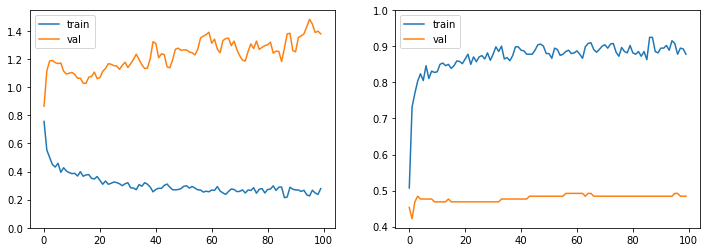

In [50]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 23. Mouth Open 

452 of 452
420 of 420
(697, 160, 160, 3) float32
(697,) int32
(175, 160, 160, 3) float32
(175,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 29s 292ms/step - loss: 93.8875 - val_loss: 93.5770
Epoch 2/100
100/100 [==============================] - 25s 247ms/step - loss: 78.1249 - val_loss: 106.7435
Epoch 3/100
100/100 [==============================] - 25s 247ms/step - loss: 70.4273 - val_loss: 117.4525
Epoch 4/100
100/100 [==============================] - 25s 247ms/step - loss: 59.9651 - val_loss: 117.4600
Epoch 5/100
100/100 [==============================] - 25s 247ms/step - loss: 51.7414 - val_loss: 116.3976
Epoch 6/100
100/100 [==============================] - 25s 247ms/step - loss: 41.0989 - val_loss: 120.0538
Epoch 7/100
100/100 [==============================] - 25s 247ms/step - loss: 40.4224 - val_loss: 120.6580
Epoch 8/100
100/100 [==============================] - 25s 247ms/step - loss: 33.6736 - val_loss: 121.5244
Epoch 9/100
100/100 [==============================] - 25s 248ms/step - loss: 33.0648 - val_loss: 123.5164
Epoch 10/100
100/100 [================

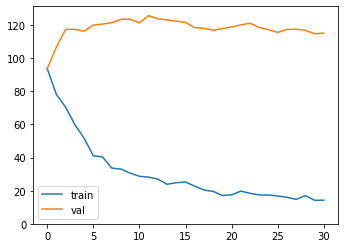

In [51]:
REQ_NAME = 'mouth_open'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
22/22 [==============================] - 8s 349ms/step - loss: 0.7738 - accuracy: 0.4560 - precision: 0.4699 - recall: 0.6829 - f1: 0.5478 - specificity: 0.2354 - negative_predictive_value: 0.4328 - matthews_correlation_coefficient: -0.0889 - equal_error_rate: 0.5104 - val_loss: 0.6385 - val_accuracy: 0.6313 - val_precision: 0.5898 - val_recall: 0.7925 - val_f1: 0.6709 - val_specificity: 0.4920 - val_negative_predictive_value: 0.7234 - val_matthews_correlation_coefficient: 0.2983 - val_equal_error_rate: 0.3139

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29828, saving model to ../../models/siamese_networks/mouth_open_2020_06_08-06_38_55.h5
Epoch 2/100
22/22 [==============================] - 4s 167ms/step - loss: 0.7147 - accuracy: 0.5217 - precision: 0.5214 - recall: 0.6580 - f1: 0.5700 - specificity: 0.3901 - negative_predictive_value: 0.5362 - matthews_correlation_coefficient: 0.0518 - equal_error_rate: 0.4498 - val_loss: 0.6306 - val_accura


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.40222
Epoch 14/100
22/22 [==============================] - 3s 147ms/step - loss: 0.6716 - accuracy: 0.5797 - precision: 0.5767 - recall: 0.6617 - f1: 0.6066 - specificity: 0.5026 - negative_predictive_value: 0.5869 - matthews_correlation_coefficient: 0.1638 - equal_error_rate: 0.4149 - val_loss: 0.6478 - val_accuracy: 0.6812 - val_precision: 0.6551 - val_recall: 0.7526 - val_f1: 0.6923 - val_specificity: 0.6292 - val_negative_predictive_value: 0.7335 - val_matthews_correlation_coefficient: 0.3852 - val_equal_error_rate: 0.3068

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.40222
Epoch 15/100
22/22 [==============================] - 3s 149ms/step - loss: 0.6817 - accuracy: 0.5348 - precision: 0.5362 - recall: 0.5953 - f1: 0.5529 - specificity: 0.4836 - negative_predictive_value: 0.5448 - matthews_correlation_coefficient: 0.0798 - equal_error_rate: 0.4426 - val_loss: 0.6484 - val_accurac

22/22 [==============================] - 3s 148ms/step - loss: 0.6672 - accuracy: 0.5855 - precision: 0.5791 - recall: 0.6154 - f1: 0.5857 - specificity: 0.5646 - negative_predictive_value: 0.5987 - matthews_correlation_coefficient: 0.1787 - equal_error_rate: 0.4061 - val_loss: 0.6621 - val_accuracy: 0.7000 - val_precision: 0.6707 - val_recall: 0.7459 - val_f1: 0.6955 - val_specificity: 0.6710 - val_negative_predictive_value: 0.7649 - val_matthews_correlation_coefficient: 0.4257 - val_equal_error_rate: 0.2889

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.44649
Epoch 28/100
22/22 [==============================] - 3s 148ms/step - loss: 0.6644 - accuracy: 0.5928 - precision: 0.5793 - recall: 0.6521 - f1: 0.6032 - specificity: 0.5484 - negative_predictive_value: 0.6203 - matthews_correlation_coefficient: 0.1998 - equal_error_rate: 0.3954 - val_loss: 0.6625 - val_accuracy: 0.6875 - val_precision: 0.6545 - val_recall: 0.7341 - val_f1: 0.6806 - val_specificity: 0.


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.44649
Epoch 41/100
22/22 [==============================] - 3s 147ms/step - loss: 0.6531 - accuracy: 0.6014 - precision: 0.5989 - recall: 0.6418 - f1: 0.6098 - specificity: 0.5630 - negative_predictive_value: 0.6013 - matthews_correlation_coefficient: 0.2023 - equal_error_rate: 0.3991 - val_loss: 0.6721 - val_accuracy: 0.6812 - val_precision: 0.6455 - val_recall: 0.7486 - val_f1: 0.6822 - val_specificity: 0.6344 - val_negative_predictive_value: 0.7510 - val_matthews_correlation_coefficient: 0.3895 - val_equal_error_rate: 0.3141

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.44649
Epoch 42/100
22/22 [==============================] - 3s 147ms/step - loss: 0.6636 - accuracy: 0.6145 - precision: 0.6131 - recall: 0.6308 - f1: 0.6137 - specificity: 0.5935 - negative_predictive_value: 0.6054 - matthews_correlation_coefficient: 0.2212 - equal_error_rate: 0.3777 - val_loss: 0.6731 - val_accurac

22/22 [==============================] - 3s 145ms/step - loss: 0.6592 - accuracy: 0.6101 - precision: 0.6185 - recall: 0.6160 - f1: 0.6076 - specificity: 0.6171 - negative_predictive_value: 0.6099 - matthews_correlation_coefficient: 0.2307 - equal_error_rate: 0.3754 - val_loss: 0.6787 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.7603 - val_f1: 0.7011 - val_specificity: 0.6580 - val_negative_predictive_value: 0.7624 - val_matthews_correlation_coefficient: 0.4235 - val_equal_error_rate: 0.3267

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.44649
Epoch 55/100
22/22 [==============================] - 3s 146ms/step - loss: 0.6438 - accuracy: 0.6319 - precision: 0.6394 - recall: 0.6628 - f1: 0.6423 - specificity: 0.6119 - negative_predictive_value: 0.6280 - matthews_correlation_coefficient: 0.2708 - equal_error_rate: 0.3521 - val_loss: 0.6779 - val_accuracy: 0.6875 - val_precision: 0.6528 - val_recall: 0.7368 - val_f1: 0.6802 - val_specificity: 0.


Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.44649
Epoch 68/100
22/22 [==============================] - 3s 146ms/step - loss: 0.6372 - accuracy: 0.6594 - precision: 0.6575 - recall: 0.6859 - f1: 0.6621 - specificity: 0.6376 - negative_predictive_value: 0.6573 - matthews_correlation_coefficient: 0.3190 - equal_error_rate: 0.3493 - val_loss: 0.6761 - val_accuracy: 0.6938 - val_precision: 0.6638 - val_recall: 0.7481 - val_f1: 0.6943 - val_specificity: 0.6580 - val_negative_predictive_value: 0.7475 - val_matthews_correlation_coefficient: 0.4086 - val_equal_error_rate: 0.3016

Epoch 00068: val_matthews_correlation_coefficient did not improve from 0.44649
Epoch 69/100
22/22 [==============================] - 3s 150ms/step - loss: 0.6456 - accuracy: 0.6304 - precision: 0.6322 - recall: 0.6363 - f1: 0.6256 - specificity: 0.6326 - negative_predictive_value: 0.6261 - matthews_correlation_coefficient: 0.2634 - equal_error_rate: 0.3698 - val_loss: 0.6764 - val_accurac

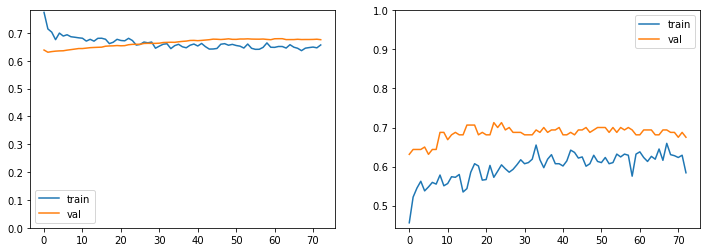

In [52]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### *24. Presence of Other Faces or Toys too Close to Face*

64 of 64
18 of 18
(65, 160, 160, 3) float32
(65,) int32
(17, 160, 160, 3) float32
(17,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 17s 170ms/step - loss: 93.3823 - val_loss: 91.5248
Epoch 2/100
100/100 [==============================] - 13s 127ms/step - loss: 72.9113 - val_loss: 70.1625
Epoch 3/100
100/100 [==============================] - 13s 127ms/step - loss: 62.5268 - val_loss: 52.6440
Epoch 4/100
100/100 [==============================] - 13s 127ms/step - loss: 54.9833 - val_loss: 42.2723
Epoch 5/100
100/100 [==============================] - 13s 127ms/step - loss: 44.4441 - val_loss: 30.4075
Epoch 6/100
100/100 [==============================] - 13s 127ms/step - loss: 30.9964 - val_loss: 25.7560
Epoch 7/100
100/100 [==============================] - 13s 127ms/step - loss: 19.0640 - val_loss: 27.3727
Epoch 8/100
100/100 [==============================] - 13s 127ms/step - loss: 12.1146 - val_loss: 49.1786
Epoch 9/100
100/100 [==============================] - 13s 127ms/step - loss: 7.1453 - val_loss: 35.2862
Epoch 10/100
100/100 [=========================

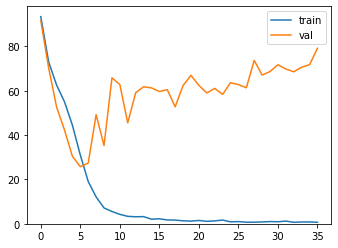

In [53]:
REQ_NAME = 'presence_of_other_faces_or_toys'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 5s 2s/step - loss: 0.8982 - accuracy: 0.4271 - precision: 0.4553 - recall: 0.5340 - f1: 0.4896 - specificity: 0.3063 - negative_predictive_value: 0.3823 - matthews_correlation_coefficient: -0.1611 - equal_error_rate: 0.5002 - val_loss: 0.8463 - val_accuracy: 0.6471 - val_precision: 0.8000 - val_recall: 0.4444 - val_f1: 0.5714 - val_specificity: 0.8750 - val_negative_predictive_value: 0.5833 - val_matthews_correlation_coefficient: 0.3499 - val_equal_error_rate: 0.2847

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.34993, saving model to ../../models/siamese_networks/presence_of_other_faces_or_toys_2020_06_08-06_54_21.h5
Epoch 2/100
3/3 [==============================] - 0s 152ms/step - loss: 0.9504 - accuracy: 0.3286 - precision: 0.2434 - recall: 0.2997 - f1: 0.2667 - specificity: 0.2333 - negative_predictive_value: 0.3766 - matthews_correlation_coefficient: -0.4175 - equal_error_rate: 0.6750 - val_loss: 0.83

3/3 [==============================] - 0s 125ms/step - loss: 0.5354 - accuracy: 0.7286 - precision: 0.5370 - recall: 0.3627 - f1: 0.4328 - specificity: 0.9185 - negative_predictive_value: 0.7263 - matthews_correlation_coefficient: 0.2993 - equal_error_rate: 0.3752 - val_loss: 0.8056 - val_accuracy: 0.5294 - val_precision: 0.6667 - val_recall: 0.2222 - val_f1: 0.3333 - val_specificity: 0.8750 - val_negative_predictive_value: 0.5000 - val_matthews_correlation_coefficient: 0.1273 - val_equal_error_rate: 0.2847

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.34993
Epoch 15/100
3/3 [==============================] - 0s 128ms/step - loss: 0.5300 - accuracy: 0.7143 - precision: 0.8928 - recall: 0.7049 - f1: 0.7798 - specificity: 0.9009 - negative_predictive_value: 0.7310 - matthews_correlation_coefficient: 0.6145 - equal_error_rate: 0.3222 - val_loss: 0.8088 - val_accuracy: 0.5294 - val_precision: 0.6667 - val_recall: 0.2222 - val_f1: 0.3333 - val_specificity: 0.8750


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.34993
Epoch 28/100
3/3 [==============================] - 0s 125ms/step - loss: 0.4588 - accuracy: 0.7429 - precision: 0.6667 - recall: 0.3246 - f1: 0.4365 - specificity: 1.0000 - negative_predictive_value: 0.7062 - matthews_correlation_coefficient: 0.3725 - equal_error_rate: 0.2909 - val_loss: 0.8528 - val_accuracy: 0.4706 - val_precision: 0.5000 - val_recall: 0.1111 - val_f1: 0.1818 - val_specificity: 0.8750 - val_negative_predictive_value: 0.4667 - val_matthews_correlation_coefficient: -0.0215 - val_equal_error_rate: 0.4097

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.34993
Epoch 29/100
3/3 [==============================] - 0s 122ms/step - loss: 0.5536 - accuracy: 0.7188 - precision: 1.0000 - recall: 0.4598 - f1: 0.6260 - specificity: 1.0000 - negative_predictive_value: 0.6293 - matthews_correlation_coefficient: 0.5363 - equal_error_rate: 0.1760 - val_loss: 0.8543 - val_accuracy: 

3/3 [==============================] - 0s 124ms/step - loss: 0.6126 - accuracy: 0.6458 - precision: 0.8524 - recall: 0.4029 - f1: 0.5458 - specificity: 0.9046 - negative_predictive_value: 0.5782 - matthews_correlation_coefficient: 0.3635 - equal_error_rate: 0.2606 - val_loss: 0.8345 - val_accuracy: 0.4706 - val_precision: 0.5000 - val_recall: 0.1111 - val_f1: 0.1818 - val_specificity: 0.8750 - val_negative_predictive_value: 0.4667 - val_matthews_correlation_coefficient: -0.0215 - val_equal_error_rate: 0.4097

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.34993
Epoch 42/100
3/3 [==============================] - 0s 116ms/step - loss: 0.4649 - accuracy: 0.7000 - precision: 0.6000 - recall: 0.2689 - f1: 0.3636 - specificity: 0.9778 - negative_predictive_value: 0.7006 - matthews_correlation_coefficient: 0.2955 - equal_error_rate: 0.3146 - val_loss: 0.8349 - val_accuracy: 0.4706 - val_precision: 0.5000 - val_recall: 0.1111 - val_f1: 0.1818 - val_specificity: 0.875

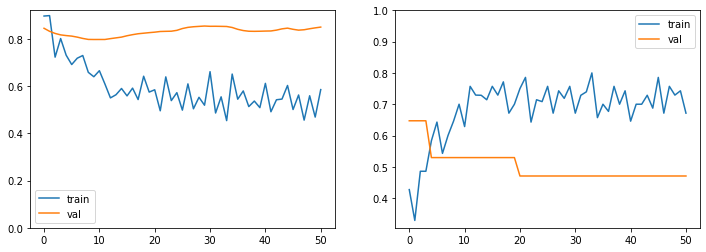

In [54]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

In [55]:
print(len(list_model_files))
print(np.array(list_model_files))

21
['../../models/siamese_networks/blurred_2020_06_07-23_58_17.h5'
 '../../models/siamese_networks/looking_away_2020_06_08-00_22_35.h5'
 '../../models/siamese_networks/unnatural_skin_tone_2020_06_08-00_32_06.h5'
 '../../models/siamese_networks/too_dark_light_2020_06_08-01_03_04.h5'
 '../../models/siamese_networks/washed_out_2020_06_08-01_14_10.h5'
 '../../models/siamese_networks/pixelation_2020_06_08-01_26_46.h5'
 '../../models/siamese_networks/hair_across_eyes_2020_06_08-01_41_39.h5'
 '../../models/siamese_networks/eyes_closed_2020_06_08-01_54_19.h5'
 '../../models/siamese_networks/varied_background_2020_06_08-02_08_37.h5'
 '../../models/siamese_networks/roll_pitch_yaw_2020_06_08-02_25_59.h5'
 '../../models/siamese_networks/flash_reflection_on_skin_2020_06_08-02_46_17.h5'
 '../../models/siamese_networks/red_eyes_2020_06_08-03_14_49.h5'
 '../../models/siamese_networks/shadows_behind_head_2020_06_08-03_36_38.h5'
 '../../models/siamese_networks/shadows_across_face_2020_06_08-04_03_16.h5'

# Models Merge

In [56]:
def load_shared_model(file_autoencoder):
    autoencoder = load_model(file_autoencoder)
    encoder_output = autoencoder.get_layer(name='encoded').output
    embeddings = GlobalAvgPool2D(name='embeddings')(encoder_output)
    shared_model = Model(inputs=autoencoder.inputs, outputs=embeddings)
    return shared_model


def add_requirement_branch_to_base_model(base_model, req_model):
    n_layers = len(base_model.layers)
    req_layers = [layer for layer in req_model.layers[n_layers:]]

    outputs = base_model.output
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)
    return outputs

In [57]:
shared_model = load_shared_model(FILE_BASE_MODEL)
shared_model.summary()

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Model: "model_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 32)      128       
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 32)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 64)        18496     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 80, 80, 64)        256

In [58]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc,
    'equal_error_rate': eer
}

list_models = [load_model(file, custom_objects=custom_objects) for file in list_model_files]
list_outputs = [add_requirement_branch_to_base_model(shared_model, req_model) for req_model in list_models]

In [59]:
FILE_MERGED_MODEL = FOLDER_MODELS + '/' + timestamp_model_name(prefix='merged_model_')
print(FILE_MERGED_MODEL)

merged_model = Model(inputs=shared_model.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

../../models/siamese_networks/merged_model_2020_06_08-07_18_31.h5
Model: "model_86"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
_________________________

In [60]:
import cv2
from glob import glob

list_files = ['../../data/cropped_faces/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../../data/cropped_faces/images/AR_FDB_m-013-17.png
1 of 1


[array([[0.284162]], dtype=float32),
 array([[0.2709383]], dtype=float32),
 array([[0.76345634]], dtype=float32),
 array([[0.5141355]], dtype=float32),
 array([[0.0810314]], dtype=float32),
 array([[0.4943378]], dtype=float32),
 array([[0.6328062]], dtype=float32),
 array([[0.31676295]], dtype=float32),
 array([[0.94546205]], dtype=float32),
 array([[0.63634205]], dtype=float32),
 array([[0.73478127]], dtype=float32),
 array([[0.6914883]], dtype=float32),
 array([[0.01958743]], dtype=float32),
 array([[0.7544807]], dtype=float32),
 array([[0.6954164]], dtype=float32),
 array([[0.3472372]], dtype=float32),
 array([[0.70817655]], dtype=float32),
 array([[0.9891255]], dtype=float32),
 array([[0.99160767]], dtype=float32),
 array([[0.4129821]], dtype=float32),
 array([[0.26010162]], dtype=float32)]